## Imports

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import datetime
warnings.filterwarnings('ignore')
#print(sns.__version__)

In [2]:
#Read file into a DataFrame and print head.
xword_data = pd.ExcelFile('../data/NYT_XWord_data.xlsx', engine='openpyxl')
print(xword_data.sheet_names)

['Sheet1']


In [3]:
df1 = xword_data.parse('Sheet1')

In [ ]:
df1.head(35)

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2198 entries, 0 to 2197
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Puzzle_Date                   2198 non-null   datetime64[ns]
 1   Completed_Date (IS1)          1154 non-null   datetime64[ns]
 2   Completed_Date (IS2)          1002 non-null   datetime64[ns]
 3   Day_of_Week                   2198 non-null   object        
 4   Time (s) (IS1)                1154 non-null   float64       
 5   Time (s) (IS2)                1002 non-null   float64       
 6   Global_Median_Solver_Time(s)  2198 non-null   int64         
 7   Difficulty                    2198 non-null   object        
 8   Median_Solver%_AVG_PM         2198 non-null   int64         
 9   Grid Size                     2198 non-null   int64         
 10  No_Constructors               2198 non-null   int64         
 11  Constructors(by seniority)    

## Data Cleaning and Global Median Solver Feature Creation
A few generally useful operations for the exploratory analysis of the global median solver 

In [ ]:
# Delete weird columns at the back end of the imported data
#df2 = df1.drop(columns=df1.columns[-6:], axis=1)

In [5]:
# Drop other columns that, while potentially useful for predictive modeling, aren't necessary for the exploratory data analysis
df2 = df1.drop(['Difficulty', '1st_Constructor', '1st_Constuctor_Gender', '1st_Constructor_Puzzle_N', '1st_Constructor_Debut', '1st_Constructor_Scrabble_Avg', '1st_Constructor_Fresh%_Avg', '2nd_Constructor', '2nd_Constuctor_Gender', '2nd_Constructor_Puzzle_N', '2nd_Constructor_Debut', '2nd_Constructor_Scrabble_Avg', '2nd_Constructor_Fresh%_Avg', '3rd_Constructor', '3rd_Constuctor_Gender', '3rd_Constructor_Puzzle_N', '3rd_Constructor_Debut', '3rd_Constructor_Scrabble_Avg', '3rd_Constructor_Fresh%_Avg', 'Spans', '2_Stacks', '3_4_Stacks', 'Mirror_Sym', 'UD_Sym', 'Asym', 'Supersym', '90_180_Rot_Sym', 'LR_UD_Sym', 'Diag_Sym', 'Black_Square_Fill','Outside_Grid', 'Unchecked_Sq','Uniclue','Duplicate_Answers','Quantum'], axis=1)

In [6]:
# Rename a column for brevity and clarity
df2.rename(columns={'Constructors(by seniority)': 'Constructors'}, inplace=True)

In [7]:
# It will be useful generally to have puzzle dates as strings in other columns along with the datetimes 
df2['P_Date_str'] = df2['Puzzle_Date'].dt.strftime('%Y-%m-%d') #we want datetime as a string to index into here

In [8]:
# Convert global median solve times per puzzle to minutes and drop times in seconds
df2["GMST(m)"] = df2["Global_Median_Solver_Time(s)"]/60  #GMST = Global Median solve times
df2.drop(['Global_Median_Solver_Time(s)'], axis=1, inplace=True)

In [9]:
# Calculate 10-puzzle moving average for global solver raw solve times, within Day of Week
# Unlike for Individual Solvers (see below), we do not have completion dates for median solver per puzzle. It is therefor assumed that completion date tracks with puzzle date (obviously not always going to be true, but approximates true closely enough for our purposes)
df2 = df2.sort_values(by=['Day_of_Week','Puzzle_Date'], ascending = True)
df2['GMST(m)_10p_MA'] = df2.groupby('Day_of_Week')['GMST(m)'].transform(lambda x: x.rolling(10, 3).mean().reset_index(drop=True))
df2 = df2.sort_values(by=['Day_of_Week','Puzzle_Date'], ascending = False)

In [10]:
# Calculate 20-puzzle moving average for global solver raw solve times, within Day of Week
# Unlike for Individual Solvers (see below), we do not have completion dates for median solver per puzzle. It is therefor assumed that completion date tracks with puzzle date (obviously not always going to be true, but approximates true closely enough for our purposes)
df2 = df2.sort_values(by=['Day_of_Week','Puzzle_Date'], ascending = True)
df2['GMST(m)_20p_MA'] = df2.groupby('Day_of_Week')['GMST(m)'].transform(lambda x: x.rolling(20, 3).mean().reset_index(drop=True))
df2 = df2.sort_values(by=['Day_of_Week','Puzzle_Date'], ascending = False)

In [11]:
# It will be useful to have year of puzzle issue in a separate column for analysis below
df2['P_Yr'] = df2['Puzzle_Date'].dt.to_period('Y')
df2['P_Yr'].value_counts()

2020    366
2023    365
2021    365
2019    365
2022    365
2018    365
2024      7
Freq: A-DEC, Name: P_Yr, dtype: int64

In [12]:
# Also, a column indicating pre-2023 puzzle issue date or 2023-2024 puzzle issue date
df2.loc[(df2["P_Yr"] == "2023") | (df2["P_Yr"] == "2024"), "2023+_puzzle"] = 1 #2023 or 2024 puzzle issue date
df2.loc[(df2["P_Yr"] != "2023") & (df2["P_Yr"] != "2024"), "2023+_puzzle"] = 0 #pre-2023 puzzle issue date

In [13]:
# Rename a few columns for brevity and clarity
df2.rename(columns={'Median_Solver%_AVG_PM':'Diff%_from_10pMA(GMS)', 'Day_of_Week': 'DOW', 'Puzzle_Date': 'P_Date'}, inplace=True)

In [14]:
# A numerical column for puzzle day that starts with Sunday and ends with Saturday
df2.loc[(df2["DOW"] == "Sunday"), "DOW_num"] = 1 
df2.loc[(df2["DOW"] == "Monday"), "DOW_num"] = 2
df2.loc[(df2["DOW"] == "Tuesday"), "DOW_num"] = 3
df2.loc[(df2["DOW"] == "Wednesday"), "DOW_num"] = 4
df2.loc[(df2["DOW"] == "Thursday"), "DOW_num"] = 5
df2.loc[(df2["DOW"] == "Friday"), "DOW_num"] = 6
df2.loc[(df2["DOW"] == "Saturday"), "DOW_num"] = 7

In [16]:
# Move new columns to logical places in dataframe
col = df2.pop('P_Date_str')
df2.insert(1, col.name, col)

col = df2.pop('P_Yr')
df2.insert(2, col.name, col)

col = df2.pop('2023+_puzzle')
df2.insert(3, col.name, col)

col = df2.pop('DOW')
df2.insert(4, col.name, col)

col = df2.pop('DOW_num')
df2.insert(5, col.name, col)

col = df2.pop('GMST(m)')
df2.insert(10, col.name, col)

col = df2.pop('GMST(m)_10p_MA')
df2.insert(11, col.name, col)

col = df2.pop('GMST(m)_20p_MA')
df2.insert(12, col.name, col)

In [ ]:
df2.info()

In [ ]:
# Computes mean global median solve times per puzzle day, per year. These will be used later on when making difficulty of "schedule" adjustments to past individual solver performance
# mean_Sat_2023 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
# mean_Sat_2022 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
# mean_Sat_2021 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
# mean_Sat_2020 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
# mean_Sat_2019 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
# mean_Sat_2018 = df2.loc[(df2["DOW"] == "Saturday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

# mean_Fri_2023 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
# mean_Fri_2022 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
# mean_Fri_2021 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
# mean_Fri_2020 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
# mean_Fri_2019 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
# mean_Fri_2018 = df2.loc[(df2["DOW"] == "Friday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

# mean_Thu_2023 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
# mean_Thu_2022 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
# mean_Thu_2021 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
# mean_Thu_2020 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
# mean_Thu_2019 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
# mean_Thu_2018 = df2.loc[(df2["DOW"] == "Thursday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

# mean_Wed_2023 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
# mean_Wed_2022 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
# mean_Wed_2021 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
# mean_Wed_2020 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
# mean_Wed_2019 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
# mean_Wed_2018 = df2.loc[(df2["DOW"] == "Wednesday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

# mean_Tue_2023 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
# mean_Tue_2022 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
# mean_Tue_2021 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
# mean_Tue_2020 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
# mean_Tue_2019 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
# mean_Tue_2018 = df2.loc[(df2["DOW"] == "Tuesday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

# mean_Mon_2023 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
# mean_Mon_2022 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
# mean_Mon_2021 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
# mean_Mon_2020 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
# mean_Mon_2019 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
# mean_Mon_2018 = df2.loc[(df2["DOW"] == "Monday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()

# mean_Sun_2023 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2023"), "GMST(m)"].mean()
# mean_Sun_2022 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2022"), "GMST(m)"].mean()
# mean_Sun_2021 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2021"), "GMST(m)"].mean()
# mean_Sun_2020 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2020"), "GMST(m)"].mean()
# mean_Sun_2019 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2019"), "GMST(m)"].mean()
# mean_Sun_2018 = df2.loc[(df2["DOW"] == "Sunday") & (df2["P_Yr"] == "2018"), "GMST(m)"].mean()


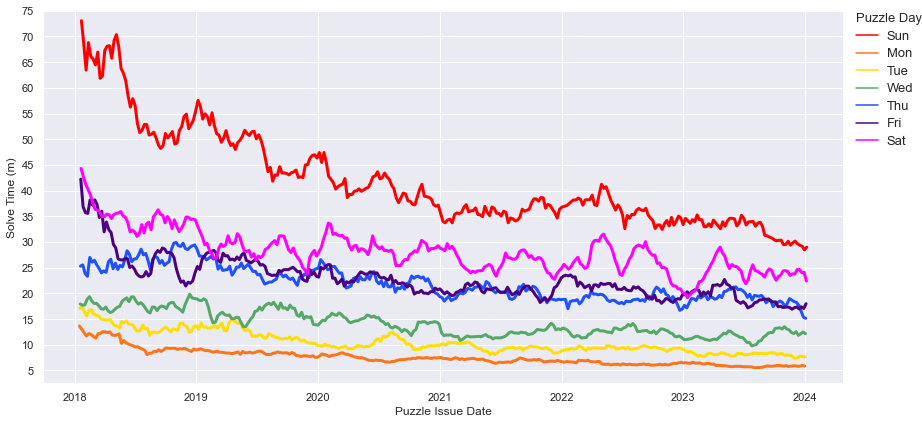

In [17]:
# Plot 10-puzzle moving average of Global Median Solve Times by Day of Week

sns.set(font_scale=1)

p = sns.relplot(
    data=df2, marker = "", x="P_Date", y="GMST(m)_10p_MA", hue="DOW", hue_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], height=6, aspect=2, palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "indigo", "fuchsia"],
    kind="line", linewidth=3 
).set(title="", 
    ylabel="Solve Time (m)",
    xlabel= "Puzzle Issue Date", ylim=[2.5, 75], yticks = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75]
)

# Modify legend
leg = p._legend
leg.set_title("Puzzle Day")
leg.set_bbox_to_anchor([.88, .975])  # coordinates of lower left of bounding box
leg.get_title().set_fontsize(13)
leg._loc = 2  # if required you can set the loc
leg.get_texts()[0].set_fontsize(13)
leg.get_texts()[0].set_text('Sun')
leg.get_texts()[1].set_fontsize(13)
leg.get_texts()[1].set_text('Mon')
leg.get_texts()[2].set_fontsize(13)
leg.get_texts()[2].set_text('Tue')
leg.get_texts()[3].set_fontsize(13)
leg.get_texts()[3].set_text('Wed')
leg.get_texts()[4].set_fontsize(13)
leg.get_texts()[4].set_text('Thu')
leg.get_texts()[5].set_fontsize(13)
leg.get_texts()[5].set_text('Fri')
leg.get_texts()[6].set_fontsize(13)
leg.get_texts()[6].set_text('Sat')
leg._legend_box.align = "left"  # or left, or center

In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2198 entries, 4 to 2193
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   P_Date                 2198 non-null   datetime64[ns]
 1   P_Date_str             2198 non-null   object        
 2   P_Yr                   2198 non-null   period[A-DEC] 
 3   2023+_puzzle           2198 non-null   float64       
 4   DOW                    2198 non-null   object        
 5   DOW_num                2198 non-null   float64       
 6   Completed_Date (IS1)   1154 non-null   datetime64[ns]
 7   Completed_Date (IS2)   1002 non-null   datetime64[ns]
 8   Time (s) (IS1)         1154 non-null   float64       
 9   Time (s) (IS2)         1002 non-null   float64       
 10  GMST(m)                2198 non-null   float64       
 11  GMST(m)_10p_MA         2184 non-null   float64       
 12  GMST(m)_20p_MA         2184 non-null   float64       
 13  Dif

In [ ]:
# Checkpoint
df2.to_csv('../data/df2.csv', index=False)

## Individual Solver 1 (IS1) (JNR) Data Cleaning and Feature Creation

In [19]:
# Keep only puzzles for which IS1 has a solve time, and drop columns specific to Individual Solver 2 (IS2)
df_IS1 = df2.dropna(subset=['Time (s) (IS1)'])
df_IS1.drop(["Completed_Date (IS2)", "Time (s) (IS2)"], axis = 1, inplace=True)

In [ ]:
df_IS1.info()

In [ ]:
df_IS1.head()

In [20]:
# It will be useful to have IS1 puzzle completion dates as strings in other columns along with the datetimes 
df_IS1['Comp_Date_str'] = df_IS1['Completed_Date (IS1)'].dt.strftime('%Y-%m-%d') #we want datetime as a string to index into here

In [21]:
# Convert Individual Solver1 (IS1) solve times per puzzle to minutes and drop times in seconds
df_IS1["IST(m)"] = df_IS1["Time (s) (IS1)"]/60   #IST = Individual solver times 
df_IS1.drop(['Time (s) (IS1)'], axis=1, inplace=True)

In [22]:
# It will be useful to have year of puzzle completion for this solver in a separate column for analysis below
df_IS1['Comp_Yr'] = df_IS1['Completed_Date (IS1)'].dt.to_period('Y')
df_IS1['Comp_Yr'].value_counts()

2022    493
2023    424
2021    230
2024      7
Freq: A-DEC, Name: Comp_Yr, dtype: int64

In [23]:
# Also, a column indicating pre-2023 solve or 2023 solve
df_IS1.loc[(df_IS1["Comp_Yr"] == "2023") | (df_IS1["Comp_Yr"] == "2024"), "2023+_solve"] = 1 #2023_2024 solve
df_IS1.loc[(df_IS1["Comp_Yr"] != "2023"), "2023+_solve"] = 0 #pre-2023 solve
df_IS1['2023+_solve'].value_counts()

0.0    730
1.0    424
Name: 2023+_solve, dtype: int64

In [24]:
# Rename a column for brevity and clarity
df_IS1.rename(columns={'Completed_Date (IS1)': 'Comp_Date'}, inplace=True)

In [25]:
# Move new columns to logical places in dataframe
col = df_IS1.pop('Comp_Date_str')
df_IS1.insert(7, col.name, col)

col = df_IS1.pop('Comp_Yr')
df_IS1.insert(8, col.name, col)

col = df_IS1.pop('2023+_solve')
df_IS1.insert(9, col.name, col)

col = df_IS1.pop('IST(m)')
df_IS1.insert(10, col.name, col)

In [26]:
df_IS1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1154 entries, 4 to 1150
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   P_Date                 1154 non-null   datetime64[ns]
 1   P_Date_str             1154 non-null   object        
 2   P_Yr                   1154 non-null   period[A-DEC] 
 3   2023+_puzzle           1154 non-null   float64       
 4   DOW                    1154 non-null   object        
 5   DOW_num                1154 non-null   float64       
 6   Comp_Date              1154 non-null   datetime64[ns]
 7   Comp_Date_str          1154 non-null   object        
 8   Comp_Yr                1154 non-null   period[A-DEC] 
 9   2023+_solve            1154 non-null   float64       
 10  IST(m)                 1154 non-null   float64       
 11  GMST(m)                1154 non-null   float64       
 12  GMST(m)_10p_MA         1154 non-null   float64       
 13  GMS

## Feature Calculations

In [27]:
# Calculate 10- and 20-puzzle moving average for individual solver (IS1) raw solve times, within Day of Week 
df_IS1 = df_IS1.sort_values(by=['DOW','Comp_Date'], ascending = True)

df_IS1['IST(m)_10p_MA'] = df_IS1.groupby('DOW')['IST(m)'].transform(lambda x: x.rolling(10, 3).mean().reset_index(drop=True))
df_IS1['IST(m)_20p_MA'] = df_IS1.groupby('DOW')['IST(m)'].transform(lambda x: x.rolling(20, 3).mean().reset_index(drop=True))

# Calculate deviation from 10- and 20- puzzle moving averages for individual solver
df_IS1['IS_Diff%_10pMA'] = (((df_IS1['IST(m)'] - df_IS1['IST(m)_10p_MA']))/((df_IS1['IST(m)'] + df_IS1['IST(m)_10p_MA'])/2)*100).round(2)
df_IS1['IS_Diff%_20pMA'] = (((df_IS1['IST(m)'] - df_IS1['IST(m)_20p_MA']))/((df_IS1['IST(m)'] + df_IS1['IST(m)_20p_MA'])/2)*100).round(2)

df_IS1 = df_IS1.sort_values(by=['DOW','Comp_Date'], ascending = False)

In [28]:
# Calculate solve time % difference from Global Median Solve Time, per solve
df_IS1['IS_Diff%_GMST'] = (((df_IS1['IST(m)'] - df_IS1['GMST(m)']))/((df_IS1['IST(m)'] + df_IS1['GMST(m)'])/2)*100).round(2)

# Now compute 10- and 20- puzzle moving averages for this difference from median solver
df_IS1 = df_IS1.sort_values(by=['DOW','Comp_Date'], ascending = True)
df_IS1['IS_Diff%_GMST_10pMA'] = df_IS1.groupby('DOW')['IS_Diff%_GMST'].transform(lambda x: x.rolling(10, 3).mean().reset_index(drop=True))

df_IS1 = df_IS1.sort_values(by=['DOW','Comp_Date'], ascending = True)
df_IS1['IS_Diff%_GMST_20pMA'] = df_IS1.groupby('DOW')['IS_Diff%_GMST'].transform(lambda x: x.rolling(20, 3).mean().reset_index(drop=True))

df_IS1 = df_IS1.sort_values(by=['DOW','Comp_Date'], ascending = False)

In [29]:
# Move new columns to logical places in dataframe
col = df_IS1.pop('IST(m)_10p_MA')
df_IS1.insert(11, col.name, col)

col = df_IS1.pop('IST(m)_20p_MA')
df_IS1.insert(12, col.name, col)

col = df_IS1.pop('IS_Diff%_10pMA')
df_IS1.insert(13, col.name, col)

col = df_IS1.pop('IS_Diff%_20pMA')
df_IS1.insert(14, col.name, col)

col = df_IS1.pop('IS_Diff%_GMST')
df_IS1.insert(15, col.name, col)

col = df_IS1.pop('IS_Diff%_GMST_10pMA')
df_IS1.insert(16, col.name, col)

col = df_IS1.pop('IS_Diff%_GMST_20pMA')
df_IS1.insert(17, col.name, col)

In [30]:
df_IS1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1154 entries, 4 to 877
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   P_Date                 1154 non-null   datetime64[ns]
 1   P_Date_str             1154 non-null   object        
 2   P_Yr                   1154 non-null   period[A-DEC] 
 3   2023+_puzzle           1154 non-null   float64       
 4   DOW                    1154 non-null   object        
 5   DOW_num                1154 non-null   float64       
 6   Comp_Date              1154 non-null   datetime64[ns]
 7   Comp_Date_str          1154 non-null   object        
 8   Comp_Yr                1154 non-null   period[A-DEC] 
 9   2023+_solve            1154 non-null   float64       
 10  IST(m)                 1154 non-null   float64       
 11  IST(m)_10p_MA          1140 non-null   float64       
 12  IST(m)_20p_MA          1140 non-null   float64       
 13  IS_D

In [ ]:
# Checkpoint
df_IS1.to_csv('../data/df_IS1.csv', index=False)

## Individual Solver 1 (IS1) Figure Creation

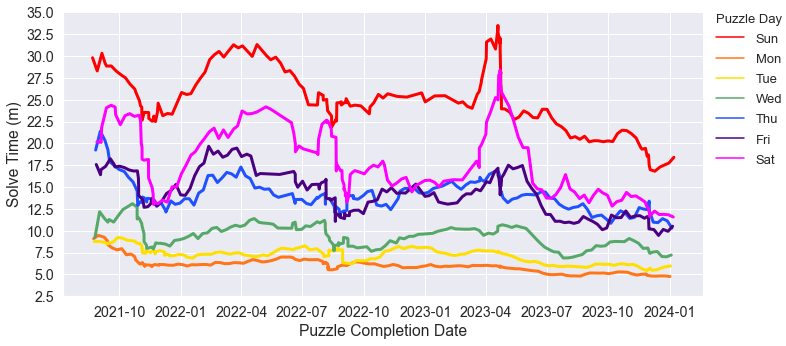

In [31]:
# Plot 10-puzzle moving average of IS1 Solve Times by Day of Week

sns.set(font_scale=1.3)

p = sns.relplot(
    data=df_IS1, marker = "", x="Comp_Date", y="IST(m)_10p_MA", hue="DOW", hue_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], height=5, aspect=2, palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "indigo", "fuchsia"],
    kind="line", linewidth=3
).set(title="", 
    ylabel="Solve Time (m)",
    xlabel= "Puzzle Completion Date", yticks = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35]
)

# Modify legend
leg = p._legend
leg.set_title("Puzzle Day")
leg.set_bbox_to_anchor([.83, .96])  # coordinates of lower left of bounding box
leg.get_title().set_fontsize(13)
leg._loc = 2  # if required you can set the loc
leg.get_texts()[0].set_fontsize(13)
leg.get_texts()[0].set_text('Sun')
leg.get_texts()[1].set_fontsize(13)
leg.get_texts()[1].set_text('Mon')
leg.get_texts()[2].set_fontsize(13)
leg.get_texts()[2].set_text('Tue')
leg.get_texts()[3].set_fontsize(13)
leg.get_texts()[3].set_text('Wed')
leg.get_texts()[4].set_fontsize(13)
leg.get_texts()[4].set_text('Thu')
leg.get_texts()[5].set_fontsize(13)
leg.get_texts()[5].set_text('Fri')
leg.get_texts()[6].set_fontsize(13)
leg.get_texts()[6].set_text('Sat')
leg._legend_box.align = "left"  # or left, or center

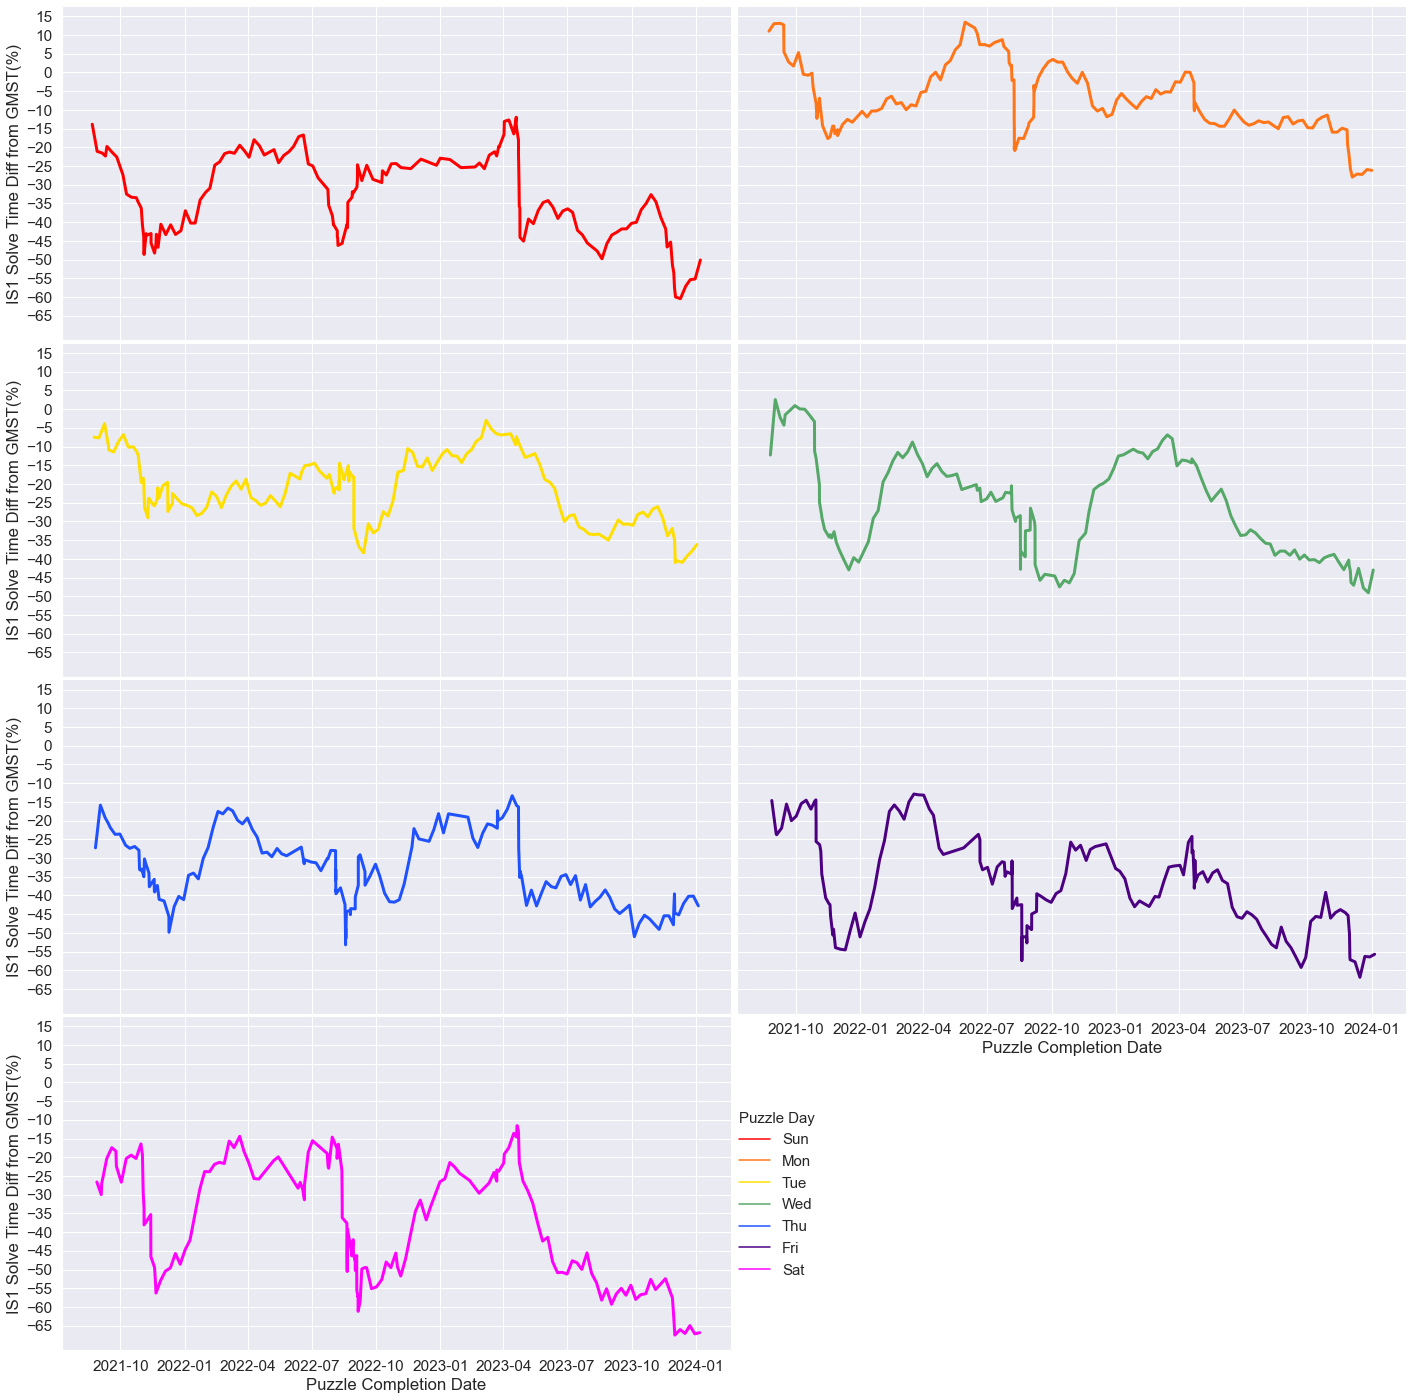

In [32]:
# Plot 10-puzzle moving average of % Difference in Individual Solve Times From Global Median Solve Times
# This normalizes for puzzle difficulty
sns.set(font_scale=1.4)
#sns.set(rc={'axes.facecolor':'gray',"axes.grid":True,'xtick.labelsize':14,'ytick.labelsize':14})

p = sns.relplot(
    data=df_IS1, marker = "", x="Comp_Date", y="IS_Diff%_GMST_10pMA", hue="DOW", hue_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], height=5, aspect=2, palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "indigo", "fuchsia"],
    kind="line", linewidth=3, col="DOW", col_wrap=2, col_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"]
).set(title="", ylabel="IS1 Solve Time Diff from GMST(%)",
    xlabel= "Puzzle Completion Date", yticks = [-65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15]
)

plt.subplots_adjust(wspace = 0.01) #decrease whitespace btwn subplot colums
plt.subplots_adjust(hspace = 0.01) #decrease whitespace btwn subplot rows

# # # Modify legend
leg = p._legend
leg.set_title("Puzzle Day")
leg.set_bbox_to_anchor([.46, .21])  # coordinates of lower left of bounding box
leg.get_title().set_fontsize(15)
leg._loc = 2  # if required you can set the loc
leg.get_texts()[0].set_fontsize(15)
leg.get_texts()[0].set_text('Sun')
leg.get_texts()[1].set_fontsize(15)
leg.get_texts()[1].set_text('Mon')
leg.get_texts()[2].set_fontsize(15)
leg.get_texts()[2].set_text('Tue')
leg.get_texts()[3].set_fontsize(15)
leg.get_texts()[3].set_text('Wed')
leg.get_texts()[4].set_fontsize(15)
leg.get_texts()[4].set_text('Thu')
leg.get_texts()[5].set_fontsize(15)
leg.get_texts()[5].set_text('Fri')
leg.get_texts()[6].set_fontsize(15)
leg.get_texts()[6].set_text('Sat')
leg._legend_box.align = "left"  # or left, or center

#title="10-Puzzle Moving Average of % Difference in Solve Times From Global Median Solve Times (Solver 1)", 

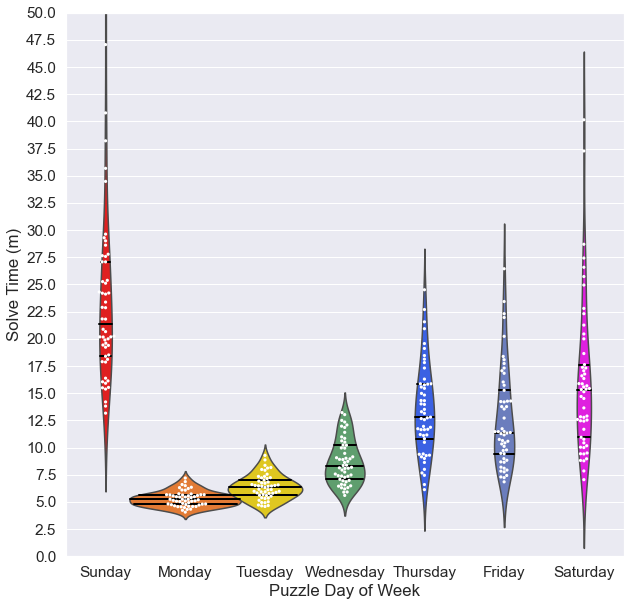

In [36]:
# Violin plots with swarm plot overlay by puzzle day -2023/4 only
sns.set(font_scale=1.4)

IS1_2023 = df_IS1.loc[df_IS1["P_Date_str"].str.contains("2023") | df_IS1["P_Date_str"].str.contains("2024")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "IST(m)",data=IS1_2023 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(IS1_2023['DOW'], IS1_2023['IST(m)'], width = 1.4, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 50)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50])
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

In [39]:
# Calculate Median and IQR per puzzle day, for 2023/2024
print(IS1_2023.loc[(IS1_2023["DOW"] == "Sunday"), "IST(m)"].describe().round(1))
print(IS1_2023.loc[(IS1_2023["DOW"] == "Monday"), "IST(m)"].describe().round(1))
print(IS1_2023.loc[(IS1_2023["DOW"] == "Tuesday"), "IST(m)"].describe().round(1))
print(IS1_2023.loc[(IS1_2023["DOW"] == "Wednesday"), "IST(m)"].describe().round(1))
print(IS1_2023.loc[(IS1_2023["DOW"] == "Thursday"), "IST(m)"].describe().round(1))
print(IS1_2023.loc[(IS1_2023["DOW"] == "Friday"), "IST(m)"].describe().round(1))
print(IS1_2023.loc[(IS1_2023["DOW"] == "Saturday"), "IST(m)"].describe().round(1))

count    54.0
mean     23.5
std       8.0
min      13.2
25%      18.4
50%      21.4
75%      27.1
max      52.2
Name: IST(m), dtype: float64
count    53.0
mean      5.3
std       0.7
min       4.1
25%       4.8
50%       5.2
75%       5.7
max       7.2
Name: IST(m), dtype: float64
count    53.0
mean      6.4
std       1.1
min       4.6
25%       5.6
50%       6.3
75%       7.0
max       9.3
Name: IST(m), dtype: float64
count    53.0
mean      8.7
std       2.1
min       5.6
25%       7.1
50%       8.4
75%      10.2
max      13.2
Name: IST(m), dtype: float64
count    53.0
mean     13.5
std       4.2
min       6.1
25%      10.8
50%      12.8
75%      15.8
max      24.5
Name: IST(m), dtype: float64
count    53.0
mean     12.7
std       4.6
min       6.8
25%       9.4
50%      11.4
75%      15.3
max      26.4
Name: IST(m), dtype: float64
count    53.0
mean     16.1
std       6.9
min       7.0
25%      11.0
50%      15.3
75%      17.6
max      40.2
Name: IST(m), dtype: float64


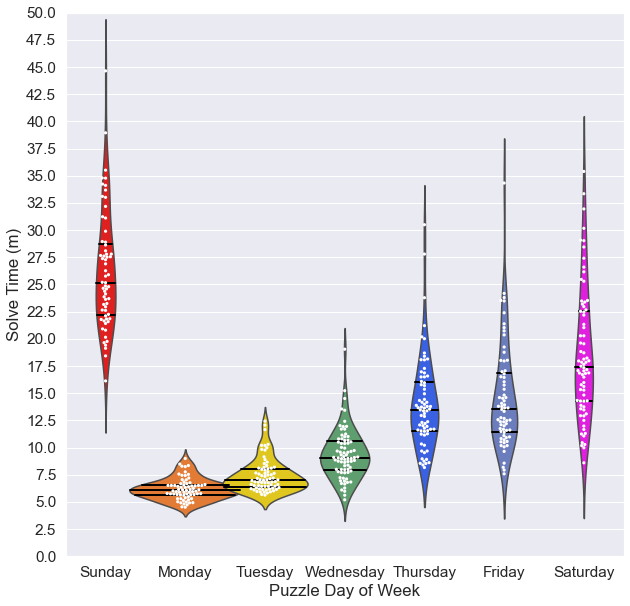

In [40]:
# Violin plots with swarm plot overlay by puzzle day -2022 solves only

IS1_2022 = df_IS1.loc[df_IS1["Comp_Date_str"].str.contains("2022")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "IST(m)",data=IS1_2022 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(IS1_2022['DOW'], IS1_2022['IST(m)'], width = 1.4, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 50)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50])
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

In [41]:
# Calculate Median and IQR per puzzle day, for 2022
print(IS1_2022.loc[(IS1_2022["DOW"] == "Sunday"), "IST(m)"].describe().round(1))
print(IS1_2022.loc[(IS1_2022["DOW"] == "Monday"), "IST(m)"].describe().round(1))
print(IS1_2022.loc[(IS1_2022["DOW"] == "Tuesday"), "IST(m)"].describe().round(1))
print(IS1_2022.loc[(IS1_2022["DOW"] == "Wednesday"), "IST(m)"].describe().round(1))
print(IS1_2022.loc[(IS1_2022["DOW"] == "Thursday"), "IST(m)"].describe().round(1))
print(IS1_2022.loc[(IS1_2022["DOW"] == "Friday"), "IST(m)"].describe().round(1))
print(IS1_2022.loc[(IS1_2022["DOW"] == "Saturday"), "IST(m)"].describe().round(1))

count    63.0
mean     26.3
std       5.4
min      16.1
25%      22.2
50%      25.2
75%      28.8
max      44.6
Name: IST(m), dtype: float64
count    70.0
mean      6.2
std       1.0
min       4.5
25%       5.7
50%       6.1
75%       6.6
max       9.0
Name: IST(m), dtype: float64
count    72.0
mean      7.4
std       1.5
min       5.6
25%       6.4
50%       7.0
75%       8.1
max      12.4
Name: IST(m), dtype: float64
count    76.0
mean      9.4
std       2.3
min       5.2
25%       7.9
50%       9.1
75%      10.6
max      19.0
Name: IST(m), dtype: float64
count    70.0
mean     14.0
std       4.3
min       8.2
25%      11.5
50%      13.5
75%      16.1
max      30.5
Name: IST(m), dtype: float64
count    68.0
mean     14.6
std       4.8
min       7.6
25%      11.5
50%      13.6
75%      16.8
max      34.3
Name: IST(m), dtype: float64
count    74.0
mean     18.6
std       6.0
min       8.6
25%      14.3
50%      17.4
75%      22.5
max      35.4
Name: IST(m), dtype: float64


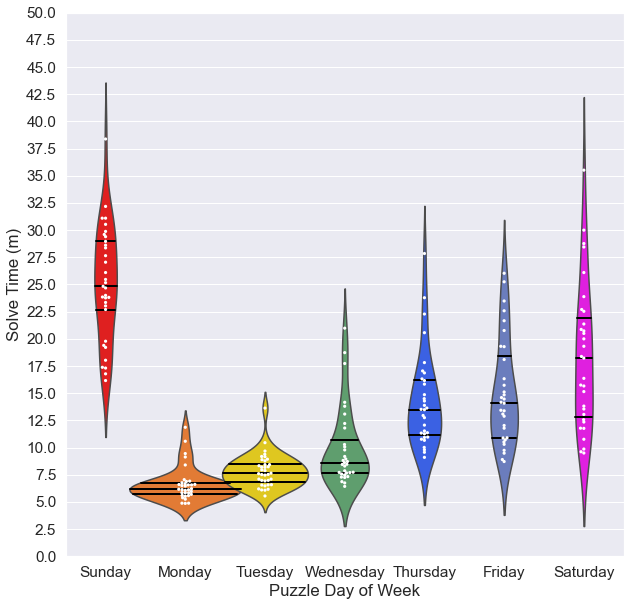

In [42]:
# Violin plots with swarm plot overlay by puzzle day pre-2022 solves only

IS1_pre2022 = df_IS1.loc[df_IS1["Comp_Date_str"].str.contains("2021") | df_IS1["Comp_Date_str"].str.contains("2020")]

plt.figure(figsize=(10,10))
sns.swarmplot(x="DOW" , y = "IST(m)",data=IS1_pre2022 , size=3.2 , order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], color="White")
ax = sns.violinplot(IS1_pre2022['DOW'], IS1_pre2022['IST(m)'], width = 1.4, inner = "quartile", order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], palette = ["red", "#FF7518", "#ffdf00", "g", "#1F51FF", "#5d76cb", "fuchsia"])
plt.ylim(0, 50)
plt.yticks([0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50])
ax.set_xlabel("Puzzle Day of Week")
ax.set_ylabel("Solve Time (m)")

for l in ax.lines:
    l.set_linestyle('-')
    l.set_linewidth(2)
    l.set_color('black')
    l.set_alpha(1)
plt.show()

In [43]:
# Calculate Median and IQR per puzzle day, for 2020-2021
print(IS1_pre2022.loc[(IS1_pre2022["DOW"] == "Sunday"), "IST(m)"].describe().round(1))
print(IS1_pre2022.loc[(IS1_pre2022["DOW"] == "Monday"), "IST(m)"].describe().round(1))
print(IS1_pre2022.loc[(IS1_pre2022["DOW"] == "Tuesday"), "IST(m)"].describe().round(1))
print(IS1_pre2022.loc[(IS1_pre2022["DOW"] == "Wednesday"), "IST(m)"].describe().round(1))
print(IS1_pre2022.loc[(IS1_pre2022["DOW"] == "Thursday"), "IST(m)"].describe().round(1))
print(IS1_pre2022.loc[(IS1_pre2022["DOW"] == "Friday"), "IST(m)"].describe().round(1))
print(IS1_pre2022.loc[(IS1_pre2022["DOW"] == "Saturday"), "IST(m)"].describe().round(1))

count    33.0
mean     25.1
std       5.2
min      16.2
25%      22.7
50%      24.8
75%      29.0
max      38.4
Name: IST(m), dtype: float64
count    34.0
mean      6.6
std       1.6
min       4.9
25%       5.7
50%       6.2
75%       6.7
max      11.9
Name: IST(m), dtype: float64
count    36.0
mean      7.9
std       1.5
min       5.6
25%       6.8
50%       7.6
75%       8.5
max      13.6
Name: IST(m), dtype: float64
count    32.0
mean      9.9
std       3.7
min       6.4
25%       7.6
50%       8.5
75%      10.7
max      21.0
Name: IST(m), dtype: float64
count    32.0
mean     14.3
std       4.4
min       9.1
25%      11.2
50%      13.5
75%      16.2
max      27.8
Name: IST(m), dtype: float64
count    32.0
mean     15.1
std       4.9
min       8.7
25%      10.9
50%      14.1
75%      18.4
max      26.0
Name: IST(m), dtype: float64
count    31.0
mean     18.4
std       6.7
min       9.5
25%      12.8
50%      18.2
75%      22.0
max      35.5
Name: IST(m), dtype: float64


In [44]:
# Construct numerical categories in desired plotting sequence for combinations of puzzle day and pre-2023 or 2023
# This is a hack to be able to use lmplot with subplot split and get regression lines - need to figure out more elegant solution

# A numerical column for puzzle day that starts with Sunday and ends with Saturday
df_IS1.loc[(df_IS1["DOW"] == "Sunday") & (df_IS1["2023+_solve"] == 0) , "plot_seq"] = 1 
df_IS1.loc[(df_IS1["DOW"] == "Sunday") & (df_IS1["2023+_solve"] == 1) , "plot_seq"] = 2
df_IS1.loc[(df_IS1["DOW"] == "Monday") & (df_IS1["2023+_solve"] == 0) , "plot_seq"] = 3 
df_IS1.loc[(df_IS1["DOW"] == "Monday") & (df_IS1["2023+_solve"] == 1) , "plot_seq"] = 4
df_IS1.loc[(df_IS1["DOW"] == "Tuesday") & (df_IS1["2023+_solve"] == 0) , "plot_seq"] = 5 
df_IS1.loc[(df_IS1["DOW"] == "Tuesday") & (df_IS1["2023+_solve"] == 1) , "plot_seq"] = 6
df_IS1.loc[(df_IS1["DOW"] == "Wednesday") & (df_IS1["2023+_solve"] == 0) , "plot_seq"] = 7 
df_IS1.loc[(df_IS1["DOW"] == "Wednesday") & (df_IS1["2023+_solve"] == 1) , "plot_seq"] = 8
df_IS1.loc[(df_IS1["DOW"] == "Thursday") & (df_IS1["2023+_solve"] == 0) , "plot_seq"] = 9 
df_IS1.loc[(df_IS1["DOW"] == "Thursday") & (df_IS1["2023+_solve"] == 1) , "plot_seq"] = 10
df_IS1.loc[(df_IS1["DOW"] == "Friday") & (df_IS1["2023+_solve"] == 0) , "plot_seq"] = 11 
df_IS1.loc[(df_IS1["DOW"] == "Friday") & (df_IS1["2023+_solve"] == 1) , "plot_seq"] = 12
df_IS1.loc[(df_IS1["DOW"] == "Saturday") & (df_IS1["2023+_solve"] == 0) , "plot_seq"] = 13 
df_IS1.loc[(df_IS1["DOW"] == "Saturday") & (df_IS1["2023+_solve"] == 1) , "plot_seq"] = 14

In [ ]:
df_IS1["plot_seq"].unique()

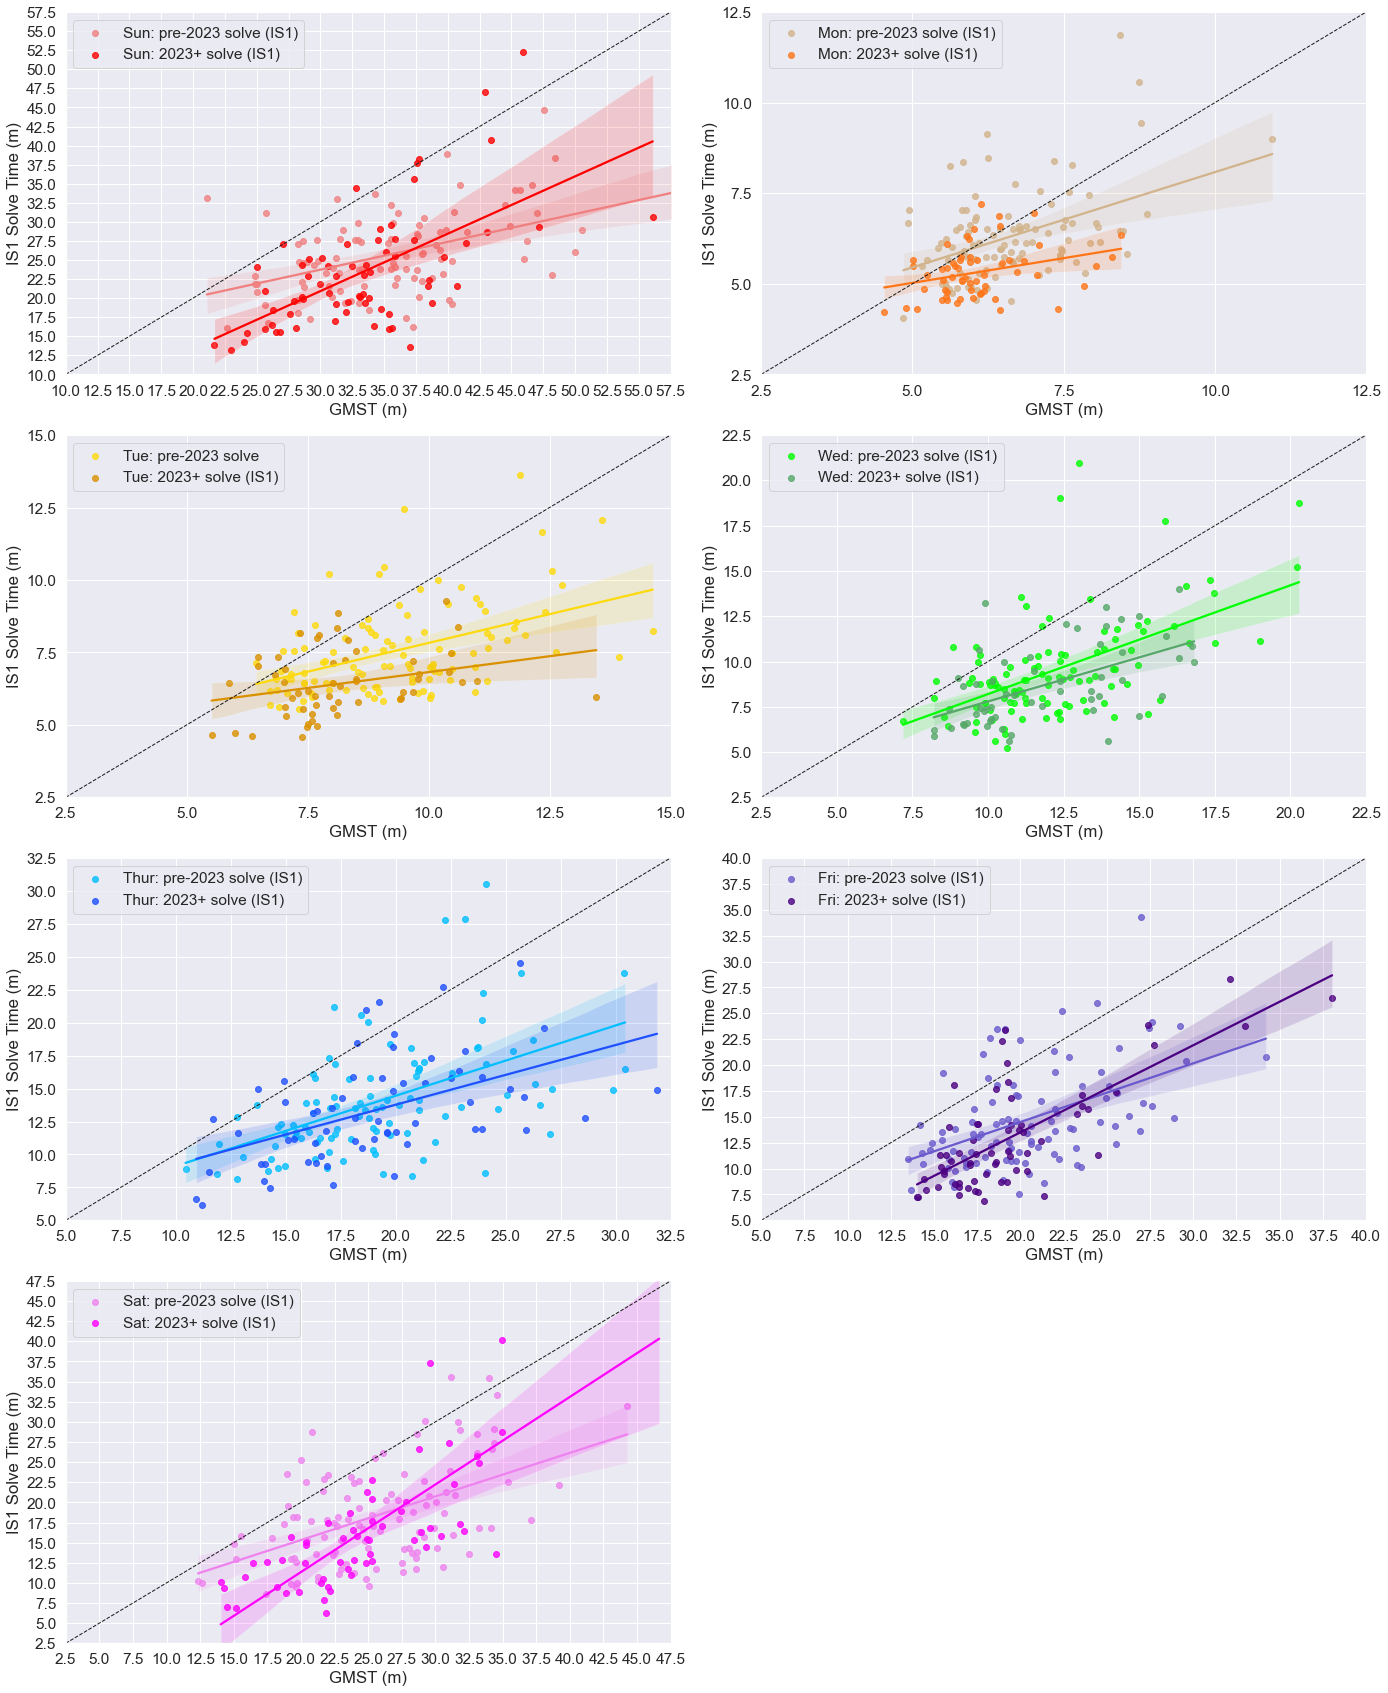

In [91]:
# Scatterplots of individual raw solve times vs global median solve times, per puzzle day

df_IS1 = df_IS1.sort_values(by=['plot_seq'], ascending = True)

sns.set(font_scale=1.4)

df_IS1['plot_seq_map'] = df_IS1['plot_seq'].map({1:'Sun: pre-2023 solve (IS1)', 2:'Sun: 2023+ solve (IS1)', 3:'Mon: pre-2023 solve (IS1)', 4:'Mon: 2023+ solve (IS1)', 5:'Tue: pre-2023 solve', 6:'Tue: 2023+ solve (IS1)', 7:'Wed: pre-2023 solve (IS1)', 8:'Wed: 2023+ solve (IS1)', 9:'Thur: pre-2023 solve (IS1)', 10:'Thur: 2023+ solve (IS1)', 11:'Fri: pre-2023 solve (IS1)', 12:'Fri: 2023+ solve (IS1)', 13:'Sat: pre-2023 solve (IS1)', 14:'Sat: 2023+ solve (IS1)'})

#sequence = {0:'pre-2023 solve', 1:'2023 solve', 2:'pre-2023 solve', 3:'2023 solve', 4:'pre-2023 solve', 5:'2023 solve', 6:'pre-2023 solve', 7:'2023 solve', 8:'pre-2023 solve', 9:'2023 solve', 10:'pre-2023 solve', 11:'2023 solve', 12:'pre-2023 solve', 13:'2023 solve'}

p = sns.lmplot(
    data=df_IS1, x="GMST(m)", y="IST(m)", hue="plot_seq_map", col="DOW", col_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], col_wrap=2, palette=["lightcoral", "red", "tan", "#FF7518", "#FDDA0D", "#da9100", "lime", "g", "deepskyblue", "#1F51FF", "slateblue", "indigo", "violet", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False
).set(title="", xlabel= "GMST (m)",
    ylabel="IS1 Solve Time (m)", xticks = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60], yticks = [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5, 50, 52.5, 55, 57.5, 60]  
)

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

#Adjust subplots individually
p.axes[0].set_ylim((10,57.5))
p.axes[0].set_xlim((10,57.5))
p.axes[1].set_ylim((2.5,12.5))
p.axes[1].set_xlim((2.5,12.5))
p.axes[2].set_ylim((2.5,15))
p.axes[2].set_xlim((2.5,15))
p.axes[3].set_ylim((2.5,22.5))
p.axes[3].set_xlim((2.5,22.5))
p.axes[4].set_ylim((5,32.5))
p.axes[4].set_xlim((5,32.5))
p.axes[5].set_ylim((5, 40))
p.axes[5].set_xlim((5, 40))
p.axes[6].set_ylim((2.5, 47.5))
p.axes[6].set_xlim((2.5, 47.5))

p.axes[0].plot([10, 57.5], [10, 57.5], 'k', linestyle='dashed', linewidth=1)
p.axes[1].plot([2.5, 12.5], [2.5, 12.5], 'k', linestyle='dashed', linewidth=1)
p.axes[2].plot([2.5, 15], [2.5, 15], 'k', linestyle='dashed', linewidth=1)
p.axes[3].plot([2.5, 22.5], [2.5, 22.5], 'k', linestyle='dashed', linewidth=1)
p.axes[4].plot([5, 32.5], [5, 32.5], 'k', linestyle='dashed', linewidth=1)
p.axes[5].plot([5, 40], [5, 40], 'k', linestyle='dashed', linewidth=1)
p.axes[6].plot([2.5, 47.5], [2.5, 47.5], 'k', linestyle='dashed', linewidth=1)

_= p.axes[0].legend()
_= p.axes[1].legend()
_= p.axes[2].legend()
_= p.axes[3].legend()
_= p.axes[4].legend()
_= p.axes[5].legend()
_= p.axes[6].legend()

In [76]:
# Correlations for 2023_2024 for IST vs GMST
df_IS1_2023_2024 = df_IS1.loc[(df_IS1["2023+_solve"] == 1)]
df_Sun = df_IS1_2023_2024.loc[df_IS1_2023_2024["DOW"]==("Sunday")]
df_Mon = df_IS1_2023_2024.loc[df_IS1_2023_2024["DOW"]==("Monday")]
df_Tue = df_IS1_2023_2024.loc[df_IS1_2023_2024["DOW"]==("Tuesday")]
df_Wed = df_IS1_2023_2024.loc[df_IS1_2023_2024["DOW"]==("Wednesday")]
df_Thu = df_IS1_2023_2024.loc[df_IS1_2023_2024["DOW"]==("Thursday")]
df_Fri = df_IS1_2023_2024.loc[df_IS1_2023_2024["DOW"]==("Friday")]
df_Sat = df_IS1_2023_2024.loc[df_IS1_2023_2024["DOW"]==("Saturday")]

print(df_Sun['IST(m)'].corr(df_Sun['GMST(m)']))
print(df_Mon['IST(m)'].corr(df_Mon['GMST(m)']))
print(df_Tue['IST(m)'].corr(df_Tue['GMST(m)']))
print(df_Wed['IST(m)'].corr(df_Wed['GMST(m)']))
print(df_Thu['IST(m)'].corr(df_Thu['GMST(m)']))
print(df_Fri['IST(m)'].corr(df_Fri['GMST(m)']))
print(df_Sat['IST(m)'].corr(df_Sat['GMST(m)']))

0.6125934440235369
0.30648338790045987
0.29055527300654005
0.5483203078383239
0.5066750149524564
0.7403875295799108
0.7818603973569421


In [77]:
# Correlations for pre-2023 for IST vs GMST
df_IS1_pre2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 0)]
df_Sun = df_IS1_pre2023.loc[df_IS1_pre2023["DOW"]==("Sunday")]
df_Mon = df_IS1_pre2023.loc[df_IS1_pre2023["DOW"]==("Monday")]
df_Tue = df_IS1_pre2023.loc[df_IS1_pre2023["DOW"]==("Tuesday")]
df_Wed = df_IS1_pre2023.loc[df_IS1_pre2023["DOW"]==("Wednesday")]
df_Thu = df_IS1_pre2023.loc[df_IS1_pre2023["DOW"]==("Thursday")]
df_Fri = df_IS1_pre2023.loc[df_IS1_pre2023["DOW"]==("Friday")]
df_Sat = df_IS1_pre2023.loc[df_IS1_pre2023["DOW"]==("Saturday")]

print(df_Sun['IST(m)'].corr(df_Sun['GMST(m)']))
print(df_Mon['IST(m)'].corr(df_Mon['GMST(m)']))
print(df_Tue['IST(m)'].corr(df_Tue['GMST(m)']))
print(df_Wed['IST(m)'].corr(df_Wed['GMST(m)']))
print(df_Thu['IST(m)'].corr(df_Thu['GMST(m)']))
print(df_Fri['IST(m)'].corr(df_Fri['GMST(m)']))
print(df_Sat['IST(m)'].corr(df_Sat['GMST(m)']))

0.48628073530256105
0.4402283464346535
0.4572278213945282
0.546469377126607
0.5189329352534164
0.4846952570356605
0.5040307974523484


In [71]:
# Win % for IS1 vs GMS by Puzzle Day: 2023_2024 solves
IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Sun_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Sun_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Mon_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Mon_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Tue_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Tue_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Wed_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Wed_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Thu_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Thu_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Fri_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Fri_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Sat_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Sat_IST_win_pct)

91.17647058823529
83.05084745762711
83.92857142857143
94.64285714285714
88.70967741935483
93.75
94.91525423728814


In [73]:
# IS1 vs GMS by Puzzle Day: pre-2023 solves
IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Sun_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Sun_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Mon_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Mon_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Tue_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Tue_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Wed_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Wed_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Thu_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Thu_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Fri_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Fri_IST_win_pct)

IST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST(m)"] < df_IS1["GMST(m)"])])
GMST_wins = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST(m)"] > df_IS1["GMST(m)"])])
Ties = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IST(m)"] == df_IS1["GMST(m)"])])
Sat_IST_win_pct = (IST_wins/(IST_wins + GMST_wins + Ties))*100
print(Sat_IST_win_pct)

96.90721649484536
63.8095238095238
88.9908256880734
88.07339449541286
91.2621359223301
90.0990099009901
89.62264150943396


In [88]:
# Mean difference for raw IST vs GMST 2023_2024 
df_IS1['IST_raw_Diff_GMST'] = (df_IS1['IST(m)'] - df_IS1['GMST(m)'])

df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')])

mean
           std
mean -8.239266
std   5.369968

In [89]:
# Mean difference for raw IST vs GMST pre2023 
#df_IS1['IST_raw_Diff_GMST'] = (df_IS1['IST(m)'] - df_IS1['GMST(m)'])

df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday"), "IST_raw_Diff_GMST"].agg([('mean', 'std')])

mean
           std
mean -7.296541
std   5.984799

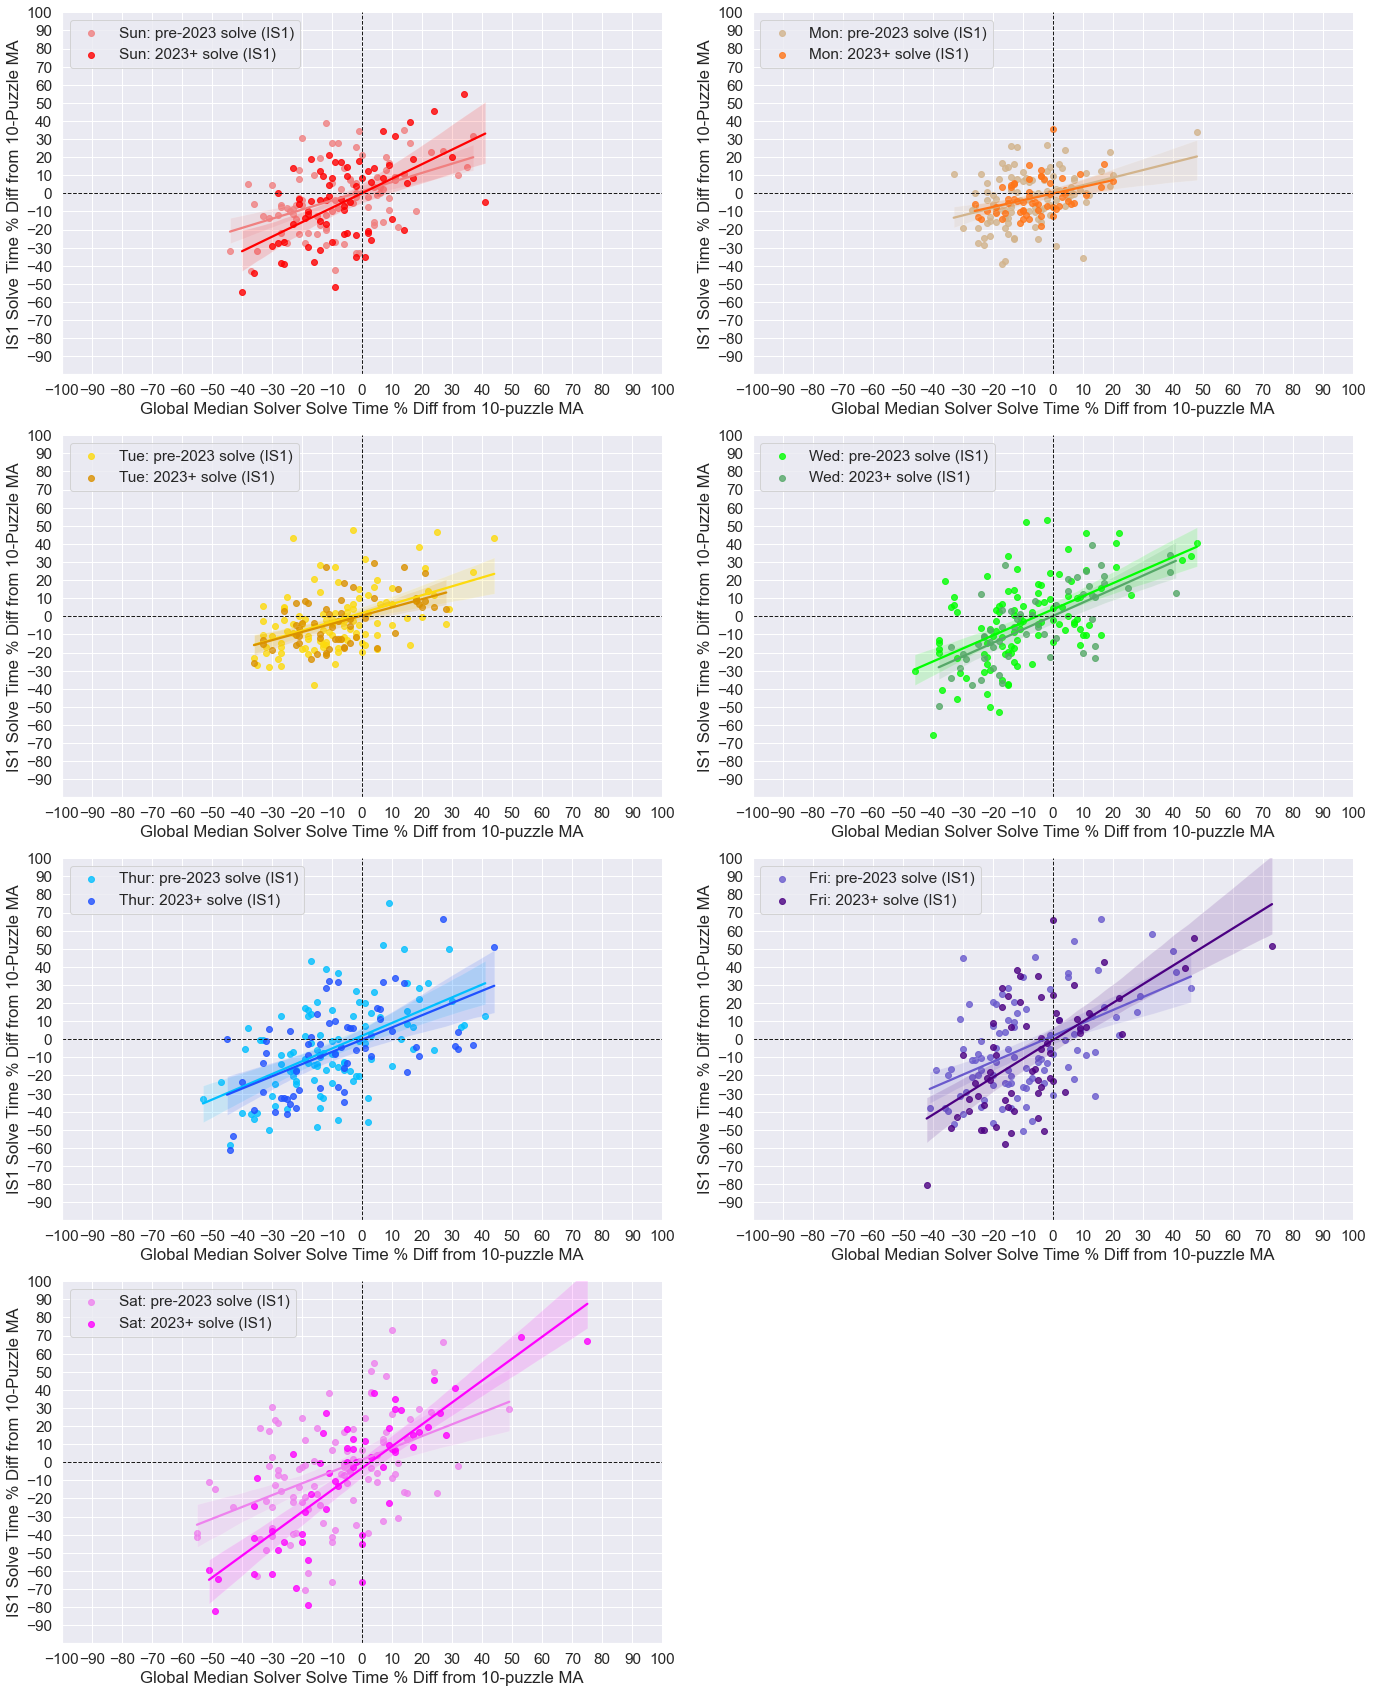

In [92]:
# Scatterplots of difference from 10-puzzle moving average for individual solver vs deviation from 10-puzzle moving average for global median solver, per puzzle day
# This isolates RELATIVE performance for the individual solver on a given puzzle vs their recent performance, and how that relative performance compares to that for the median solver

df_IS1 = df_IS1.sort_values(by=['plot_seq'], ascending = True)

sns.set(font_scale=1.4)

df_IS1['plot_seq_map'] = df_IS1['plot_seq'].map({1:'Sun: pre-2023 solve (IS1)', 2:'Sun: 2023+ solve (IS1)', 3:'Mon: pre-2023 solve (IS1)', 4:'Mon: 2023+ solve (IS1)', 5:'Tue: pre-2023 solve (IS1)', 6:'Tue: 2023+ solve (IS1)', 7:'Wed: pre-2023 solve (IS1)', 8:'Wed: 2023+ solve (IS1)', 9:'Thur: pre-2023 solve (IS1)', 10:'Thur: 2023+ solve (IS1)', 11:'Fri: pre-2023 solve (IS1)', 12:'Fri: 2023+ solve (IS1)', 13:'Sat: pre-2023 solve (IS1)', 14:'Sat: 2023+ solve (IS1)'})

#sequence = {0:'pre-2023 solve', 1:'2023 solve', 2:'pre-2023 solve', 3:'2023 solve', 4:'pre-2023 solve', 5:'2023 solve', 6:'pre-2023 solve', 7:'2023 solve', 8:'pre-2023 solve', 9:'2023 solve', 10:'pre-2023 solve', 11:'2023 solve', 12:'pre-2023 solve', 13:'2023 solve'}

p = sns.lmplot(
    data=df_IS1, x="Diff%_from_10pMA(GMS)", y="IS_Diff%_10pMA", hue="plot_seq_map", col="DOW", col_order=["Sunday", "Monday", "Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], col_wrap=2, palette=["lightcoral", "red", "tan", "#FF7518", "#FDDA0D", "#da9100", "lime", "g", "deepskyblue", "#1F51FF", "slateblue", "indigo", "violet", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False
).set(title="", xlabel= "Global Median Solver Solve Time % Diff from 10-puzzle MA",
    ylabel="IS1 Solve Time % Diff from 10-Puzzle MA", xticks = [-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100], yticks = [-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100]  
)

#Adjust subplots individually
p.axes[0].set_ylim((-100,100))
p.axes[0].set_xlim((-100,100))
p.axes[1].set_ylim((-100,100))
p.axes[1].set_xlim((-100,100))
p.axes[2].set_ylim((-100,100))
p.axes[2].set_xlim((-100,100))
p.axes[3].set_ylim((-100,100))
p.axes[3].set_xlim((-100,100))
p.axes[4].set_ylim((-100,100))
p.axes[4].set_xlim((-100,100))
p.axes[5].set_ylim((-100,100))
p.axes[5].set_xlim((-100,100))
p.axes[6].set_ylim((-100,100))
p.axes[6].set_xlim((-100,100))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

p.axes[0].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[0].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[1].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[1].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[2].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[2].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[3].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[3].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[4].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[4].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[5].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[5].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)
p.axes[6].plot([0, 0], [-100, 100], 'k', linestyle='dashed', linewidth=1)
p.axes[6].plot([-100, 100], [0, 0], 'k', linestyle='dashed', linewidth=1)

_= p.axes[0].legend(loc = 'upper left')
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')

In [105]:
#Quadrant Analysis 2023+ (note: very very rare exact zero difference puzzles are ignored for this calculation)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Upper_Left_pct, Lower_Left_pct, Upper_Right_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Upper_Left_pct, Lower_Left_pct, Upper_Right_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Upper_Left_pct, Lower_Left_pct, Upper_Right_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Upper_Left_pct, Lower_Left_pct, Upper_Right_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Upper_Left_pct, Lower_Left_pct, Upper_Right_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Upper_Left_pct, Lower_Left_pct, Upper_Right_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Upper_Left_pct, Lower_Left_pct, Upper_Right_pct, Lower_Right_pct)

20.8955223880597 47.76119402985074 20.8955223880597 10.44776119402985
23.214285714285715 51.78571428571429 10.714285714285714 14.285714285714285
19.642857142857142 53.57142857142857 21.428571428571427 5.357142857142857
12.5 48.214285714285715 30.357142857142854 8.928571428571429
19.35483870967742 51.61290322580645 16.129032258064516 12.903225806451612
19.672131147540984 55.73770491803278 22.950819672131146 1.639344262295082
14.285714285714285 44.642857142857146 37.5 3.571428571428571


In [106]:
#Quadrant Analysis pre-2023 (note: very very rare exact zero difference puzzles are ignored for this calculation)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Upper_Left_pct, Lower_Left_pct, Upper_Right_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Upper_Left_pct, Lower_Left_pct, Upper_Right_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Upper_Left_pct, Lower_Left_pct, Upper_Right_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Upper_Left_pct, Lower_Left_pct, Upper_Right_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Upper_Left_pct, Lower_Left_pct, Upper_Right_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Upper_Left_pct, Lower_Left_pct, Upper_Right_pct, Lower_Right_pct)

Upper_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Lower_Left = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] < 0)])
Upper_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IS_Diff%_10pMA"] > 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
Lower_Right = len(df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday") & (df_IS1["IS_Diff%_10pMA"] < 0) & (df_IS1["Diff%_from_10pMA(GMS)"] > 0)])
                 
Upper_Left_pct = (Upper_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Left_pct = (Lower_Left/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Upper_Right_pct = (Upper_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
Lower_Right_pct = (Lower_Right/(Upper_Left + Lower_Left + Upper_Right + Lower_Right))*100
print(Upper_Left_pct, Lower_Left_pct, Upper_Right_pct, Lower_Right_pct)

22.340425531914892 45.744680851063826 21.27659574468085 10.638297872340425
26.732673267326735 46.53465346534654 16.831683168316832 9.900990099009901
20.0 53.333333333333336 17.142857142857142 9.523809523809524
26.923076923076923 45.19230769230769 16.346153846153847 11.538461538461538
16.831683168316832 54.45544554455446 21.782178217821784 6.9306930693069315
20.618556701030926 53.608247422680414 18.556701030927837 7.216494845360824
17.475728155339805 50.48543689320388 18.446601941747574 13.592233009708737


In [117]:
# Correlation analysis 2023+

Sun_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Sunday")]
print(Sun_2023['Diff%_from_10pMA(GMS)'].corr(Sun_2023['IS_Diff%_10pMA']))

Mon_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Monday")]
print(Mon_2023['Diff%_from_10pMA(GMS)'].corr(Mon_2023['IS_Diff%_10pMA']))

Tue_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Tuesday")]
print(Tue_2023['Diff%_from_10pMA(GMS)'].corr(Tue_2023['IS_Diff%_10pMA']))

Wed_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Wednesday")]
print(Wed_2023['Diff%_from_10pMA(GMS)'].corr(Wed_2023['IS_Diff%_10pMA']))

Thu_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Thursday")]
print(Thu_2023['Diff%_from_10pMA(GMS)'].corr(Thu_2023['IS_Diff%_10pMA']))

Fri_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Friday")]
print(Fri_2023['Diff%_from_10pMA(GMS)'].corr(Fri_2023['IS_Diff%_10pMA']))

Sat_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 1) & (df_IS1["DOW"] == "Saturday")]
print(Sat_2023['Diff%_from_10pMA(GMS)'].corr(Sat_2023['IS_Diff%_10pMA']))

0.5565930760059012
0.38020081144863904
0.5126922256587839
0.7004882148092738
0.5709837294485318
0.6250582233795517
0.7932459415504974


In [118]:
# Correlation analysis pre-2023

Sun_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Sunday")]
print(Sun_2023['Diff%_from_10pMA(GMS)'].corr(Sun_2023['IS_Diff%_10pMA']))

Mon_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Monday")]
print(Mon_2023['Diff%_from_10pMA(GMS)'].corr(Mon_2023['IS_Diff%_10pMA']))

Tue_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Tuesday")]
print(Tue_2023['Diff%_from_10pMA(GMS)'].corr(Tue_2023['IS_Diff%_10pMA']))

Wed_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Wednesday")]
print(Wed_2023['Diff%_from_10pMA(GMS)'].corr(Wed_2023['IS_Diff%_10pMA']))

Thu_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Thursday")]
print(Thu_2023['Diff%_from_10pMA(GMS)'].corr(Thu_2023['IS_Diff%_10pMA']))

Fri_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Friday")]
print(Fri_2023['Diff%_from_10pMA(GMS)'].corr(Fri_2023['IS_Diff%_10pMA']))

Sat_2023 = df_IS1.loc[(df_IS1["2023+_solve"] == 0) & (df_IS1["DOW"] == "Saturday")]
print(Sat_2023['Diff%_from_10pMA(GMS)'].corr(Sat_2023['IS_Diff%_10pMA']))

0.4668601131990774
0.37569674376500717
0.48476076725492223
0.561453279305008
0.532104017671698
0.5046293662655716
0.44295629089117183


In [107]:
df_IS1.drop(['plot_seq', 'plot_seq_map'], axis=1, inplace=True)

### Constructor Analysis
Which constructors does individual solver 1 (IS1) struggle against? Which ones does IS1 do well against? This analysis is with respect to average deviation from day-specific 10-puzzle moving average per constructor/constructor team (aligns with what we have available for the global median solver). 

In [108]:
# Get stats for Individual Solver
constructor_avgs_IS = df_IS1.groupby(['Constructors'])['IS_Diff%_10pMA'].agg(constructor_mean_IS=(np.mean), puzzle_count_IS=(np.count_nonzero))
constructor_avgs_IS["constructor_mean_IS"] = constructor_avgs_IS["constructor_mean_IS"].round(2)

#Get stats for Global Mean Solver
constructor_avgs_GMT = df_IS1.groupby(['Constructors'])['Diff%_from_10pMA(GMS)'].agg(constructor_mean_GMS=(np.mean), puzzle_count_GMS=(np.count_nonzero))
constructor_avgs_GMT["constructor_mean_GMS"] = constructor_avgs_GMT["constructor_mean_GMS"].round(2)

#Merge Individual and Global Mean stats into single df
constructor_avgs = constructor_avgs_IS.merge(constructor_avgs_GMT, on='Constructors', how='inner')

puzzle_min_threshold = 5 #min number of puzzles in sample for constructor/constructor team to be kept in the analysis 

# Pare down to only constructor(s) with at least n puzzles for which IS1 has completed
constructor_avgs_filter = constructor_avgs.loc[constructor_avgs['puzzle_count_IS'] >= puzzle_min_threshold] 

In [112]:
constructor_avgs_filter.head(35)

constructor_mean_IS  puzzle_count_IS  \
Constructors                                                        
Adam Aaronson                             -14.08              7.0   
Adam Wagner                                 2.17             13.0   
Adrian Johnson                             15.95              5.0   
Aimee Lucido                              -26.49              5.0   
Alex Eaton-Salners                         12.82              9.0   
Barbara Lin                                -3.14              8.0   
Billy Bratton                             -16.74              5.0   
Blake Slonecker                           -11.14              6.0   
Brad Wiegmann                             -11.61              6.0   
Brandon Koppy                              -3.13             12.0   
Bruce Haight                               15.82              8.0   
Byron Walden                               -4.00              8.0   
Damon Gulczynski                            0.22              5.0   
David Distenfeld                           -5.29              7.0   
David Steinberg                           -15.25              9.0   
David Tuffs                                 5.09              6.0   
Drew Schmenner                             -0.58              5.0   
Emily Carroll                              -9.00              6.0   
Enrique Henestroza Anguiano               -23.99              5.0   
Eric Bornstein                            -11.29              7.0   
Erik Agard                                 -3.41              5.0   
Grant Thackray                             -3.35              6.0   
Jeremy Newton                               1.48              5.0   
Joe Deeney                                 -7.15              9.0   
Joe DiPietro                               11.24              5.0   
John Guzzetta                             -14.81              5.0   
John Westwig                               -8.94              5.0   
Joseph Greenbaum                          -15.52              5.0   
Kameron Austin Collins                     15.00             11.0   
Kate Hawkins                               -7.44             10.0   
Kyle Dolan                                 24.59              5.0   
Lynn Lempel                                -4.21              6.0   
Margaret Seikel                           -13.67              5.0   
Matthew Stock                              -7.72              9.0   
Michael Lieberman                          -5.89             11.0   

                             constructor_mean_GMS  puzzle_count_GMS  
Constructors                                                         
Adam Aaronson                              -19.71                 6  
Adam Wagner                                 -8.69                13  
Adrian Johnson                              -8.20                 5  
Aimee Lucido                               -16.40                 5  
Alex Eaton-Salners                           6.33                 9  
Barbara Lin                                 -9.75                 8  
Billy Bratton                              -18.00                 5  
Blake Slonecker                            -10.33                 6  
Brad Wiegmann                                4.83                 5  
Brandon Koppy                               -3.00                12  
Bruce Haight                                16.75                 8  
Byron Walden                                 3.75                 8  
Damon Gulczynski                             3.80                 5  
David Distenfeld                           -14.29                 7  
David Steinberg                            -15.56                 9  
David Tuffs                                -11.17                 6  
Drew Schmenner                              -3.20                 5  
Emily Carroll                               -0.83                 6  
Enrique Henestroza Anguiano                -20.60                 5  
Eric 

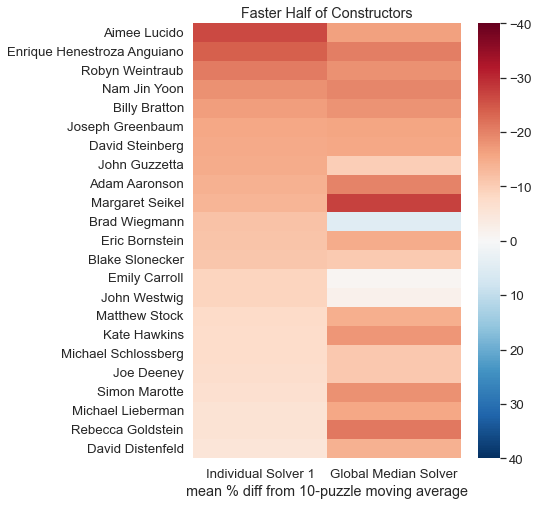

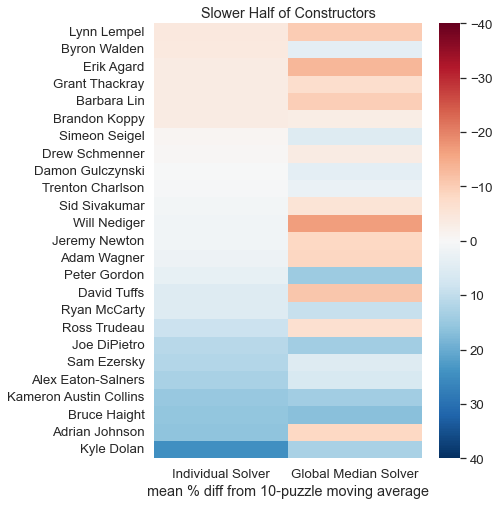

In [113]:
# Construct Heat Map sorted by fastest constructor relative to Individual solver 10 puzzle moving average to slowest

#Remove puzzle ns columns and sort for heatmapping
avgs = constructor_avgs_filter[["constructor_mean_IS", "constructor_mean_GMS"]]
avgs = avgs.sort_values(by=['constructor_mean_IS'], ascending = True)

first_half_end = int((len(avgs)/2)-1)
avgs_end = int(len(avgs))
first_half = avgs[0:first_half_end]
second_half = avgs[(first_half_end+1):avgs_end]

first_half = first_half.sort_values(by=['constructor_mean_IS'], ascending = True)
plt.figure(figsize=(6,8))
sns.set(font_scale=1.2)
ax = sns.heatmap(first_half, xticklabels=['Individual Solver 1', 'Global Median Solver'], cmap="RdBu", vmin=-40, vmax=40, yticklabels=True)
plt.gcf().axes[1].invert_yaxis() #flip color bar to show fastest at the top
plt.xlabel('mean % diff from 10-puzzle moving average')
plt.ylabel('')
plt.title("Faster Half of Constructors")
plt.show()

second_half = second_half.sort_values(by=['constructor_mean_IS'], ascending = True)
plt.figure(figsize=(6,8))
sns.set(font_scale=1.2)
ax2 = sns.heatmap(second_half, xticklabels=['Individual Solver', 'Global Median Solver'], cmap="RdBu", vmin=-40, vmax=40, yticklabels=True)
plt.gcf().axes[1].invert_yaxis() #flip color bar to show fastest at the top
plt.xlabel('mean % diff from 10-puzzle moving average')
plt.ylabel('')
plt.title("Slower Half of Constructors")
plt.show()

In [120]:
constructor_avgs_filter[["constructor_mean_IS"]].agg(['min', 'max'])
#constructor_avgs_filter[["constructor_mean_GMS"]].agg(['min', 'max'])

constructor_mean_IS
min               -26.49
max                24.59

### Completion Time of Day Analysis

In [121]:
IS1_df2 = df_IS1.copy()

In [122]:
#Creates a column where Individual Solver completion timestamps are binned to the hour in 24-hour cycle
IS1_df2['Comp_Hr'] = IS1_df2['Comp_Date'].dt.hour
IS1_df2['Comp_Hr'].value_counts()
IS1_df2['Comp_Hr']= IS1_df2['Comp_Hr'].astype('int64')
IS1_df2 = IS1_df2.sort_values('Comp_Hr')

In [ ]:
IS1_df2.info()

In [123]:
col = IS1_df2.pop('Comp_Hr')
IS1_df2.insert(9, col.name, col)

In [124]:
# Construct numerical categories in desired plotting sequence for combinations of puzzle day and pre-2023 or 2023+

IS1_df2.loc[(IS1_df2["DOW"] == "Sunday") & (IS1_df2["2023+_solve"] == 0) , "plot_seq"] = 1 
IS1_df2.loc[(IS1_df2["DOW"] == "Sunday") & (IS1_df2["2023+_solve"] == 1) , "plot_seq"] = 2
IS1_df2.loc[(IS1_df2["DOW"] == "Monday") & (IS1_df2["2023+_solve"] == 0) , "plot_seq"] = 3 
IS1_df2.loc[(IS1_df2["DOW"] == "Monday") & (IS1_df2["2023+_solve"] == 1) , "plot_seq"] = 4
IS1_df2.loc[(IS1_df2["DOW"] == "Tuesday") & (IS1_df2["2023+_solve"] == 0) , "plot_seq"] = 5 
IS1_df2.loc[(IS1_df2["DOW"] == "Tuesday") & (IS1_df2["2023+_solve"] == 1) , "plot_seq"] = 6
IS1_df2.loc[(IS1_df2["DOW"] == "Wednesday") & (IS1_df2["2023+_solve"] == 0) , "plot_seq"] = 7 
IS1_df2.loc[(IS1_df2["DOW"] == "Wednesday") & (IS1_df2["2023+_solve"] == 1) , "plot_seq"] = 8
IS1_df2.loc[(IS1_df2["DOW"] == "Thursday") & (IS1_df2["2023+_solve"] == 0) , "plot_seq"] = 9 
IS1_df2.loc[(IS1_df2["DOW"] == "Thursday") & (IS1_df2["2023+_solve"] == 1) , "plot_seq"] = 10
IS1_df2.loc[(IS1_df2["DOW"] == "Friday") & (IS1_df2["2023+_solve"] == 0) , "plot_seq"] = 11 
IS1_df2.loc[(IS1_df2["DOW"] == "Friday") & (IS1_df2["2023+_solve"] == 1) , "plot_seq"] = 12
IS1_df2.loc[(IS1_df2["DOW"] == "Saturday") & (IS1_df2["2023+_solve"] == 0) , "plot_seq"] = 13 
IS1_df2.loc[(IS1_df2["DOW"] == "Saturday") & (IS1_df2["2023+_solve"] == 1) , "plot_seq"] = 14

In [125]:
# For subplot collapsed across puzzle days for puzzle completions by hour of day, make a copy of all data, label it '0' and concatenate with
#main df

IS1_df2_copy = IS1_df2.copy()
IS1_df2_copy["DOW_num"] = 0

IS1_df2a = pd.concat([IS1_df2, IS1_df2_copy],ignore_index=True)

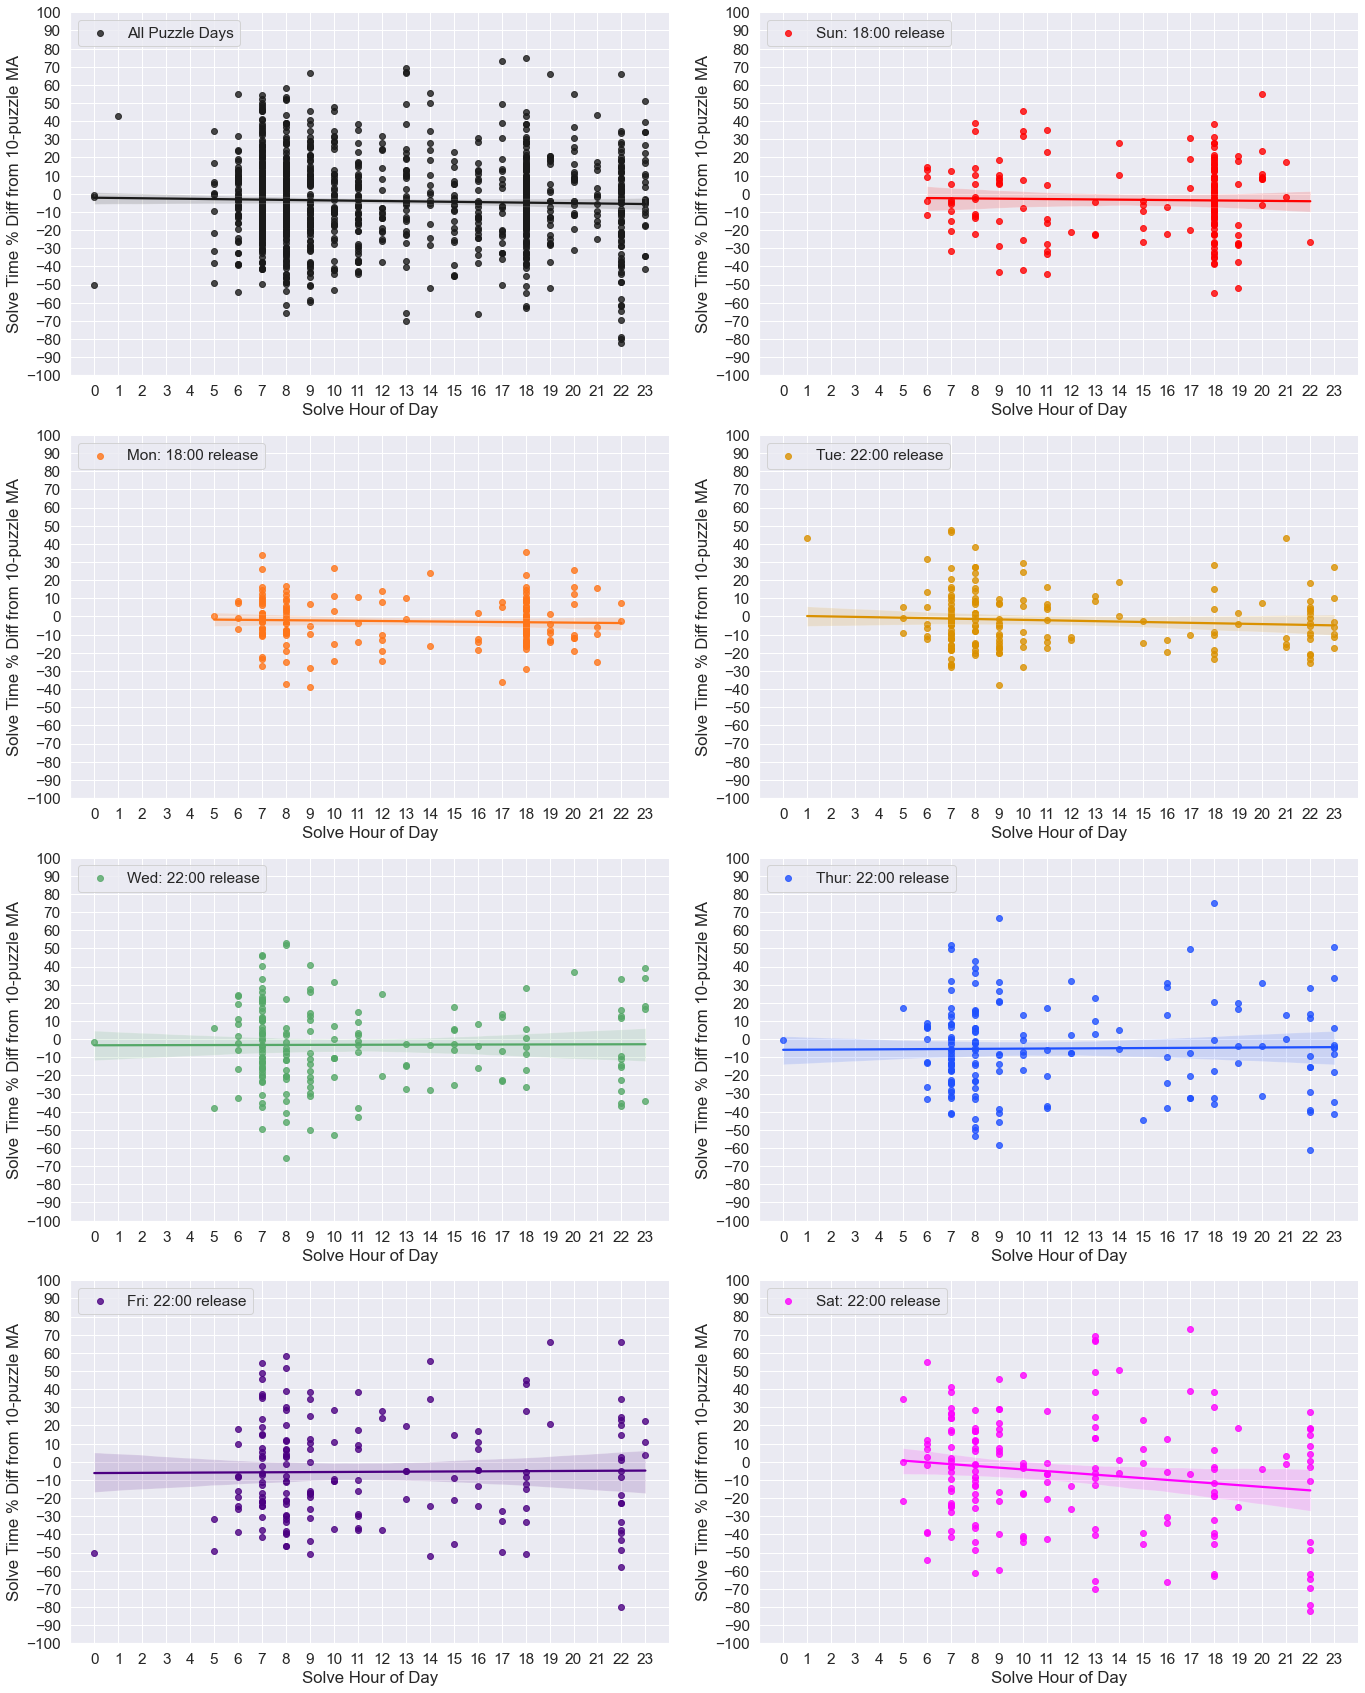

In [126]:
# Individual Solver 1 (IS1) Puzzle Completions by Solve Hour

IS1_df2a = IS1_df2a.sort_values(by=['DOW_num'], ascending = True)

IS1_df2a['plot_seq_map'] = IS1_df2a['DOW_num'].map({0: 'All Puzzle Days', 1:'Sun: 18:00 release', 2:'Mon: 18:00 release', 3:'Tue: 22:00 release', 4:'Wed: 22:00 release', 5: 'Thur: 22:00 release', 6:'Fri: 22:00 release', 7:'Sat: 22:00 release'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df2a, x="Comp_Hr", y="IS_Diff%_10pMA", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], col_wrap=2, palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False
).set(title="", xlabel= "Solve Hour of Day",
    ylabel="Solve Time % Diff from 10-puzzle MA", yticks = [-100,-90,-80,-70,-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60,70,80,90,100], xticks = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]  
)

#Adjust subplots individually
p.axes[0].set_ylim((-100,100))
p.axes[0].set_xlim((-1,24))
p.axes[1].set_ylim((-100,100))
p.axes[1].set_xlim((-1,24))
p.axes[2].set_ylim((-100,100))
p.axes[2].set_xlim((-1,24))
p.axes[3].set_ylim((-100,100))
p.axes[3].set_xlim((-1,24))
p.axes[4].set_ylim((-100,100))
p.axes[4].set_xlim((-1,24))
p.axes[5].set_ylim((-100,100))
p.axes[5].set_xlim((-1,24))
p.axes[6].set_ylim((-100,100))
p.axes[6].set_xlim((-1,24))
p.axes[7].set_ylim((-100,100))
p.axes[7].set_xlim((-1,24))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

IS1_df2a.drop(['plot_seq_map'], axis=1, inplace=True)

### Puzzle and Answer-Features Correlation to Solve Times

In [127]:
# Make a deep copy of individual solver df
IS1_df3 = IS1_df2.copy()

In [ ]:
IS1_df3.info()

Create a few new features for day-specific weighted solver past performance to use as frame of reference for the puzzle and answer-specific correlations

In [128]:
#IS_pds_l10_dw
#Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for the individual solver over the previous 10 puzzles

IS1_df3 = IS1_df3.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

IS1_df3["IS_pds_l10_dw_1"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-1)*w[0]
IS1_df3["IS_pds_l10_dw_2"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-2)*w[1]
IS1_df3["IS_pds_l10_dw_3"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-3)*w[2]
IS1_df3["IS_pds_l10_dw_4"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-4)*w[3]
IS1_df3["IS_pds_l10_dw_5"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-5)*w[4]
IS1_df3["IS_pds_l10_dw_6"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-6)*w[5]
IS1_df3["IS_pds_l10_dw_7"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-7)*w[6]
IS1_df3["IS_pds_l10_dw_8"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-8)*w[7]
IS1_df3["IS_pds_l10_dw_9"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-9)*w[8]
IS1_df3["IS_pds_l10_dw_10"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-10)*w[9]

IS1_df3["IS_pds_l10_dw_1_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-1)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-1))*w[0]
IS1_df3["IS_pds_l10_dw_2_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-2)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-2))*w[1]
IS1_df3["IS_pds_l10_dw_3_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-3)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-3))*w[2]
IS1_df3["IS_pds_l10_dw_4_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-4)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-4))*w[3]
IS1_df3["IS_pds_l10_dw_5_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-5)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-5))*w[4]
IS1_df3["IS_pds_l10_dw_6_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-6)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-6))*w[5]
IS1_df3["IS_pds_l10_dw_7_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-7)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-7))*w[6]
IS1_df3["IS_pds_l10_dw_8_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-8)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-8))*w[7]
IS1_df3["IS_pds_l10_dw_9_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-9)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-9))*w[8]
IS1_df3["IS_pds_l10_dw_10_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-10)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-10))*w[9]

IS1_df3["IS_pds_l10_ws"] = IS1_df3[["IS_pds_l10_dw_1", "IS_pds_l10_dw_2", "IS_pds_l10_dw_3", "IS_pds_l10_dw_4", "IS_pds_l10_dw_5", "IS_pds_l10_dw_6", "IS_pds_l10_dw_7", "IS_pds_l10_dw_8", "IS_pds_l10_dw_9", "IS_pds_l10_dw_10"]].sum(axis=1)
IS1_df3["IS_pds_l10_ws_ct"] = IS1_df3[["IS_pds_l10_dw_1_ct", "IS_pds_l10_dw_2_ct", "IS_pds_l10_dw_3_ct", "IS_pds_l10_dw_4_ct", "IS_pds_l10_dw_5_ct", "IS_pds_l10_dw_6_ct", "IS_pds_l10_dw_7_ct", "IS_pds_l10_dw_8_ct", "IS_pds_l10_dw_9_ct", "IS_pds_l10_dw_10_ct"]].sum(axis=1)
IS1_df3["IS_pds_l10_dw"] = IS1_df3["IS_pds_l10_ws"]/IS1_df3["IS_pds_l10_ws_ct"]

# Deleting transient columns
IS1_df3 = IS1_df3.drop(["IS_pds_l10_dw_1", "IS_pds_l10_dw_2", "IS_pds_l10_dw_3", "IS_pds_l10_dw_4", "IS_pds_l10_dw_5", "IS_pds_l10_dw_6", "IS_pds_l10_dw_7", "IS_pds_l10_dw_8", "IS_pds_l10_dw_9", "IS_pds_l10_dw_10", "IS_pds_l10_dw_1_ct", "IS_pds_l10_dw_2_ct", "IS_pds_l10_dw_3_ct", "IS_pds_l10_dw_4_ct", "IS_pds_l10_dw_5_ct", "IS_pds_l10_dw_6_ct", "IS_pds_l10_dw_7_ct", "IS_pds_l10_dw_8_ct", "IS_pds_l10_dw_9_ct", "IS_pds_l10_dw_10_ct", "IS_pds_l10_ws", "IS_pds_l10_ws_ct"], axis = 1)

In [129]:
#IS_pds_l20_dw
#Provides decay-weighted(dw), puzzle day-specific (pds) mean solve time performance for the individual solver over the previous 20 puzzles

IS1_df3 = IS1_df3.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

w = [20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

IS1_df3["IS_pds_l20_dw_1"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-1)*w[0]
IS1_df3["IS_pds_l20_dw_2"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-2)*w[1]
IS1_df3["IS_pds_l20_dw_3"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-3)*w[2]
IS1_df3["IS_pds_l20_dw_4"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-4)*w[3]
IS1_df3["IS_pds_l20_dw_5"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-5)*w[4]
IS1_df3["IS_pds_l20_dw_6"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-6)*w[5]
IS1_df3["IS_pds_l20_dw_7"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-7)*w[6]
IS1_df3["IS_pds_l20_dw_8"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-8)*w[7]
IS1_df3["IS_pds_l20_dw_9"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-9)*w[8]
IS1_df3["IS_pds_l20_dw_10"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-10)*w[9]
IS1_df3["IS_pds_l20_dw_11"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-11)*w[10]
IS1_df3["IS_pds_l20_dw_12"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-12)*w[11]
IS1_df3["IS_pds_l20_dw_13"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-13)*w[12]
IS1_df3["IS_pds_l20_dw_14"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-14)*w[13]
IS1_df3["IS_pds_l20_dw_15"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-15)*w[14]
IS1_df3["IS_pds_l20_dw_16"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-16)*w[15]
IS1_df3["IS_pds_l20_dw_17"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-17)*w[16]
IS1_df3["IS_pds_l20_dw_18"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-18)*w[17]
IS1_df3["IS_pds_l20_dw_19"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-19)*w[18]
IS1_df3["IS_pds_l20_dw_20"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-20)*w[19]

IS1_df3["IS_pds_l20_dw_1_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-1)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-1))*w[0]
IS1_df3["IS_pds_l20_dw_2_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-2)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-2))*w[1]
IS1_df3["IS_pds_l20_dw_3_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-3)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-3))*w[2]
IS1_df3["IS_pds_l20_dw_4_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-4)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-4))*w[3]
IS1_df3["IS_pds_l20_dw_5_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-5)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-5))*w[4]
IS1_df3["IS_pds_l20_dw_6_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-6)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-6))*w[5]
IS1_df3["IS_pds_l20_dw_7_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-7)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-7))*w[6]
IS1_df3["IS_pds_l20_dw_8_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-8)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-8))*w[7]
IS1_df3["IS_pds_l20_dw_9_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-9)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-9))*w[8]
IS1_df3["IS_pds_l20_dw_10_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-10)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-10))*w[9]
IS1_df3["IS_pds_l20_dw_11_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-11)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-11))*w[10]
IS1_df3["IS_pds_l20_dw_12_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-12)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-12))*w[11]
IS1_df3["IS_pds_l20_dw_13_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-13)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-13))*w[12]
IS1_df3["IS_pds_l20_dw_14_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-14)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-14))*w[13]
IS1_df3["IS_pds_l20_dw_15_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-15)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-15))*w[14]
IS1_df3["IS_pds_l20_dw_16_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-16)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-16))*w[15]
IS1_df3["IS_pds_l20_dw_17_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-17)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-17))*w[16]
IS1_df3["IS_pds_l20_dw_18_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-18)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-18))*w[17]
IS1_df3["IS_pds_l20_dw_19_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-19)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-19))*w[18]
IS1_df3["IS_pds_l20_dw_20_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-20)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-20))*w[19]

IS1_df3["IS_pds_l20_ws"] = IS1_df3[["IS_pds_l20_dw_1", "IS_pds_l20_dw_2", "IS_pds_l20_dw_3", "IS_pds_l20_dw_4", "IS_pds_l20_dw_5", "IS_pds_l20_dw_6", "IS_pds_l20_dw_7", "IS_pds_l20_dw_8", "IS_pds_l20_dw_9", "IS_pds_l20_dw_10", "IS_pds_l20_dw_11", "IS_pds_l20_dw_12", "IS_pds_l20_dw_13", "IS_pds_l20_dw_14", "IS_pds_l20_dw_15", "IS_pds_l20_dw_16", "IS_pds_l20_dw_17", "IS_pds_l20_dw_18", "IS_pds_l20_dw_19", "IS_pds_l20_dw_20"]].sum(axis=1)
IS1_df3["IS_pds_l20_ws_ct"] = IS1_df3[["IS_pds_l20_dw_1_ct", "IS_pds_l20_dw_2_ct", "IS_pds_l20_dw_3_ct", "IS_pds_l20_dw_4_ct", "IS_pds_l20_dw_5_ct", "IS_pds_l20_dw_6_ct", "IS_pds_l20_dw_7_ct", "IS_pds_l20_dw_8_ct", "IS_pds_l20_dw_9_ct", "IS_pds_l20_dw_10_ct", "IS_pds_l20_dw_11_ct", "IS_pds_l20_dw_12_ct", "IS_pds_l20_dw_13_ct", "IS_pds_l20_dw_14_ct", "IS_pds_l20_dw_15_ct", "IS_pds_l20_dw_16_ct", "IS_pds_l20_dw_17_ct", "IS_pds_l20_dw_18_ct", "IS_pds_l20_dw_19_ct", "IS_pds_l20_dw_20_ct"]].sum(axis=1)
IS1_df3["IS_pds_l20_dw"] = IS1_df3["IS_pds_l20_ws"]/IS1_df3["IS_pds_l20_ws_ct"]

# Deleting transient columns
IS1_df3 = IS1_df3.drop(["IS_pds_l20_dw_1", "IS_pds_l20_dw_2", "IS_pds_l20_dw_3", "IS_pds_l20_dw_4", "IS_pds_l20_dw_5", "IS_pds_l20_dw_6", "IS_pds_l20_dw_7", "IS_pds_l20_dw_8", "IS_pds_l20_dw_9", "IS_pds_l20_dw_10", "IS_pds_l20_dw_11", "IS_pds_l20_dw_12", "IS_pds_l20_dw_13", "IS_pds_l20_dw_14", "IS_pds_l20_dw_15", "IS_pds_l20_dw_16", "IS_pds_l20_dw_17", "IS_pds_l20_dw_18", "IS_pds_l20_dw_19", "IS_pds_l20_dw_20", "IS_pds_l20_dw_1_ct", "IS_pds_l20_dw_2_ct", "IS_pds_l20_dw_3_ct", "IS_pds_l20_dw_4_ct", "IS_pds_l20_dw_5_ct", "IS_pds_l20_dw_6_ct", "IS_pds_l20_dw_7_ct", "IS_pds_l20_dw_8_ct", "IS_pds_l20_dw_9_ct", "IS_pds_l20_dw_10_ct", "IS_pds_l20_dw_11_ct", "IS_pds_l20_dw_12_ct", "IS_pds_l20_dw_13_ct", "IS_pds_l20_dw_14_ct", "IS_pds_l20_dw_15_ct", "IS_pds_l20_dw_16_ct", "IS_pds_l20_dw_17_ct", "IS_pds_l20_dw_18_ct", "IS_pds_l20_dw_19_ct", "IS_pds_l20_dw_20_ct", "IS_pds_l20_ws", "IS_pds_l20_ws_ct"], axis = 1)

In [130]:
#IS_pds_l10_nndw
#Provides NON decay-weighted(ndw), puzzle day-specific (pds) mean solve time performance for the individual solver over the previous 10 puzzles

IS1_df3 = IS1_df3.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

w = [1,1,1,1,1,1,1,1,1,1] #weight assigned to puzzle (equal for this variant)

IS1_df3["IS_pds_l10_ndw_1"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-1)*w[0]
IS1_df3["IS_pds_l10_ndw_2"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-2)*w[1]
IS1_df3["IS_pds_l10_ndw_3"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-3)*w[2]
IS1_df3["IS_pds_l10_ndw_4"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-4)*w[3]
IS1_df3["IS_pds_l10_ndw_5"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-5)*w[4]
IS1_df3["IS_pds_l10_ndw_6"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-6)*w[5]
IS1_df3["IS_pds_l10_ndw_7"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-7)*w[6]
IS1_df3["IS_pds_l10_ndw_8"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-8)*w[7]
IS1_df3["IS_pds_l10_ndw_9"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-9)*w[8]
IS1_df3["IS_pds_l10_ndw_10"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-10)*w[9]

IS1_df3["IS_pds_l10_ndw_1_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-1)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-1))*w[0]
IS1_df3["IS_pds_l10_ndw_2_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-2)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-2))*w[1]
IS1_df3["IS_pds_l10_ndw_3_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-3)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-3))*w[2]
IS1_df3["IS_pds_l10_ndw_4_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-4)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-4))*w[3]
IS1_df3["IS_pds_l10_ndw_5_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-5)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-5))*w[4]
IS1_df3["IS_pds_l10_ndw_6_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-6)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-6))*w[5]
IS1_df3["IS_pds_l10_ndw_7_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-7)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-7))*w[6]
IS1_df3["IS_pds_l10_ndw_8_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-8)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-8))*w[7]
IS1_df3["IS_pds_l10_ndw_9_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-9)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-9))*w[8]
IS1_df3["IS_pds_l10_ndw_10_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-10)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-10))*w[9]

IS1_df3["IS_pds_l10_ws"] = IS1_df3[["IS_pds_l10_ndw_1", "IS_pds_l10_ndw_2", "IS_pds_l10_ndw_3", "IS_pds_l10_ndw_4", "IS_pds_l10_ndw_5", "IS_pds_l10_ndw_6", "IS_pds_l10_ndw_7", "IS_pds_l10_ndw_8", "IS_pds_l10_ndw_9", "IS_pds_l10_ndw_10"]].sum(axis=1)
IS1_df3["IS_pds_l10_ws_ct"] = IS1_df3[["IS_pds_l10_ndw_1_ct", "IS_pds_l10_ndw_2_ct", "IS_pds_l10_ndw_3_ct", "IS_pds_l10_ndw_4_ct", "IS_pds_l10_ndw_5_ct", "IS_pds_l10_ndw_6_ct", "IS_pds_l10_ndw_7_ct", "IS_pds_l10_ndw_8_ct", "IS_pds_l10_ndw_9_ct", "IS_pds_l10_ndw_10_ct"]].sum(axis=1)
IS1_df3["IS_pds_l10_ndw"] = IS1_df3["IS_pds_l10_ws"]/IS1_df3["IS_pds_l10_ws_ct"]

# Deleting transient columns
IS1_df3 = IS1_df3.drop(["IS_pds_l10_ndw_1", "IS_pds_l10_ndw_2", "IS_pds_l10_ndw_3", "IS_pds_l10_ndw_4", "IS_pds_l10_ndw_5", "IS_pds_l10_ndw_6", "IS_pds_l10_ndw_7", "IS_pds_l10_ndw_8", "IS_pds_l10_ndw_9", "IS_pds_l10_ndw_10", "IS_pds_l10_ndw_1_ct", "IS_pds_l10_ndw_2_ct", "IS_pds_l10_ndw_3_ct", "IS_pds_l10_ndw_4_ct", "IS_pds_l10_ndw_5_ct", "IS_pds_l10_ndw_6_ct", "IS_pds_l10_ndw_7_ct", "IS_pds_l10_ndw_8_ct", "IS_pds_l10_ndw_9_ct", "IS_pds_l10_ndw_10_ct", "IS_pds_l10_ws", "IS_pds_l10_ws_ct"], axis = 1)

In [131]:
#IS_pds_l20_ndw
#Provides NON decay-weighted(ndw), puzzle day-specific (pds) mean solve time performance for the individual solver over the previous 20 puzzles

IS1_df3 = IS1_df3.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

w = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1] #weight assigned to puzzle

IS1_df3["IS_pds_l20_ndw_1"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-1)*w[0]
IS1_df3["IS_pds_l20_ndw_2"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-2)*w[1]
IS1_df3["IS_pds_l20_ndw_3"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-3)*w[2]
IS1_df3["IS_pds_l20_ndw_4"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-4)*w[3]
IS1_df3["IS_pds_l20_ndw_5"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-5)*w[4]
IS1_df3["IS_pds_l20_ndw_6"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-6)*w[5]
IS1_df3["IS_pds_l20_ndw_7"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-7)*w[6]
IS1_df3["IS_pds_l20_ndw_8"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-8)*w[7]
IS1_df3["IS_pds_l20_ndw_9"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-9)*w[8]
IS1_df3["IS_pds_l20_ndw_10"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-10)*w[9]
IS1_df3["IS_pds_l20_ndw_11"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-11)*w[10]
IS1_df3["IS_pds_l20_ndw_12"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-12)*w[11]
IS1_df3["IS_pds_l20_ndw_13"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-13)*w[12]
IS1_df3["IS_pds_l20_ndw_14"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-14)*w[13]
IS1_df3["IS_pds_l20_ndw_15"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-15)*w[14]
IS1_df3["IS_pds_l20_ndw_16"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-16)*w[15]
IS1_df3["IS_pds_l20_ndw_17"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-17)*w[16]
IS1_df3["IS_pds_l20_ndw_18"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-18)*w[17]
IS1_df3["IS_pds_l20_ndw_19"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-19)*w[18]
IS1_df3["IS_pds_l20_ndw_20"] = IS1_df3.groupby(['DOW'])['IST(m)'].shift(-20)*w[19]

IS1_df3["IS_pds_l20_ndw_1_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-1)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-1))*w[0]
IS1_df3["IS_pds_l20_ndw_2_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-2)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-2))*w[1]
IS1_df3["IS_pds_l20_ndw_3_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-3)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-3))*w[2]
IS1_df3["IS_pds_l20_ndw_4_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-4)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-4))*w[3]
IS1_df3["IS_pds_l20_ndw_5_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-5)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-5))*w[4]
IS1_df3["IS_pds_l20_ndw_6_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-6)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-6))*w[5]
IS1_df3["IS_pds_l20_ndw_7_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-7)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-7))*w[6]
IS1_df3["IS_pds_l20_ndw_8_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-8)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-8))*w[7]
IS1_df3["IS_pds_l20_ndw_9_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-9)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-9))*w[8]
IS1_df3["IS_pds_l20_ndw_10_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-10)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-10))*w[9]
IS1_df3["IS_pds_l20_ndw_11_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-11)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-11))*w[10]
IS1_df3["IS_pds_l20_ndw_12_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-12)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-12))*w[11]
IS1_df3["IS_pds_l20_ndw_13_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-13)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-13))*w[12]
IS1_df3["IS_pds_l20_ndw_14_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-14)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-14))*w[13]
IS1_df3["IS_pds_l20_ndw_15_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-15)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-15))*w[14]
IS1_df3["IS_pds_l20_ndw_16_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-16)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-16))*w[15]
IS1_df3["IS_pds_l20_ndw_17_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-17)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-17))*w[16]
IS1_df3["IS_pds_l20_ndw_18_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-18)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-18))*w[17]
IS1_df3["IS_pds_l20_ndw_19_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-19)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-19))*w[18]
IS1_df3["IS_pds_l20_ndw_20_ct"] = (IS1_df3.groupby(['DOW'])['IST(m)'].shift(-20)/IS1_df3.groupby(['DOW'])['IST(m)'].shift(-20))*w[19]

IS1_df3["IS_pds_l20_ws"] = IS1_df3[["IS_pds_l20_ndw_1", "IS_pds_l20_ndw_2", "IS_pds_l20_ndw_3", "IS_pds_l20_ndw_4", "IS_pds_l20_ndw_5", "IS_pds_l20_ndw_6", "IS_pds_l20_ndw_7", "IS_pds_l20_ndw_8", "IS_pds_l20_ndw_9", "IS_pds_l20_ndw_10", "IS_pds_l20_ndw_11", "IS_pds_l20_ndw_12", "IS_pds_l20_ndw_13", "IS_pds_l20_ndw_14", "IS_pds_l20_ndw_15", "IS_pds_l20_ndw_16", "IS_pds_l20_ndw_17", "IS_pds_l20_ndw_18", "IS_pds_l20_ndw_19", "IS_pds_l20_ndw_20"]].sum(axis=1)
IS1_df3["IS_pds_l20_ws_ct"] = IS1_df3[["IS_pds_l20_ndw_1_ct", "IS_pds_l20_ndw_2_ct", "IS_pds_l20_ndw_3_ct", "IS_pds_l20_ndw_4_ct", "IS_pds_l20_ndw_5_ct", "IS_pds_l20_ndw_6_ct", "IS_pds_l20_ndw_7_ct", "IS_pds_l20_ndw_8_ct", "IS_pds_l20_ndw_9_ct", "IS_pds_l20_ndw_10_ct", "IS_pds_l20_ndw_11_ct", "IS_pds_l20_ndw_12_ct", "IS_pds_l20_ndw_13_ct", "IS_pds_l20_ndw_14_ct", "IS_pds_l20_ndw_15_ct", "IS_pds_l20_ndw_16_ct", "IS_pds_l20_ndw_17_ct", "IS_pds_l20_ndw_18_ct", "IS_pds_l20_ndw_19_ct", "IS_pds_l20_ndw_20_ct"]].sum(axis=1)
IS1_df3["IS_pds_l20_ndw"] = IS1_df3["IS_pds_l20_ws"]/IS1_df3["IS_pds_l20_ws_ct"]

# Deleting transient columns
IS1_df3 = IS1_df3.drop(["IS_pds_l20_ndw_1", "IS_pds_l20_ndw_2", "IS_pds_l20_ndw_3", "IS_pds_l20_ndw_4", "IS_pds_l20_ndw_5", "IS_pds_l20_ndw_6", "IS_pds_l20_ndw_7", "IS_pds_l20_ndw_8", "IS_pds_l20_ndw_9", "IS_pds_l20_ndw_10", "IS_pds_l20_ndw_11", "IS_pds_l20_ndw_12", "IS_pds_l20_ndw_13", "IS_pds_l20_ndw_14", "IS_pds_l20_ndw_15", "IS_pds_l20_ndw_16", "IS_pds_l20_ndw_17", "IS_pds_l20_ndw_18", "IS_pds_l20_ndw_19", "IS_pds_l20_ndw_20", "IS_pds_l20_ndw_1_ct", "IS_pds_l20_ndw_2_ct", "IS_pds_l20_ndw_3_ct", "IS_pds_l20_ndw_4_ct", "IS_pds_l20_ndw_5_ct", "IS_pds_l20_ndw_6_ct", "IS_pds_l20_ndw_7_ct", "IS_pds_l20_ndw_8_ct", "IS_pds_l20_ndw_9_ct", "IS_pds_l20_ndw_10_ct", "IS_pds_l20_ndw_11_ct", "IS_pds_l20_ndw_12_ct", "IS_pds_l20_ndw_13_ct", "IS_pds_l20_ndw_14_ct", "IS_pds_l20_ndw_15_ct", "IS_pds_l20_ndw_16_ct", "IS_pds_l20_ndw_17_ct", "IS_pds_l20_ndw_18_ct", "IS_pds_l20_ndw_19_ct", "IS_pds_l20_ndw_20_ct", "IS_pds_l20_ws", "IS_pds_l20_ws_ct"], axis = 1)

In [132]:
# # IS_pds_l10_dw_da
# # Puzzle Difficulty-Adjusted (da) previous 10-puzzle performance by puzzle day

# IS1_df3 = IS1_df3.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

# w = [10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

# # Get time-weighted solve time performance of "opponents" (global median solve times) over the maximum interval of interest (10 puzzles) prior to the puzzle being predicted
# IS1_df3["IS_pds_l10_GMST_dw_1"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-1)*w[0]
# IS1_df3["IS_pds_l10_GMST_dw_2"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-2)*w[1]
# IS1_df3["IS_pds_l10_GMST_dw_3"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-3)*w[2]
# IS1_df3["IS_pds_l10_GMST_dw_4"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-4)*w[3]
# IS1_df3["IS_pds_l10_GMST_dw_5"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-5)*w[4]
# IS1_df3["IS_pds_l10_GMST_dw_6"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-6)*w[5]
# IS1_df3["IS_pds_l10_GMST_dw_7"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-7)*w[6]
# IS1_df3["IS_pds_l10_GMST_dw_8"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-8)*w[7]
# IS1_df3["IS_pds_l10_GMST_dw_9"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-9)*w[8]
# IS1_df3["IS_pds_l10_GMST_dw_10"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-10)*w[9]

# IS1_df3["IS_pds_l10_GMST_dw_1_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-1)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-1))*w[0]
# IS1_df3["IS_pds_l10_GMST_dw_2_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-2)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-2))*w[1]
# IS1_df3["IS_pds_l10_GMST_dw_3_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-3)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-3))*w[2]
# IS1_df3["IS_pds_l10_GMST_dw_4_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-4)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-4))*w[3]
# IS1_df3["IS_pds_l10_GMST_dw_5_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-5)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-5))*w[4]
# IS1_df3["IS_pds_l10_GMST_dw_6_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-6)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-6))*w[5]
# IS1_df3["IS_pds_l10_GMST_dw_7_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-7)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-7))*w[6]
# IS1_df3["IS_pds_l10_GMST_dw_8_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-8)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-8))*w[7]
# IS1_df3["IS_pds_l10_GMST_dw_9_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-9)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-9))*w[8]
# IS1_df3["IS_pds_l10_GMST_dw_10_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-10)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-10))*w[9]

# IS1_df3["IS_pds_l10_ws"] = IS1_df3[["IS_pds_l10_GMST_dw_1", "IS_pds_l10_GMST_dw_2", "IS_pds_l10_GMST_dw_3", "IS_pds_l10_GMST_dw_4", "IS_pds_l10_GMST_dw_5", "IS_pds_l10_GMST_dw_6", "IS_pds_l10_GMST_dw_7", "IS_pds_l10_GMST_dw_8", "IS_pds_l10_GMST_dw_9", "IS_pds_l10_GMST_dw_10"]].sum(axis=1)
# IS1_df3["IS_pds_l10_ws_ct"] = IS1_df3[["IS_pds_l10_GMST_dw_1_ct", "IS_pds_l10_GMST_dw_2_ct", "IS_pds_l10_GMST_dw_3_ct", "IS_pds_l10_GMST_dw_4_ct", "IS_pds_l10_GMST_dw_5_ct", "IS_pds_l10_GMST_dw_6_ct", "IS_pds_l10_GMST_dw_7_ct", "IS_pds_l10_GMST_dw_8_ct", "IS_pds_l10_GMST_dw_9_ct", "IS_pds_l10_GMST_dw_10_ct"]].sum(axis=1)
# IS1_df3["IS_pds_l10_GMST_dw"] = IS1_df3["IS_pds_l10_ws"]/IS1_df3["IS_pds_l10_ws_ct"]

# #Mean GMST time across ALL day-specific puzzles, by puzzle year
# #These were computed in the first section, before the main df was filtered down to only puzzles completed by the individual solver

# # Puts together the above- factors the player's actual performance over the last 10 puzzles by "schedule of opponents'" aggregrate performance over THEIR l10 prior to the puzzle being predicted.
# IS1_df3.loc[(IS1_df3["DOW"] == "Saturday") & (IS1_df3["P_Yr"] == "2023"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Sat_2023/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Saturday") & (IS1_df3["P_Yr"] == "2022"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Sat_2022/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Saturday") & (IS1_df3["P_Yr"] == "2021"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Sat_2021/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Saturday") & (IS1_df3["P_Yr"] == "2020"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Sat_2020/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)

# IS1_df3.loc[(IS1_df3["DOW"] == "Friday") & (IS1_df3["P_Yr"] == "2023"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Fri_2023/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Friday") & (IS1_df3["P_Yr"] == "2022"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Fri_2022/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Friday") & (IS1_df3["P_Yr"] == "2021"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Fri_2021/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Friday") & (IS1_df3["P_Yr"] == "2020"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Fri_2020/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)

# IS1_df3.loc[(IS1_df3["DOW"] == "Thursday") & (IS1_df3["P_Yr"] == "2023"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Thu_2023/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Thursday") & (IS1_df3["P_Yr"] == "2022"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Thu_2022/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Thursday") & (IS1_df3["P_Yr"] == "2021"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Thu_2021/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Thursday") & (IS1_df3["P_Yr"] == "2020"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Thu_2020/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)

# IS1_df3.loc[(IS1_df3["DOW"] == "Wednesday") & (IS1_df3["P_Yr"] == "2023"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Wed_2023/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Wednesday") & (IS1_df3["P_Yr"] == "2022"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Wed_2022/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Wednesday") & (IS1_df3["P_Yr"] == "2021"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Wed_2021/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Wednesday") & (IS1_df3["P_Yr"] == "2020"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Wed_2020/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)

# IS1_df3.loc[(IS1_df3["DOW"] == "Tuesday") & (IS1_df3["P_Yr"] == "2023"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Tue_2023/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Tuesday") & (IS1_df3["P_Yr"] == "2022"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Tue_2022/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Tuesday") & (IS1_df3["P_Yr"] == "2021"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Tue_2021/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Tuesday") & (IS1_df3["P_Yr"] == "2020"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Tue_2020/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)

# IS1_df3.loc[(IS1_df3["DOW"] == "Monday") & (IS1_df3["P_Yr"] == "2023"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Mon_2023/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Monday") & (IS1_df3["P_Yr"] == "2022"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Mon_2022/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Monday") & (IS1_df3["P_Yr"] == "2021"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Mon_2021/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Monday") & (IS1_df3["P_Yr"] == "2020"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Mon_2020/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)

# IS1_df3.loc[(IS1_df3["DOW"] == "Sunday") & (IS1_df3["P_Yr"] == "2023"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Sun_2023/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Sunday") & (IS1_df3["P_Yr"] == "2022"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Sun_2022/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Sunday") & (IS1_df3["P_Yr"] == "2021"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Sun_2021/IS1_df3["IS_pds_l10_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Sunday") & (IS1_df3["P_Yr"] == "2020"), "IS_pds_l10_dw_da"] = ((IS1_df3["IS_pds_l10_dw"])*(mean_Sun_2020/IS1_df3["IS_pds_l10_GMST_dw"])).round(2) 

# IS1_df3 = IS1_df3.drop(["IS_pds_l10_GMST_dw_1", "IS_pds_l10_GMST_dw_2", "IS_pds_l10_GMST_dw_3", "IS_pds_l10_GMST_dw_4", "IS_pds_l10_GMST_dw_5", "IS_pds_l10_GMST_dw_6", "IS_pds_l10_GMST_dw_7", "IS_pds_l10_GMST_dw_8", "IS_pds_l10_GMST_dw_9", "IS_pds_l10_GMST_dw_10", "IS_pds_l10_GMST_dw_1_ct", "IS_pds_l10_GMST_dw_2_ct", "IS_pds_l10_GMST_dw_3_ct", "IS_pds_l10_GMST_dw_4_ct", "IS_pds_l10_GMST_dw_5_ct", "IS_pds_l10_GMST_dw_6_ct", "IS_pds_l10_GMST_dw_7_ct", "IS_pds_l10_GMST_dw_8_ct", "IS_pds_l10_GMST_dw_9_ct", "IS_pds_l10_GMST_dw_10_ct", "IS_pds_l10_ws", "IS_pds_l10_ws_ct"], axis=1)

NameError: name 'mean_Sat_2023' is not defined

In [ ]:
# # IS_pds_l20_dw_da
# # Puzzle Difficulty-Adjusted (da) previous 20-puzzle performance by puzzle day

# IS1_df3 = IS1_df3.sort_values(by=['DOW', 'Comp_Date'], ascending = False)

# w = [20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1] #weight assigned to puzzle

# # Get time-weighted solve time performance of "opponents" (global median solve times) over the maximum interval of interest (20 puzzles) prior to the puzzle being predicted
# IS1_df3["IS_pds_l20_GMST_dw_1"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-1)*w[0]
# IS1_df3["IS_pds_l20_GMST_dw_2"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-2)*w[1]
# IS1_df3["IS_pds_l20_GMST_dw_3"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-3)*w[2]
# IS1_df3["IS_pds_l20_GMST_dw_4"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-4)*w[3]
# IS1_df3["IS_pds_l20_GMST_dw_5"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-5)*w[4]
# IS1_df3["IS_pds_l20_GMST_dw_6"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-6)*w[5]
# IS1_df3["IS_pds_l20_GMST_dw_7"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-7)*w[6]
# IS1_df3["IS_pds_l20_GMST_dw_8"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-8)*w[7]
# IS1_df3["IS_pds_l20_GMST_dw_9"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-9)*w[8]
# IS1_df3["IS_pds_l20_GMST_dw_10"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-10)*w[9]
# IS1_df3["IS_pds_l20_GMST_dw_11"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-11)*w[10]
# IS1_df3["IS_pds_l20_GMST_dw_12"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-12)*w[11]
# IS1_df3["IS_pds_l20_GMST_dw_13"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-13)*w[12]
# IS1_df3["IS_pds_l20_GMST_dw_14"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-14)*w[13]
# IS1_df3["IS_pds_l20_GMST_dw_15"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-15)*w[14]
# IS1_df3["IS_pds_l20_GMST_dw_16"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-16)*w[15]
# IS1_df3["IS_pds_l20_GMST_dw_17"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-17)*w[16]
# IS1_df3["IS_pds_l20_GMST_dw_18"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-18)*w[17]
# IS1_df3["IS_pds_l20_GMST_dw_19"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-19)*w[18]
# IS1_df3["IS_pds_l20_GMST_dw_20"] = IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-20)*w[19]

# IS1_df3["IS_pds_l20_GMST_dw_1_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-1)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-1))*w[0]
# IS1_df3["IS_pds_l20_GMST_dw_2_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-2)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-2))*w[1]
# IS1_df3["IS_pds_l20_GMST_dw_3_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-3)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-3))*w[2]
# IS1_df3["IS_pds_l20_GMST_dw_4_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-4)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-4))*w[3]
# IS1_df3["IS_pds_l20_GMST_dw_5_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-5)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-5))*w[4]
# IS1_df3["IS_pds_l20_GMST_dw_6_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-6)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-6))*w[5]
# IS1_df3["IS_pds_l20_GMST_dw_7_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-7)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-7))*w[6]
# IS1_df3["IS_pds_l20_GMST_dw_8_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-8)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-8))*w[7]
# IS1_df3["IS_pds_l20_GMST_dw_9_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-9)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-9))*w[8]
# IS1_df3["IS_pds_l20_GMST_dw_10_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-10)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-10))*w[9]
# IS1_df3["IS_pds_l20_GMST_dw_11_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-11)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-1))*w[10]
# IS1_df3["IS_pds_l20_GMST_dw_12_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-12)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-2))*w[11]
# IS1_df3["IS_pds_l20_GMST_dw_13_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-13)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-3))*w[12]
# IS1_df3["IS_pds_l20_GMST_dw_14_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-14)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-4))*w[13]
# IS1_df3["IS_pds_l20_GMST_dw_15_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-15)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-5))*w[14]
# IS1_df3["IS_pds_l20_GMST_dw_16_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-16)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-6))*w[15]
# IS1_df3["IS_pds_l20_GMST_dw_17_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-17)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-7))*w[16]
# IS1_df3["IS_pds_l20_GMST_dw_18_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-18)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-8))*w[17]
# IS1_df3["IS_pds_l20_GMST_dw_19_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-19)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-9))*w[18]
# IS1_df3["IS_pds_l20_GMST_dw_20_ct"] = (IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-20)/IS1_df3.groupby(['DOW'])['GMST(m)'].shift(-10))*w[19]

# IS1_df3["IS_pds_l20_ws"] = IS1_df3[["IS_pds_l20_GMST_dw_1", "IS_pds_l20_GMST_dw_2", "IS_pds_l20_GMST_dw_3", "IS_pds_l20_GMST_dw_4", "IS_pds_l20_GMST_dw_5", "IS_pds_l20_GMST_dw_6", "IS_pds_l20_GMST_dw_7", "IS_pds_l20_GMST_dw_8", "IS_pds_l20_GMST_dw_9", "IS_pds_l20_GMST_dw_10", "IS_pds_l20_GMST_dw_11", "IS_pds_l20_GMST_dw_12", "IS_pds_l20_GMST_dw_13", "IS_pds_l20_GMST_dw_14", "IS_pds_l20_GMST_dw_15", "IS_pds_l20_GMST_dw_16", "IS_pds_l20_GMST_dw_17", "IS_pds_l20_GMST_dw_18", "IS_pds_l20_GMST_dw_19", "IS_pds_l20_GMST_dw_20"]].sum(axis=1)
# IS1_df3["IS_pds_l20_ws_ct"] = IS1_df3[["IS_pds_l20_GMST_dw_1_ct", "IS_pds_l20_GMST_dw_2_ct", "IS_pds_l20_GMST_dw_3_ct", "IS_pds_l20_GMST_dw_4_ct", "IS_pds_l20_GMST_dw_5_ct", "IS_pds_l20_GMST_dw_6_ct", "IS_pds_l20_GMST_dw_7_ct", "IS_pds_l20_GMST_dw_8_ct", "IS_pds_l20_GMST_dw_9_ct", "IS_pds_l20_GMST_dw_10_ct", "IS_pds_l20_GMST_dw_11_ct", "IS_pds_l20_GMST_dw_12_ct", "IS_pds_l20_GMST_dw_13_ct", "IS_pds_l20_GMST_dw_14_ct", "IS_pds_l20_GMST_dw_15_ct", "IS_pds_l20_GMST_dw_16_ct", "IS_pds_l20_GMST_dw_17_ct", "IS_pds_l20_GMST_dw_18_ct", "IS_pds_l20_GMST_dw_19_ct", "IS_pds_l20_GMST_dw_20_ct"]].sum(axis=1)
# IS1_df3["IS_pds_l20_GMST_dw"] = IS1_df3["IS_pds_l20_ws"]/IS1_df3["IS_pds_l20_ws_ct"]

# #Mean GMST time across ALL day-specific puzzles, by puzzle year
# #These were computed in the first section, before the main df was filtered down to only puzzles completed by the individual solver

# # Puts together the above- factors the player's actual performance over the last 10 puzzles by "schedule of opponents'" aggregrate performance over THEIR l20 prior to the puzzle being predicted.
# IS1_df3.loc[(IS1_df3["DOW"] == "Saturday") & (IS1_df3["P_Yr"] == "2023"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Sat_2023/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Saturday") & (IS1_df3["P_Yr"] == "2022"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Sat_2022/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Saturday") & (IS1_df3["P_Yr"] == "2021"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Sat_2021/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Saturday") & (IS1_df3["P_Yr"] == "2020"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Sat_2020/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)

# IS1_df3.loc[(IS1_df3["DOW"] == "Friday") & (IS1_df3["P_Yr"] == "2023"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Fri_2023/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Friday") & (IS1_df3["P_Yr"] == "2022"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Fri_2022/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Friday") & (IS1_df3["P_Yr"] == "2021"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Fri_2021/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Friday") & (IS1_df3["P_Yr"] == "2020"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Fri_2020/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)

# IS1_df3.loc[(IS1_df3["DOW"] == "Thursday") & (IS1_df3["P_Yr"] == "2023"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Thu_2023/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Thursday") & (IS1_df3["P_Yr"] == "2022"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Thu_2022/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Thursday") & (IS1_df3["P_Yr"] == "2021"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Thu_2021/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Thursday") & (IS1_df3["P_Yr"] == "2020"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Thu_2020/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)

# IS1_df3.loc[(IS1_df3["DOW"] == "Wednesday") & (IS1_df3["P_Yr"] == "2023"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Wed_2023/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Wednesday") & (IS1_df3["P_Yr"] == "2022"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Wed_2022/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Wednesday") & (IS1_df3["P_Yr"] == "2021"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Wed_2021/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Wednesday") & (IS1_df3["P_Yr"] == "2020"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Wed_2020/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)

# IS1_df3.loc[(IS1_df3["DOW"] == "Tuesday") & (IS1_df3["P_Yr"] == "2023"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Tue_2023/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Tuesday") & (IS1_df3["P_Yr"] == "2022"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Tue_2022/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Tuesday") & (IS1_df3["P_Yr"] == "2021"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Tue_2021/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Tuesday") & (IS1_df3["P_Yr"] == "2020"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Tue_2020/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)

# IS1_df3.loc[(IS1_df3["DOW"] == "Monday") & (IS1_df3["P_Yr"] == "2023"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Mon_2023/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Monday") & (IS1_df3["P_Yr"] == "2022"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Mon_2022/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Monday") & (IS1_df3["P_Yr"] == "2021"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Mon_2021/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Monday") & (IS1_df3["P_Yr"] == "2020"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Mon_2020/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)

# IS1_df3.loc[(IS1_df3["DOW"] == "Sunday") & (IS1_df3["P_Yr"] == "2023"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Sun_2023/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Sunday") & (IS1_df3["P_Yr"] == "2022"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Sun_2022/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Sunday") & (IS1_df3["P_Yr"] == "2021"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Sun_2021/IS1_df3["IS_pds_l20_GMST_dw"])).round(2)
# IS1_df3.loc[(IS1_df3["DOW"] == "Sunday") & (IS1_df3["P_Yr"] == "2020"), "IS_pds_l20_dw_da"] = ((IS1_df3["IS_pds_l20_dw"])*(mean_Sun_2020/IS1_df3["IS_pds_l20_GMST_dw"])).round(2) 

# IS1_df3 = IS1_df3.drop(["IS_pds_l20_GMST_dw_1", "IS_pds_l20_GMST_dw_2", "IS_pds_l20_GMST_dw_3", "IS_pds_l20_GMST_dw_4", "IS_pds_l20_GMST_dw_5", "IS_pds_l20_GMST_dw_6", "IS_pds_l20_GMST_dw_7", "IS_pds_l20_GMST_dw_8", "IS_pds_l20_GMST_dw_9", "IS_pds_l20_GMST_dw_10", "IS_pds_l20_GMST_dw_11", "IS_pds_l20_GMST_dw_12", "IS_pds_l20_GMST_dw_13", "IS_pds_l20_GMST_dw_14", "IS_pds_l20_GMST_dw_15", "IS_pds_l20_GMST_dw_16", "IS_pds_l20_GMST_dw_17", "IS_pds_l20_GMST_dw_18", "IS_pds_l20_GMST_dw_19", "IS_pds_l20_GMST_dw_20", "IS_pds_l20_GMST_dw_1_ct", "IS_pds_l20_GMST_dw_2_ct", "IS_pds_l20_GMST_dw_3_ct", "IS_pds_l20_GMST_dw_4_ct", "IS_pds_l20_GMST_dw_5_ct", "IS_pds_l20_GMST_dw_6_ct", "IS_pds_l20_GMST_dw_7_ct", "IS_pds_l20_GMST_dw_8_ct", "IS_pds_l20_GMST_dw_9_ct", "IS_pds_l20_GMST_dw_10_ct", "IS_pds_l20_GMST_dw_11_ct", "IS_pds_l20_GMST_dw_12_ct", "IS_pds_l20_GMST_dw_13_ct", "IS_pds_l20_GMST_dw_14_ct", "IS_pds_l20_GMST_dw_15_ct", "IS_pds_l20_GMST_dw_16_ct", "IS_pds_l20_GMST_dw_17_ct", "IS_pds_l20_GMST_dw_18_ct", "IS_pds_l20_GMST_dw_19_ct", "IS_pds_l20_GMST_dw_20_ct", "IS_pds_l20_ws", "IS_pds_l20_ws_ct"], axis=1)

In [ ]:
IS1_df3.info()

In [134]:
# Move new columns to logical places in dataframe

col = IS1_df3.pop('IS_pds_l10_ndw')
IS1_df3.insert(19, col.name, col)

col = IS1_df3.pop('IS_pds_l20_ndw')
IS1_df3.insert(20, col.name, col)

col = IS1_df3.pop('IS_pds_l10_dw')
IS1_df3.insert(21, col.name, col)

col = IS1_df3.pop('IS_pds_l20_dw')
IS1_df3.insert(22, col.name, col)

# col = IS1_df3.pop('IS_pds_l10_dw_da')
# IS1_df3.insert(23, col.name, col)

# col = IS1_df3.pop('IS_pds_l20_dw_da')
# IS1_df3.insert(24, col.name, col)

#And one puzzle feature to a more logical place
col = IS1_df3.pop('Open_Squares')
IS1_df3.insert(33, col.name, col)

# col = IS1_df3.pop('IS_pds_l10_GMST_dw')
# IS1_df3.insert(29, col.name, col)

# col = IS1_df3.pop('IS_pds_l20_GMST_dw')
# IS1_df3.insert(30, col.name, col)


In [135]:
# Individual Solver 1 mean past performance versus a given constructor(s), per puzzle. 
# This is calculated off of deviation from 10-puzzle moving average, so that it can be collapsed across puzzle days

IS1_df3 = IS1_df3.sort_values(by=['Constructors','Comp_Date'], ascending = False)

IS1_df3 = IS1_df3.iloc[::-1]
IS1_df3['IS_per_constr_avg_past_diff_from_10pMA'] = IS1_df3.groupby(['Constructors'])['IS_Diff%_10pMA'].transform(lambda x: x.rolling(window=100, min_periods = 1).mean().round(2).shift(1))
IS1_df3 = IS1_df3.iloc[::-1]

col = IS1_df3.pop('IS_per_constr_avg_past_diff_from_10pMA')
IS1_df3.insert(25, col.name, col)

In [ ]:
IS1_df3.to_csv('../data/IS1_df3.csv', index=False)

### Correlation of Puzzle and Answer Feature Parameters to Individual IS1 Puzzle Solve Times 

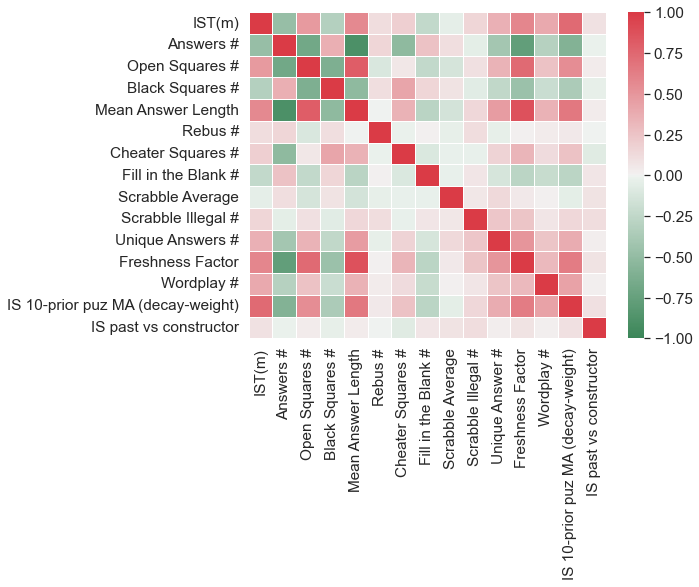

In [137]:
# 15x15 Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]
puzzle_features = IS1_15x15[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw", 'IS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Mean Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'IS_pds_l10_dw': 'IS 10-prior puz MA (decay-weight)',    
'IS_per_constr_avg_past_diff_from_10pMA':'IS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triangle - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Mean Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'IS 10-prior puz MA (decay-weight)', 'IS past vs constructor'])
#_= ans.set_yticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Recent Adj Perf', 'Past Perf vs Constructor(s)'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

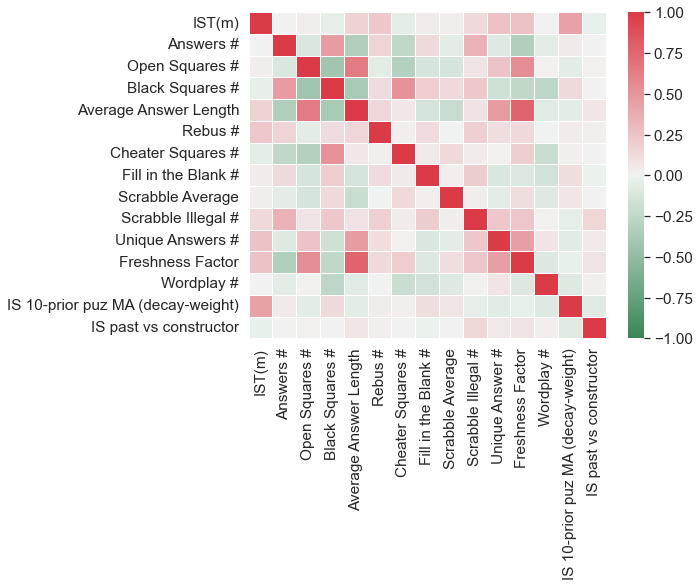

In [140]:
# 21x21 (Sunday) Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS1_21x21 = IS1_df3.loc[IS1_df3["DOW"]==("Sunday")]
puzzle_features = IS1_21x21[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw", 'IS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'IS_pds_l10_dw': 'IS 10-prior puz MA (decay-weight)',    
'IS_per_constr_avg_past_diff_from_10pMA':'IS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'IS 10-prior puz MA (decay-weight)', 'IS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

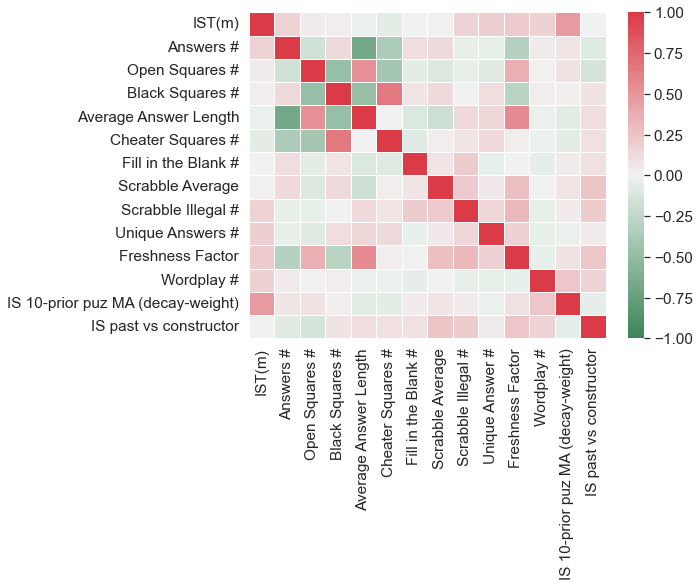

In [141]:
# Monday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS1_df3_Mon = IS1_df3.loc[IS1_df3["DOW"]==("Monday")]
puzzle_features = IS1_df3_Mon[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw", 'IS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'IS_pds_l10_dw': 'IS 10-prior puz MA (decay-weight)',    
'IS_per_constr_avg_past_diff_from_10pMA':'IS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'IS 10-prior puz MA (decay-weight)', 'IS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

In [ ]:
IS1_df3_Mon.info()

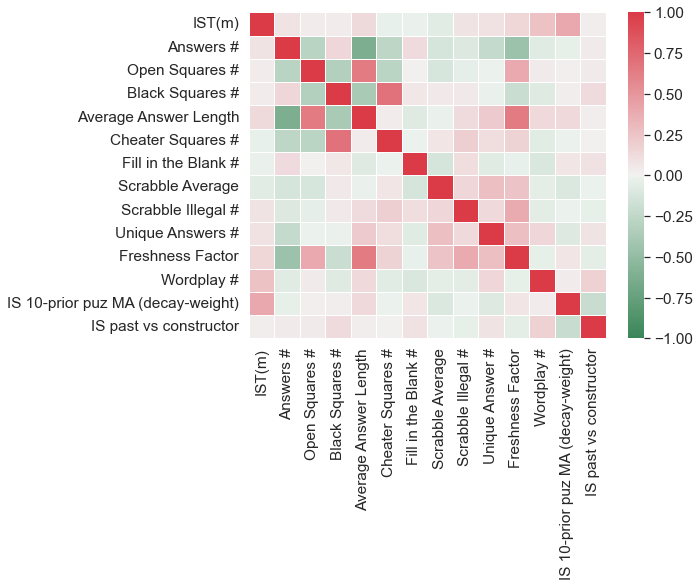

In [142]:
# Tuesday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS1_df3_Tue = IS1_df3.loc[IS1_df3["DOW"]==("Tuesday")]
puzzle_features = IS1_df3_Tue[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw", 'IS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay': 'Wordplay #',
'IS_pds_l10_dw': 'IS 10-prior puz MA (decay-weight)',    
'IS_per_constr_avg_past_diff_from_10pMA':'IS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'IS 10-prior puz MA (decay-weight)', 'IS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

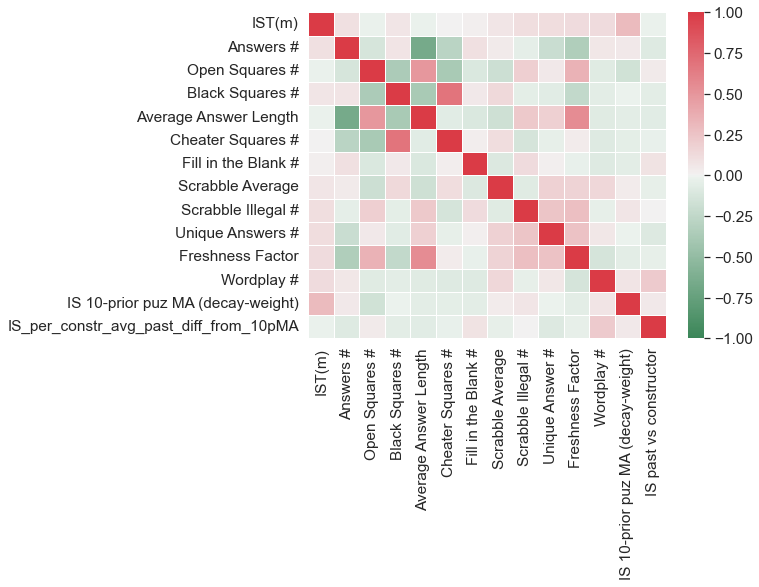

In [144]:
# Wednesday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS1_df3_Wed = IS1_df3.loc[IS1_df3["DOW"]==("Wednesday")]
puzzle_features = IS1_df3_Wed[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw", 'IS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay': 'Wordplay #',
'IS_pds_l10_dw': 'IS 10-prior puz MA (decay-weight)',    
'per_constr_avg_past_diff_from_10pMA':'IS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'IS 10-prior puz MA (decay-weight)', 'IS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

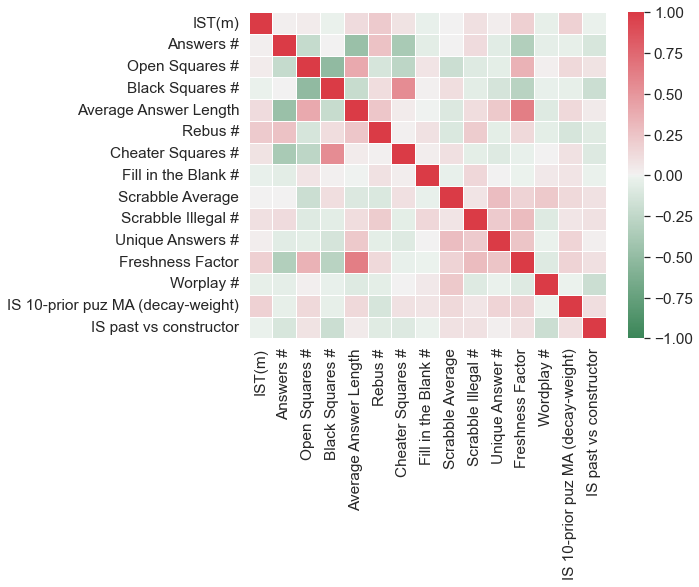

In [145]:
# Thursday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS1_df3_Thurs = IS1_df3.loc[IS1_df3["DOW"]==("Thursday")]
puzzle_features = IS1_df3_Thurs[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Rebus_Count", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw", 'IS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length', 
'Rebus_Count':'Rebus #',    
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Worplay #',
'IS_pds_l10_dw': 'IS 10-prior puz MA (decay-weight)',    
'IS_per_constr_avg_past_diff_from_10pMA':'IS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Rebus #', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'IS 10-prior puz MA (decay-weight)', 'IS past vs constructor'])
#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

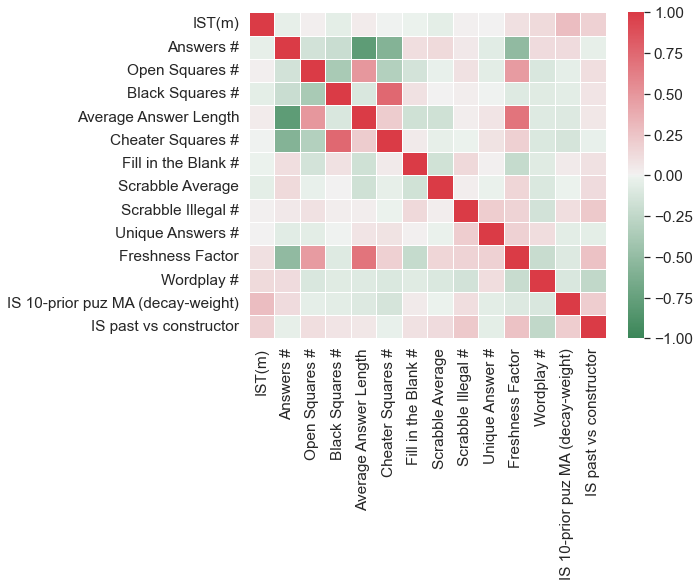

In [146]:
# Friday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS1_df3_Fri = IS1_df3.loc[IS1_df3["DOW"]==("Friday")]
puzzle_features = IS1_df3_Fri[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw", 'IS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'IS_pds_l10_dw': 'IS 10-prior puz MA (decay-weight)',    
'IS_per_constr_avg_past_diff_from_10pMA':'IS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'IS 10-prior puz MA (decay-weight)', 'IS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

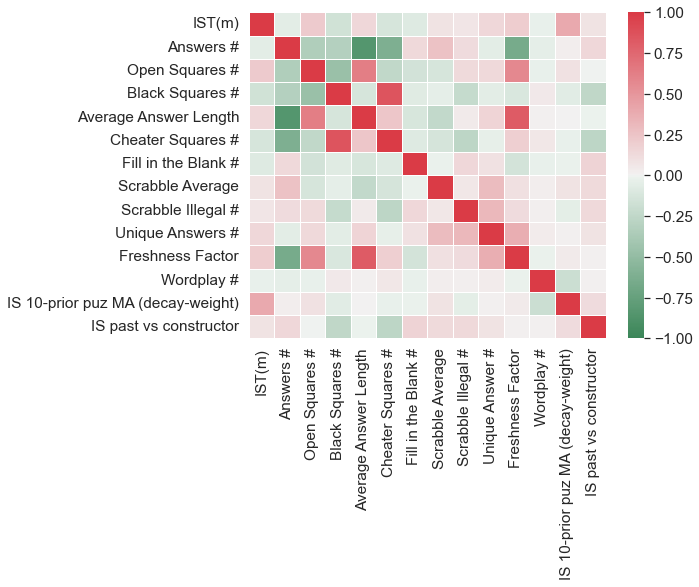

In [148]:
# Saturday Puzzles Features Correlation to Individual Solver Raw Solve Times Heat Map

IS1_df3_Sat = IS1_df3.loc[IS1_df3["DOW"]==("Saturday")]
puzzle_features = IS1_df3_Sat[["IST(m)", "Words", "Open_Squares", "Blocks", "AWL", "Cheater_Squares", "FITB", "Scrabble_Avg", "Scrabble_Illegal", "Unique_Answers", "Freshness_Factor", "Wordplay", "IS_pds_l10_dw", 'IS_per_constr_avg_past_diff_from_10pMA']]

corr = puzzle_features.corr()

labels = {
'IST(m)':'IST(m)',  
'Words':'Answers #', 
'Open_Squares':'Open Squares #',
'Blocks': 'Black Squares #',
'AWL':'Average Answer Length',   
'Cheater_Squares':'Cheater Squares #',
'FITB':'Fill in the Blank #',
'Scrabble_Avg':'Scrabble Average',
'Scrabble_Illegal':'Scrabble Illegal #',
'Unique_Answers':'Unique Answers #',
'Freshness_Factor':'Freshness Factor',
'Wordplay':'Wordplay #',
'IS_pds_l10_dw': 'IS 10-prior puz MA (decay-weight)',    
'IS_per_constr_avg_past_diff_from_10pMA':'IS past vs constructor'
}

corr = corr.rename(labels)

# remove the top right triange - duplicate information
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Colors
cmap = sns.diverging_palette(500, 10, as_cmap=True)

# uncomment this if want only the lower triangle matrix 
# ans=sns.heatmap(corr, mask=mask,  linewidths=1, cmap=cmap, center=0)
plt.figure(figsize=(8,6))
ans=sns.heatmap(corr,  linewidths=1, cmap=cmap, center=0, xticklabels=True, yticklabels=True, vmin=-1, vmax=1)

_= ans.set_xticklabels(['IST(m)', 'Answers #', 'Open Squares #', 'Black Squares #', 'Average Answer Length', 'Cheater Squares #', 'Fill in the Blank #', 'Scrabble Average', 'Scrabble Illegal #', 'Unique Answer #', 'Freshness Factor', 'Wordplay #', 'IS 10-prior puz MA (decay-weight)', 'IS past vs constructor'])

#save image 
# figure = ans.get_figure()    
# figure.savefig('correlations.png', dpi=800)

### Scatterplots of Relationship of Grid, Answer and Past-Performance Parameters to IS1 Per Puzzle Performance

In [ ]:
IS1_df3.info()

In [149]:
# Create new df with all rows copied and placed below current rows. 
# This is so we can plot all 15x15 data together as a subplot in the figures below

IS1_df3_copy = IS1_df3.loc[(IS1_df3["DOW_num"] != 1)] #15x15 only
IS1_df3_copy["DOW_num"] = 0

IS1_df4 = pd.concat([IS1_df3, IS1_df3_copy],ignore_index=True)

In [ ]:
IS1_df4.info()

In [ ]:
IS1_df4["DOW_num"].unique()

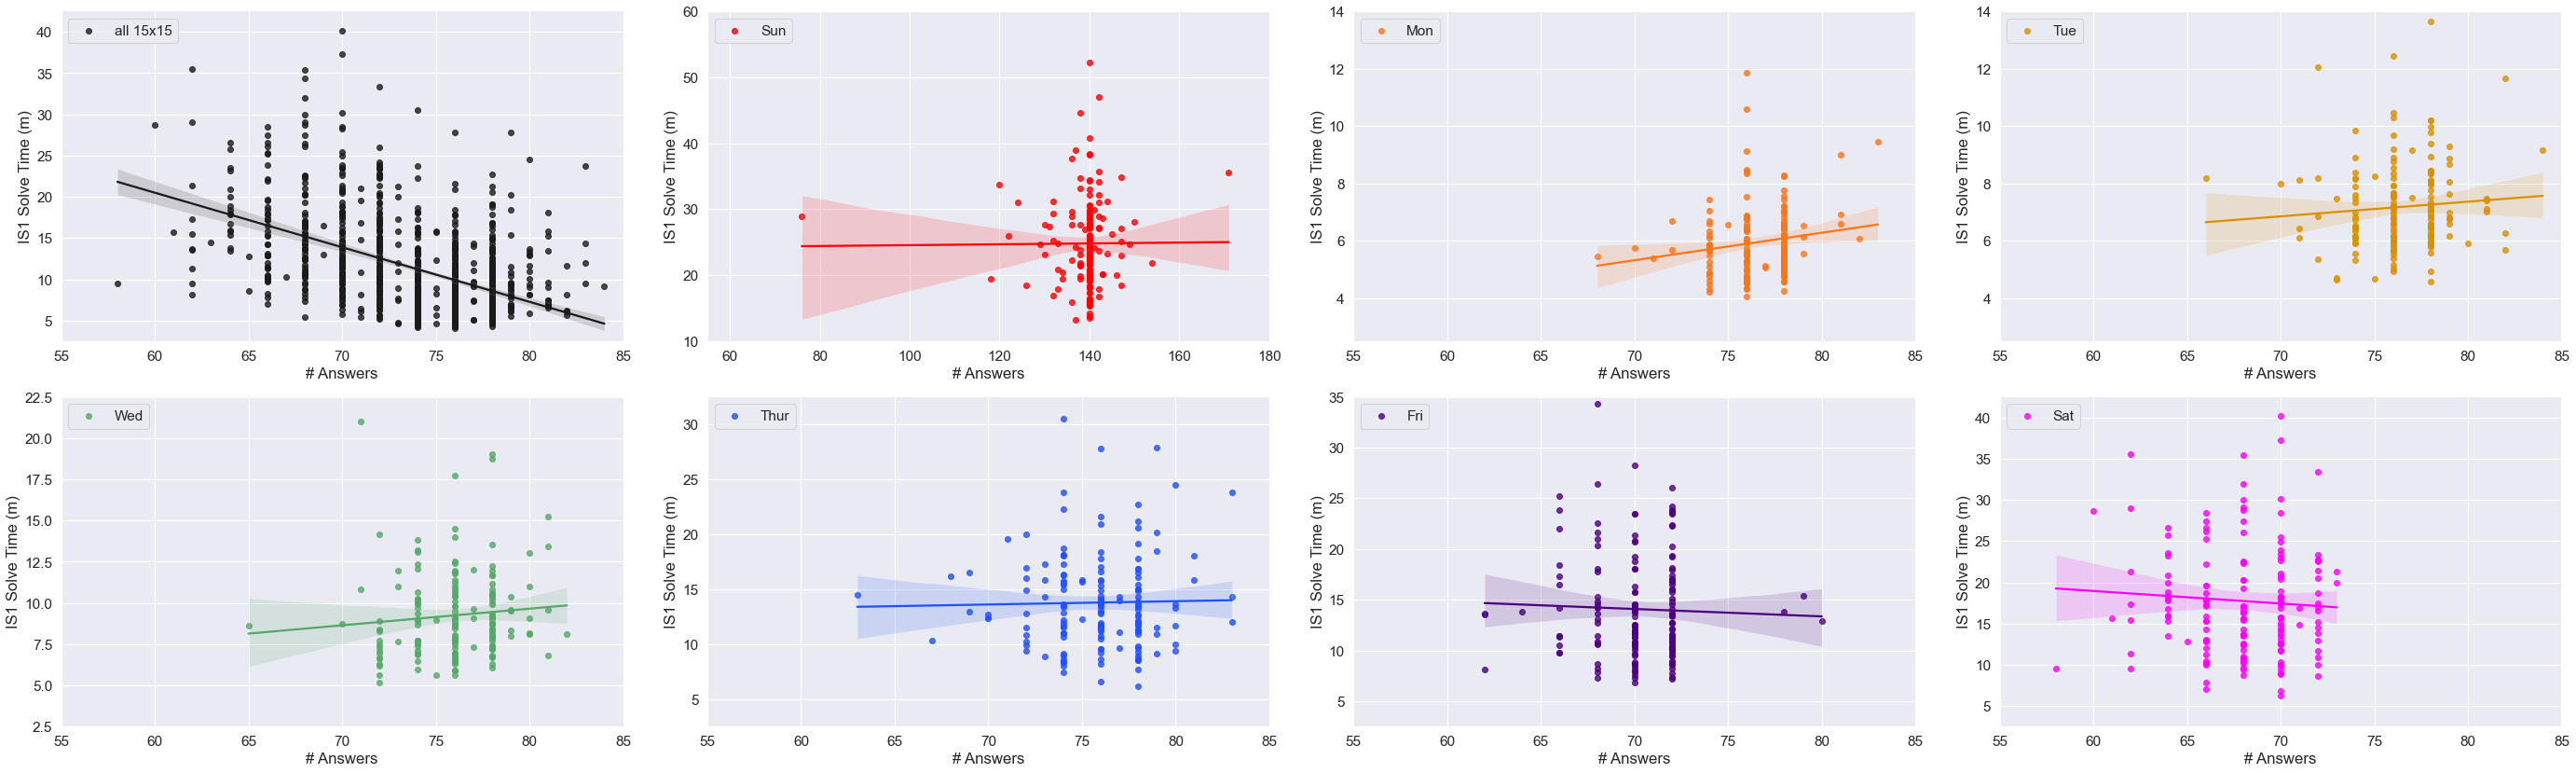

In [150]:
# Number of Answers vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="Words", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Answers",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((55,85))
p.axes[1].set_xlim((55,180))
p.axes[2].set_xlim((55,85))
p.axes[3].set_xlim((55,85))
p.axes[4].set_xlim((55,85))
p.axes[5].set_xlim((55,85))
p.axes[6].set_xlim((55,85))
p.axes[7].set_xlim((55,85))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,22.5))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [152]:
# Calculate Pearson R for 15x15 grids for this feature
IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Words']))

-0.48328574939823404


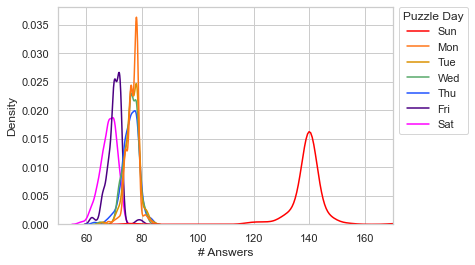

In [151]:
# Density plot of number of answers in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together
IS1_df3['plot_seq_map'] = IS1_df3['DOW_num'].map({1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'})
IS1_df3 = IS1_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df3, x = "Words", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(50, 170)
ax.set_xlabel("# Answers")
plt.show()

In [153]:
IS1_df3["Words"].agg(['min', 'max'])

min     58
max    171
Name: Words, dtype: int64

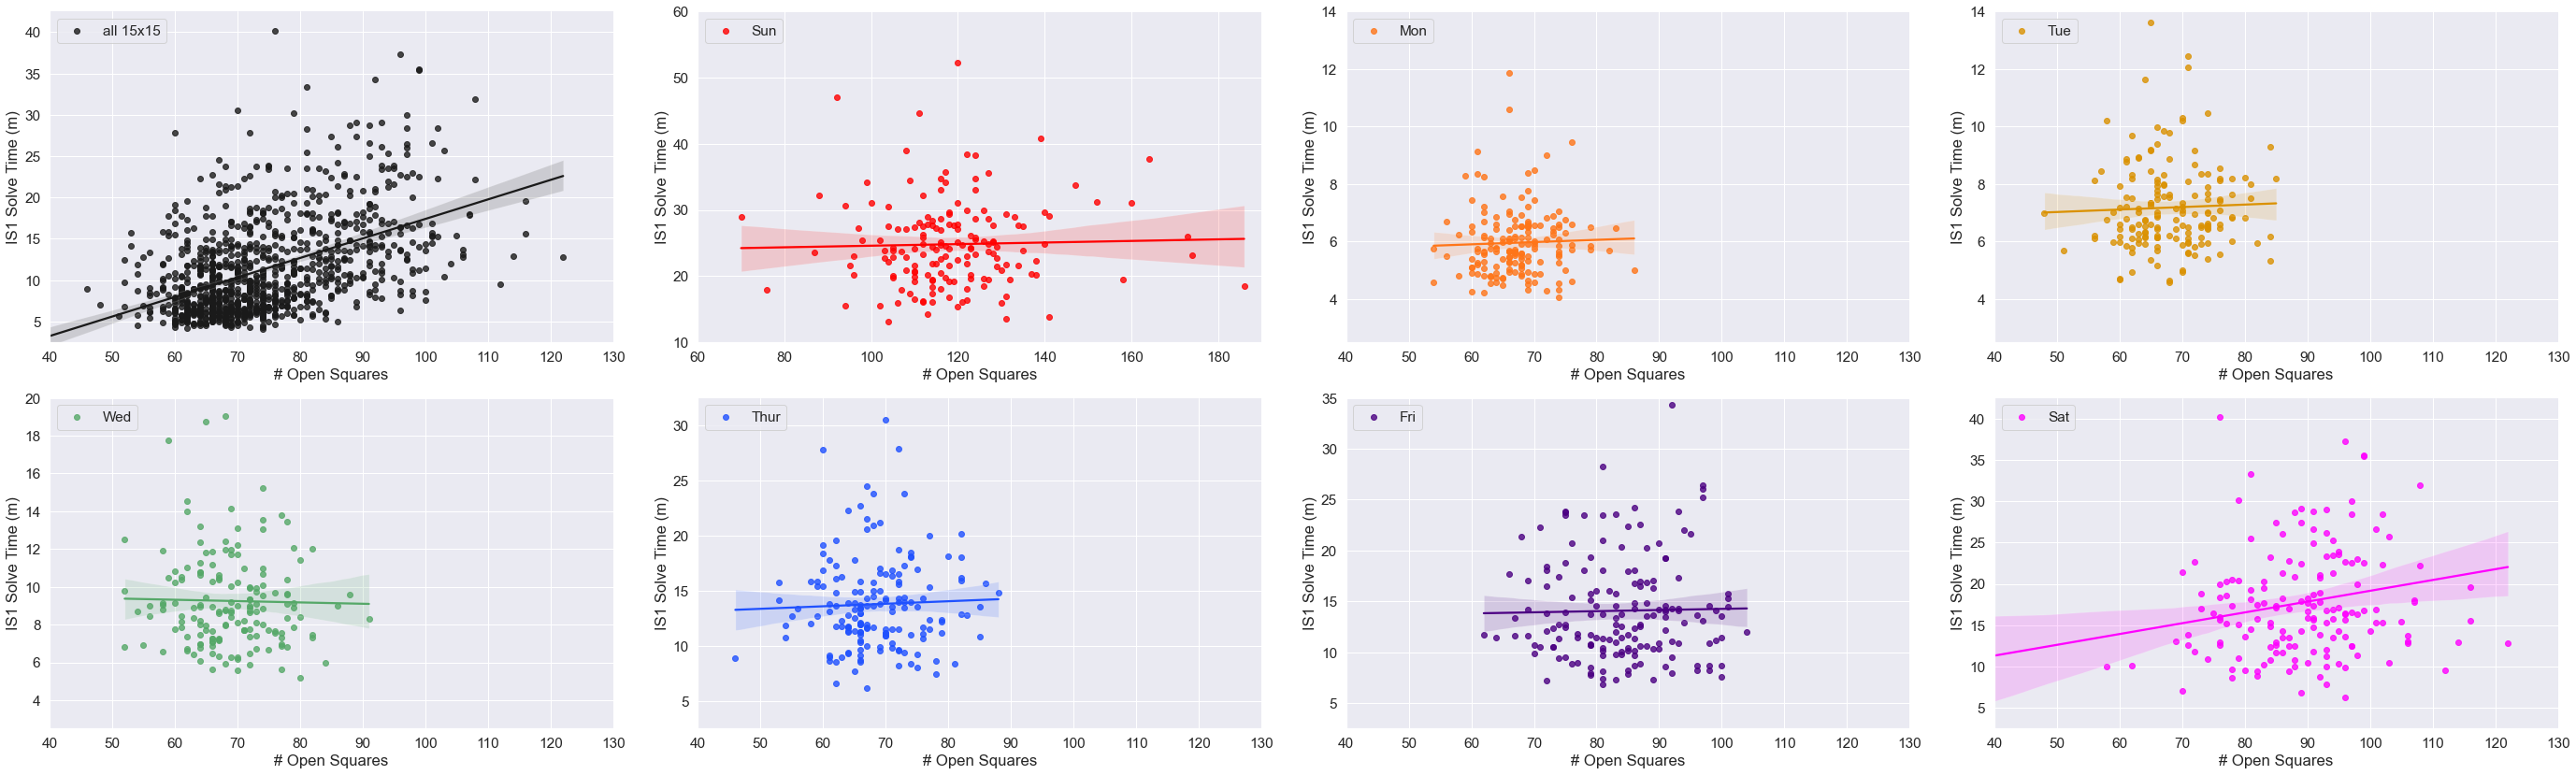

In [158]:
# Open Squares vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="Open_Squares", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Open Squares",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((40,130))
p.axes[1].set_xlim((60,190))
p.axes[2].set_xlim((40,130))
p.axes[3].set_xlim((40,130))
p.axes[4].set_xlim((40,130))
p.axes[5].set_xlim((40,130))
p.axes[6].set_xlim((40,130))
p.axes[7].set_xlim((40,130))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [155]:
# Calculate Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Open_Squares']))

0.47823613870955667


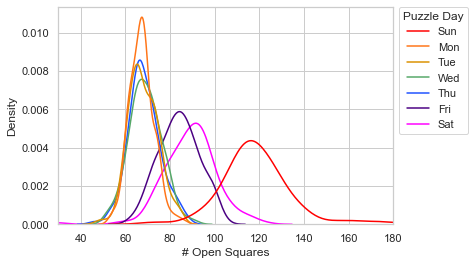

In [156]:
# Density plot of number of open squares in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df3 = IS1_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df3, x = "Open_Squares", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(30, 180)
ax.set_xlabel("# Open Squares")
plt.show()

In [157]:
IS1_df3["Open_Squares"].agg(['min', 'max'])

min     29
max    186
Name: Open_Squares, dtype: int64

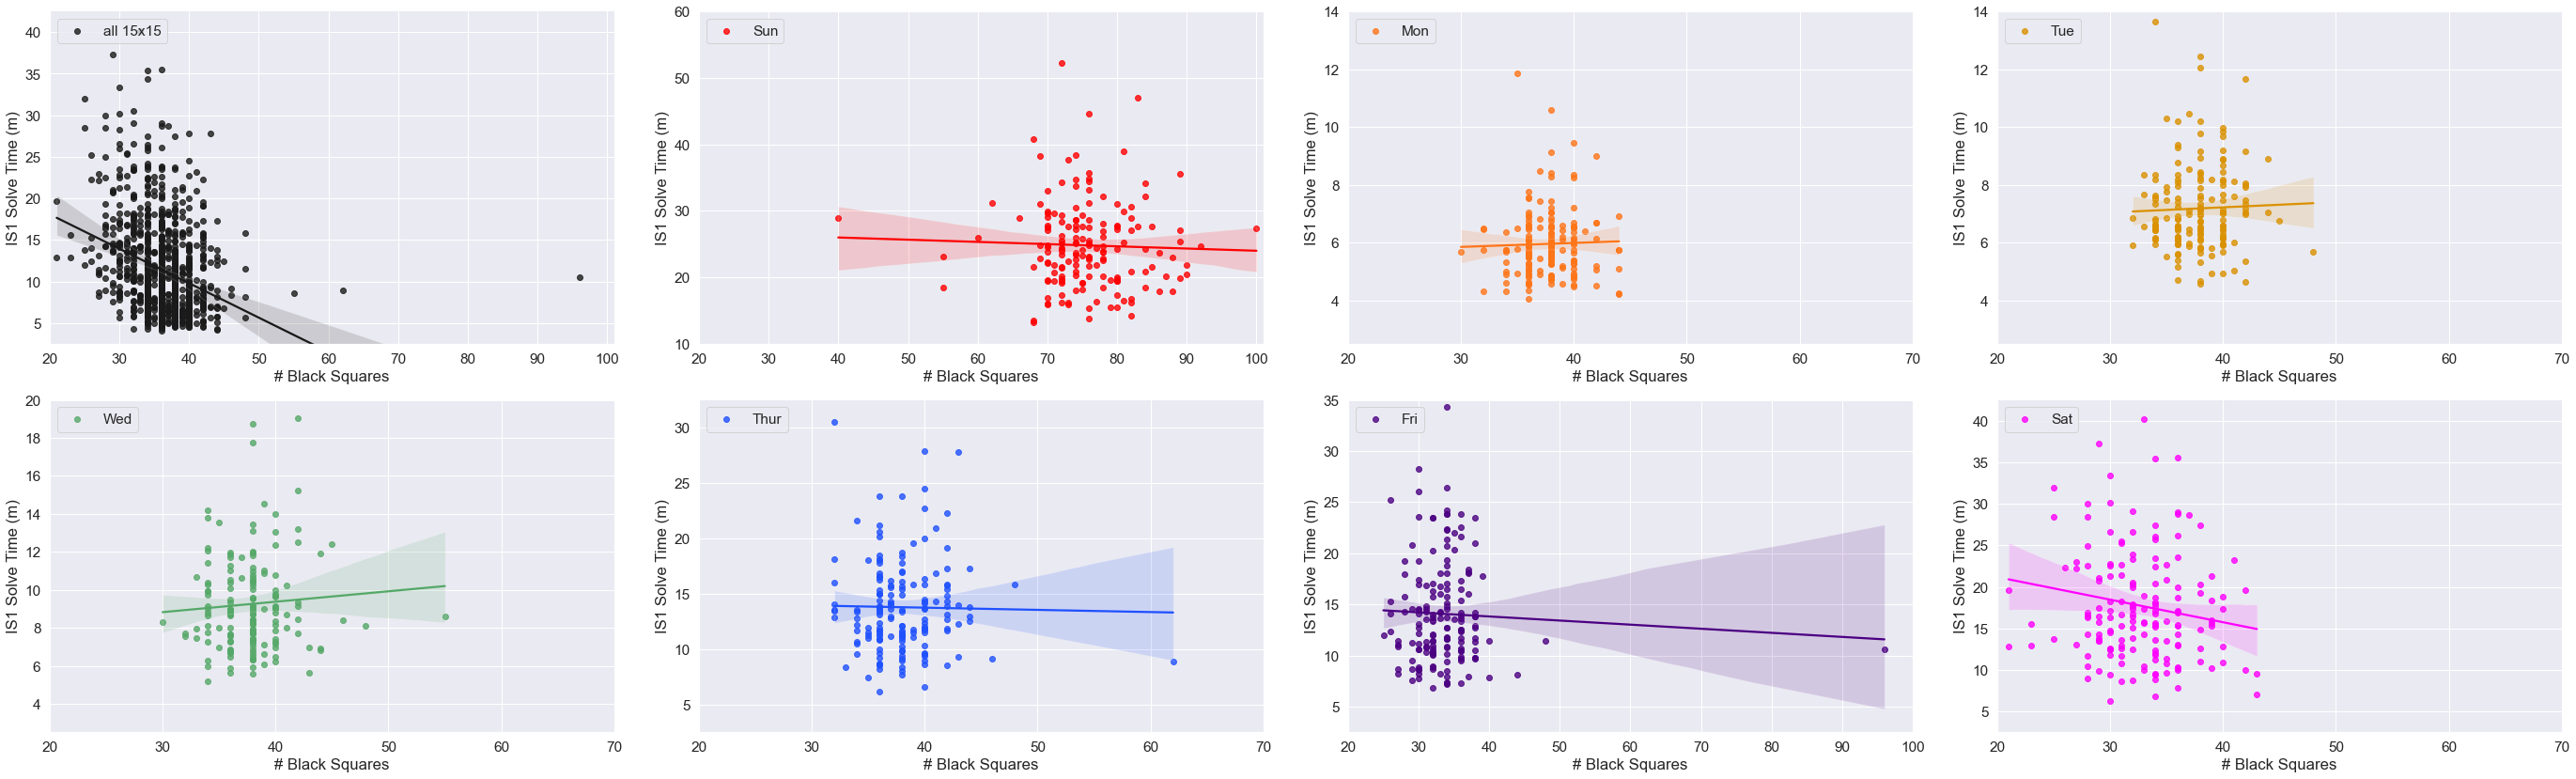

In [159]:
# Black Squares (blocks) vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="Blocks", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Black Squares",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((20,101))
p.axes[1].set_xlim((20,101))
p.axes[2].set_xlim((20,70))
p.axes[3].set_xlim((20,70))
p.axes[4].set_xlim((20,70))
p.axes[5].set_xlim((20,70))
p.axes[6].set_xlim((20,100))
p.axes[7].set_xlim((20,70))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [161]:
# Calculate Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Blocks']))

-0.3127785785754322


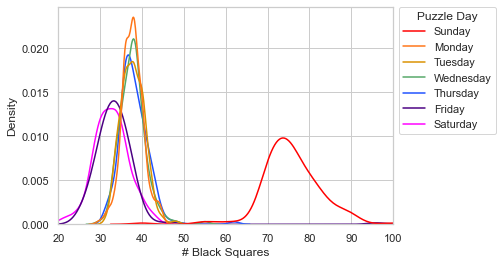

In [162]:
# Density plot of number of black squares (blocks) in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df3 = IS1_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df3, x = "Blocks", hue= "DOW", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(20, 100)
ax.set_xlabel("# Black Squares")
plt.show()

In [163]:
IS1_df3["Blocks"].agg(['min', 'max'])

min     21
max    100
Name: Blocks, dtype: int64

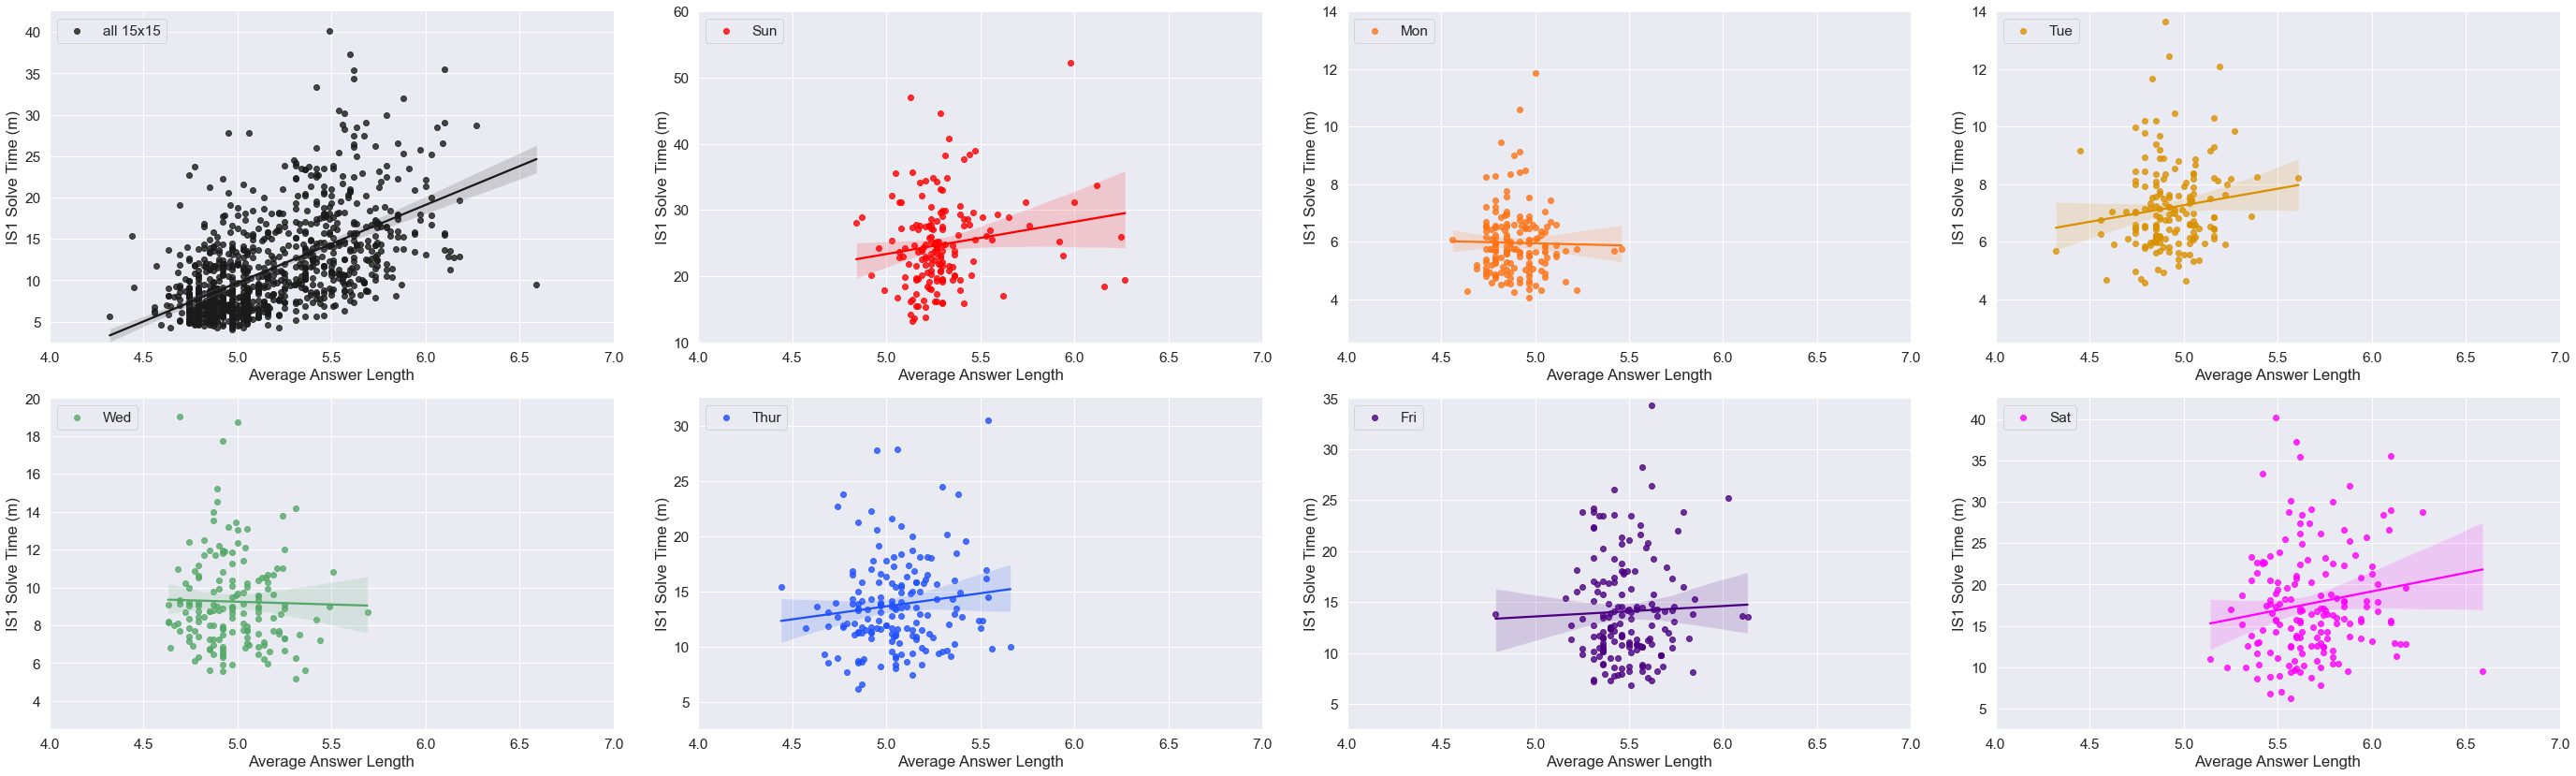

In [164]:
# Average Answer Length vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="AWL", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Average Answer Length",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((4,7))
p.axes[1].set_xlim((4,7))
p.axes[2].set_xlim((4,7))
p.axes[3].set_xlim((4,7))
p.axes[4].set_xlim((4,7))
p.axes[5].set_xlim((4,7))
p.axes[6].set_xlim((4,7))
p.axes[7].set_xlim((4,7))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [166]:
# Calculate Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['AWL']))

0.5670434157174812


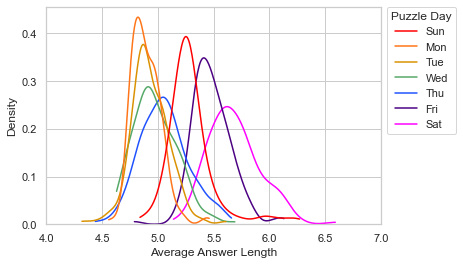

In [167]:
# Density plot of average answer length in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df3 = IS1_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df3, x = "AWL", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(3,7))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(4, 7)
ax.set_xlabel("Average Answer Length")
plt.show()

In [168]:
IS1_df3["AWL"].agg(['min', 'max'])

min    4.32
max    6.59
Name: AWL, dtype: float64

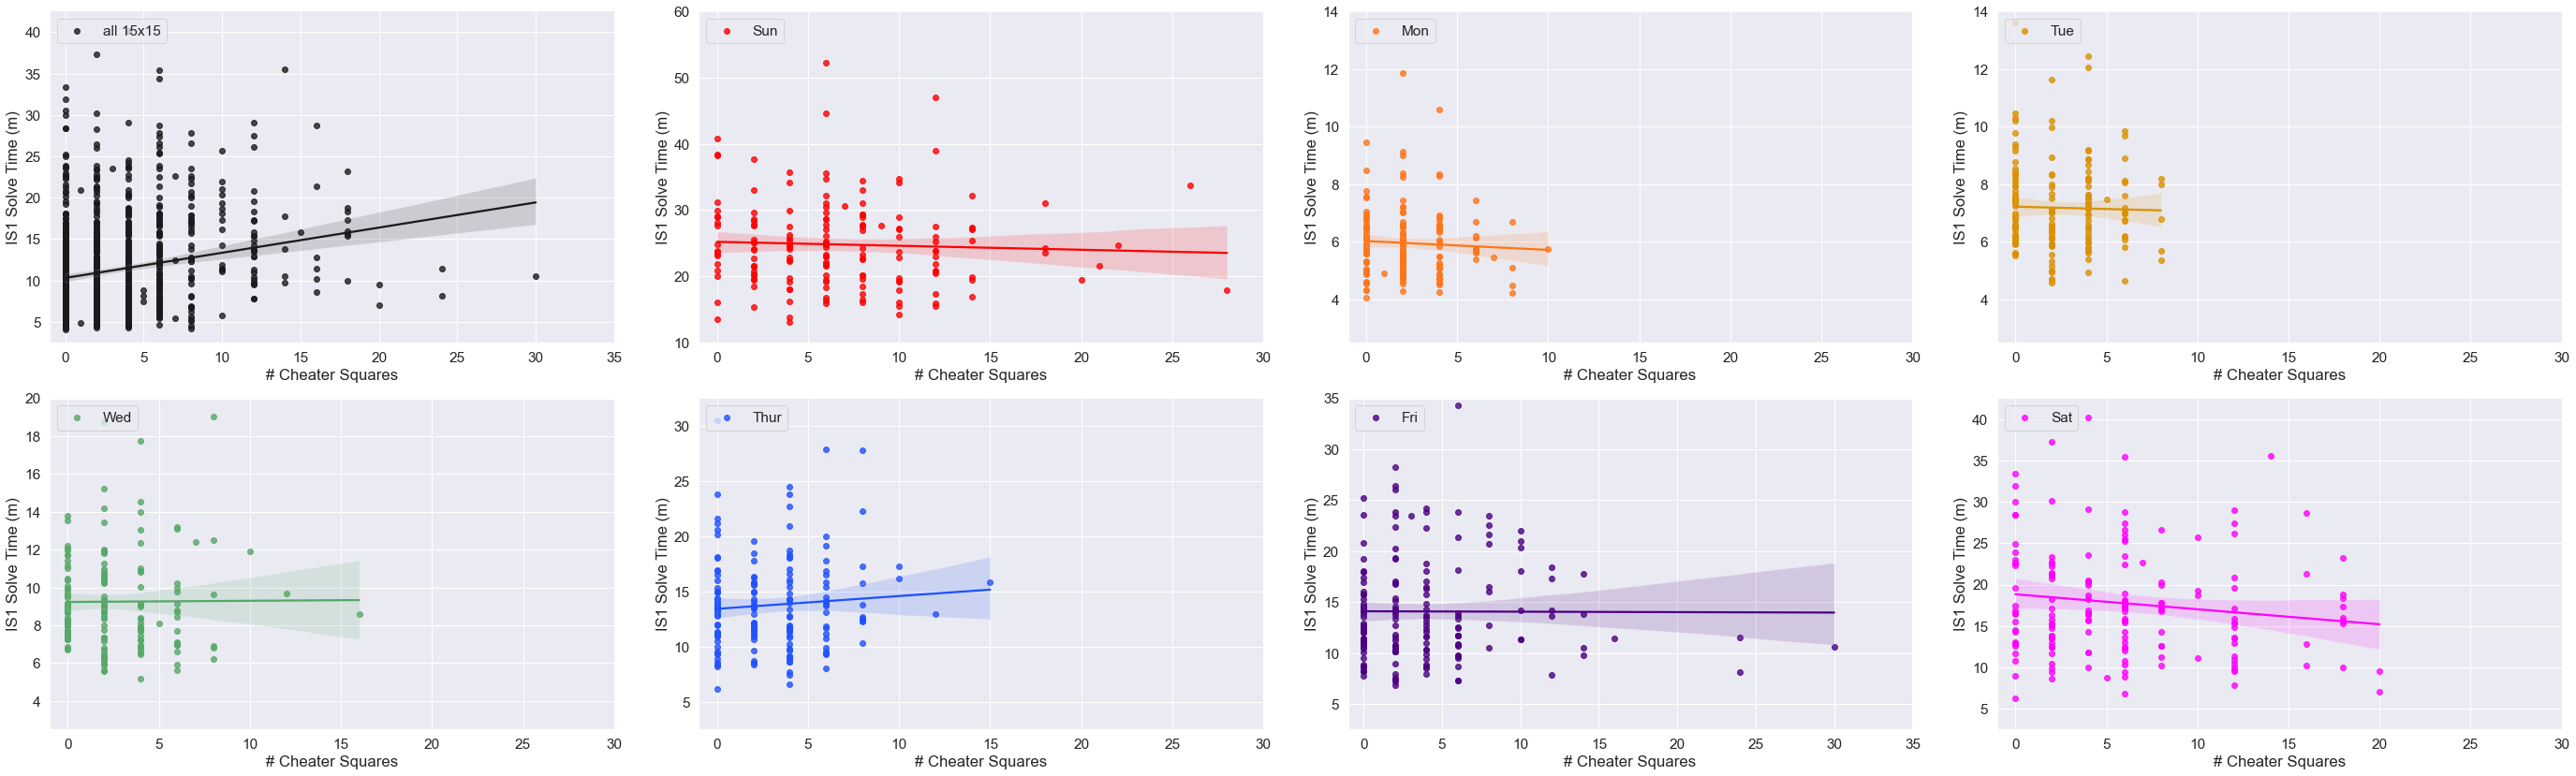

In [169]:
# Cheater Squares vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="Cheater_Squares", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Cheater Squares",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,35))
p.axes[1].set_xlim((-1,30))
p.axes[2].set_xlim((-1,30))
p.axes[3].set_xlim((-1,30))
p.axes[4].set_xlim((-1,30))
p.axes[5].set_xlim((-1,30))
p.axes[6].set_xlim((-1,35))
p.axes[7].set_xlim((-1,30))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [170]:
# Calculate Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Cheater_Squares']))

0.19302878435608886


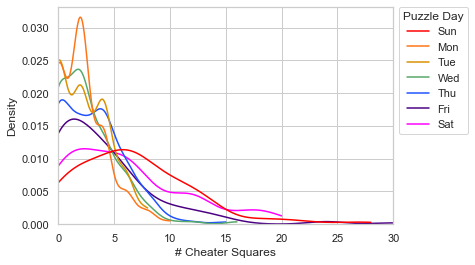

In [172]:
# Density plot of number of cheater squares in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df3 = IS1_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df3, x = "Cheater_Squares", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(0,30))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(0, 30)
ax.set_xlabel("# Cheater Squares")
plt.show()

In [173]:
IS1_df3["Cheater_Squares"].agg(['min', 'max'])

min     0
max    30
Name: Cheater_Squares, dtype: int64

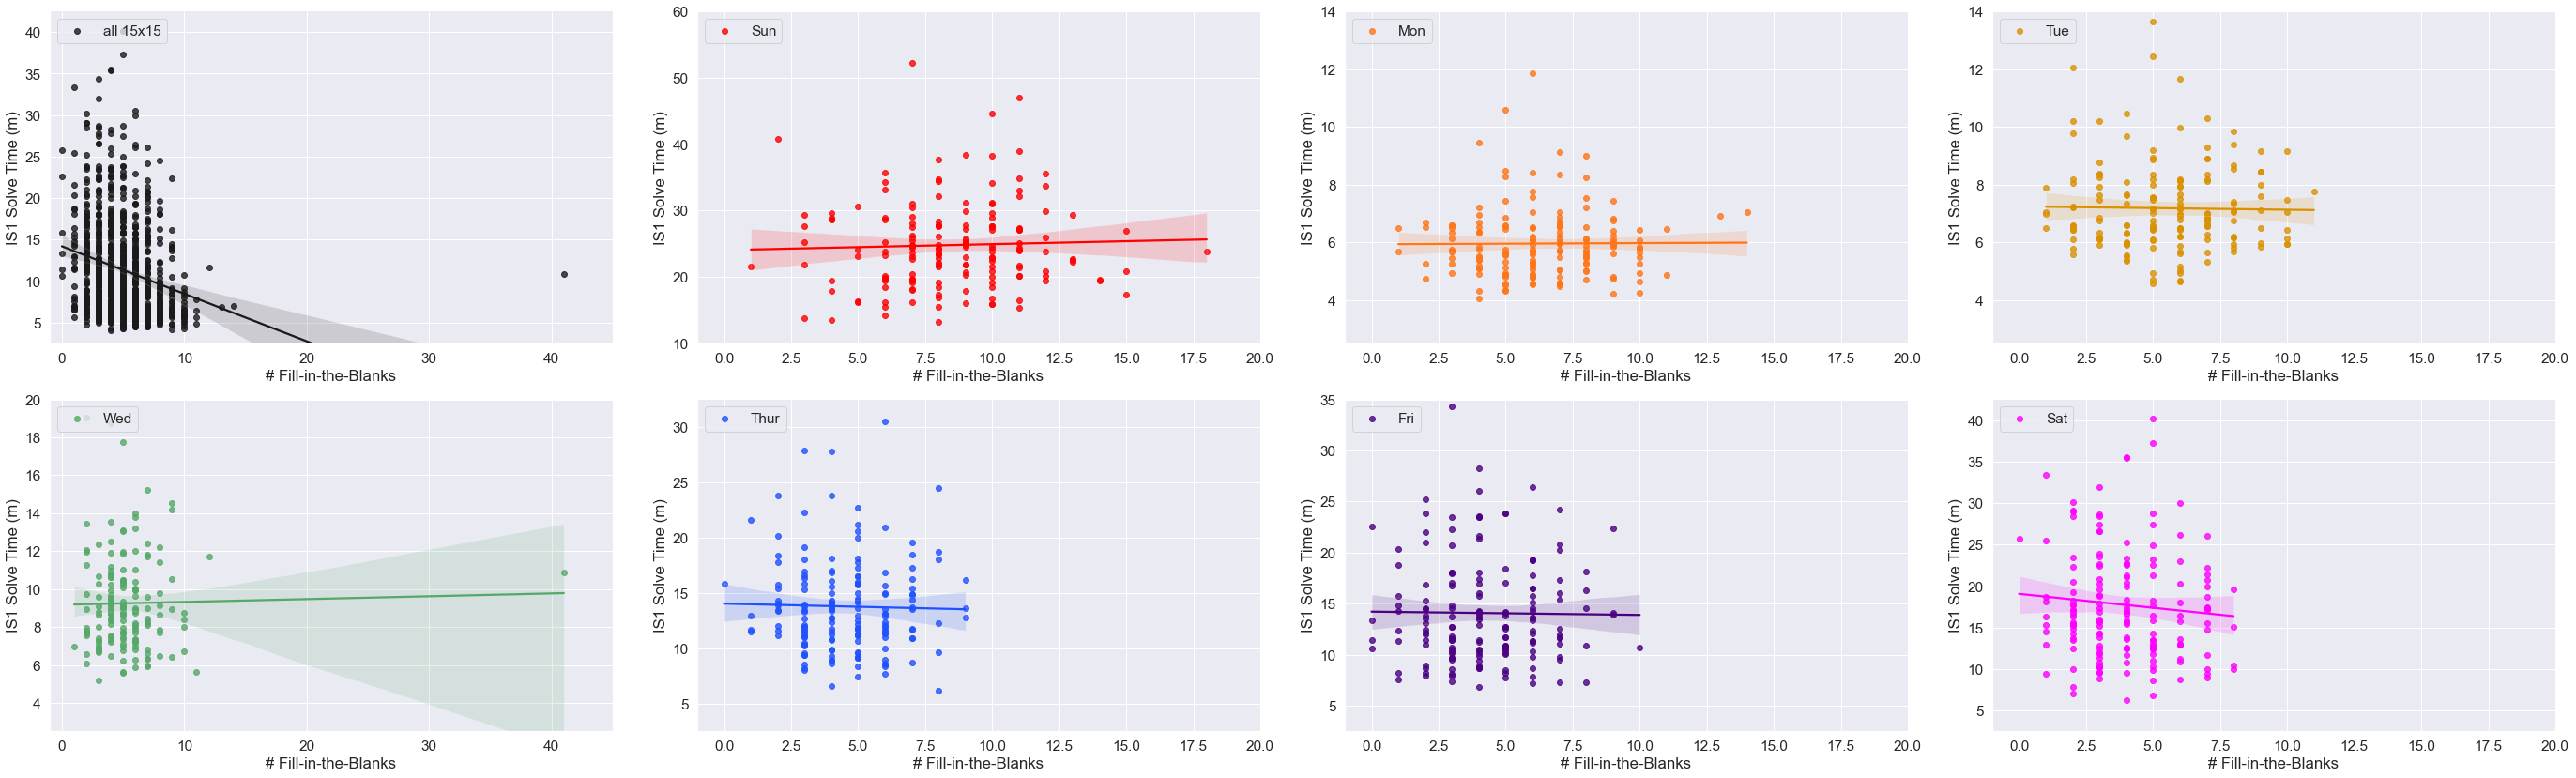

In [174]:
# Fill-in-the-blank clues vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="FITB", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Fill-in-the-Blanks",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,45))
p.axes[1].set_xlim((-1,20))
p.axes[2].set_xlim((-1,20))
p.axes[3].set_xlim((-1,20))
p.axes[4].set_xlim((-1,45))
p.axes[5].set_xlim((-1,20))
p.axes[6].set_xlim((-1,20))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [175]:
# Calculate Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['FITB']))

-0.24055773038706368


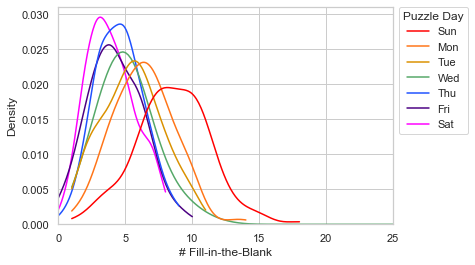

In [176]:
# Density plot of number of fill-in-the-blank clues in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df3 = IS1_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df3, x = "FITB", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(0,45))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(0, 25)
ax.set_xlabel("# Fill-in-the-Blank")
plt.show()

In [177]:
IS1_df3["FITB"].agg(['min', 'max'])

min     0
max    41
Name: FITB, dtype: int64

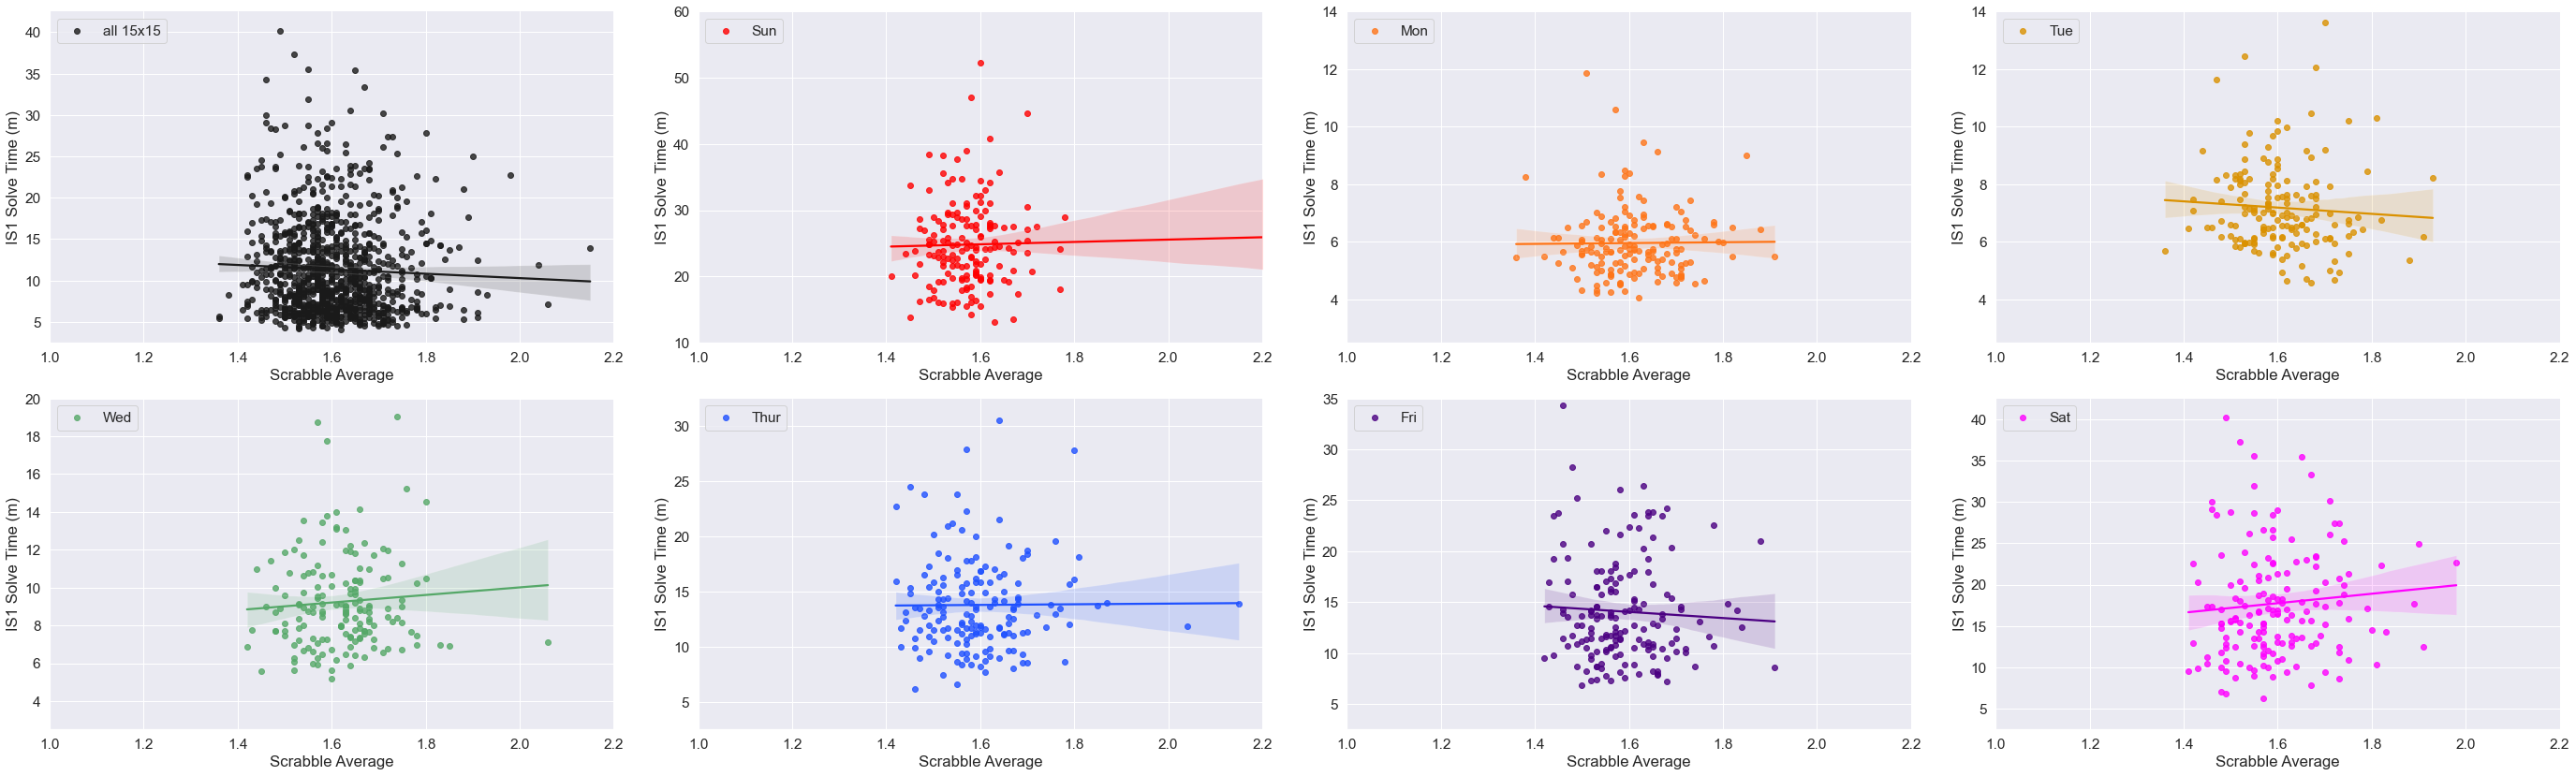

In [178]:
# Scrabble Average vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="Scrabble_Avg", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Scrabble Average",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((1,2.2))
p.axes[1].set_xlim((1,2.2))
p.axes[2].set_xlim((1,2.2))
p.axes[3].set_xlim((1,2.2))
p.axes[4].set_xlim((1,2.2))
p.axes[5].set_xlim((1,2.2))
p.axes[6].set_xlim((1,2.2))
p.axes[7].set_xlim((1,2.2))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [180]:
# Calculate Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Scrabble_Avg']))

-0.04351763088509211


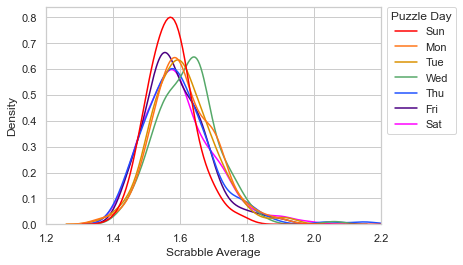

In [181]:
# Density plot of Scrabble Average in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df3 = IS1_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df3, x = "Scrabble_Avg", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(1.2, 2.2)
ax.set_xlabel("Scrabble Average")
plt.show()

In [182]:
IS1_df3["Scrabble_Avg"].agg(['min', 'max'])

min    1.36
max    2.45
Name: Scrabble_Avg, dtype: float64

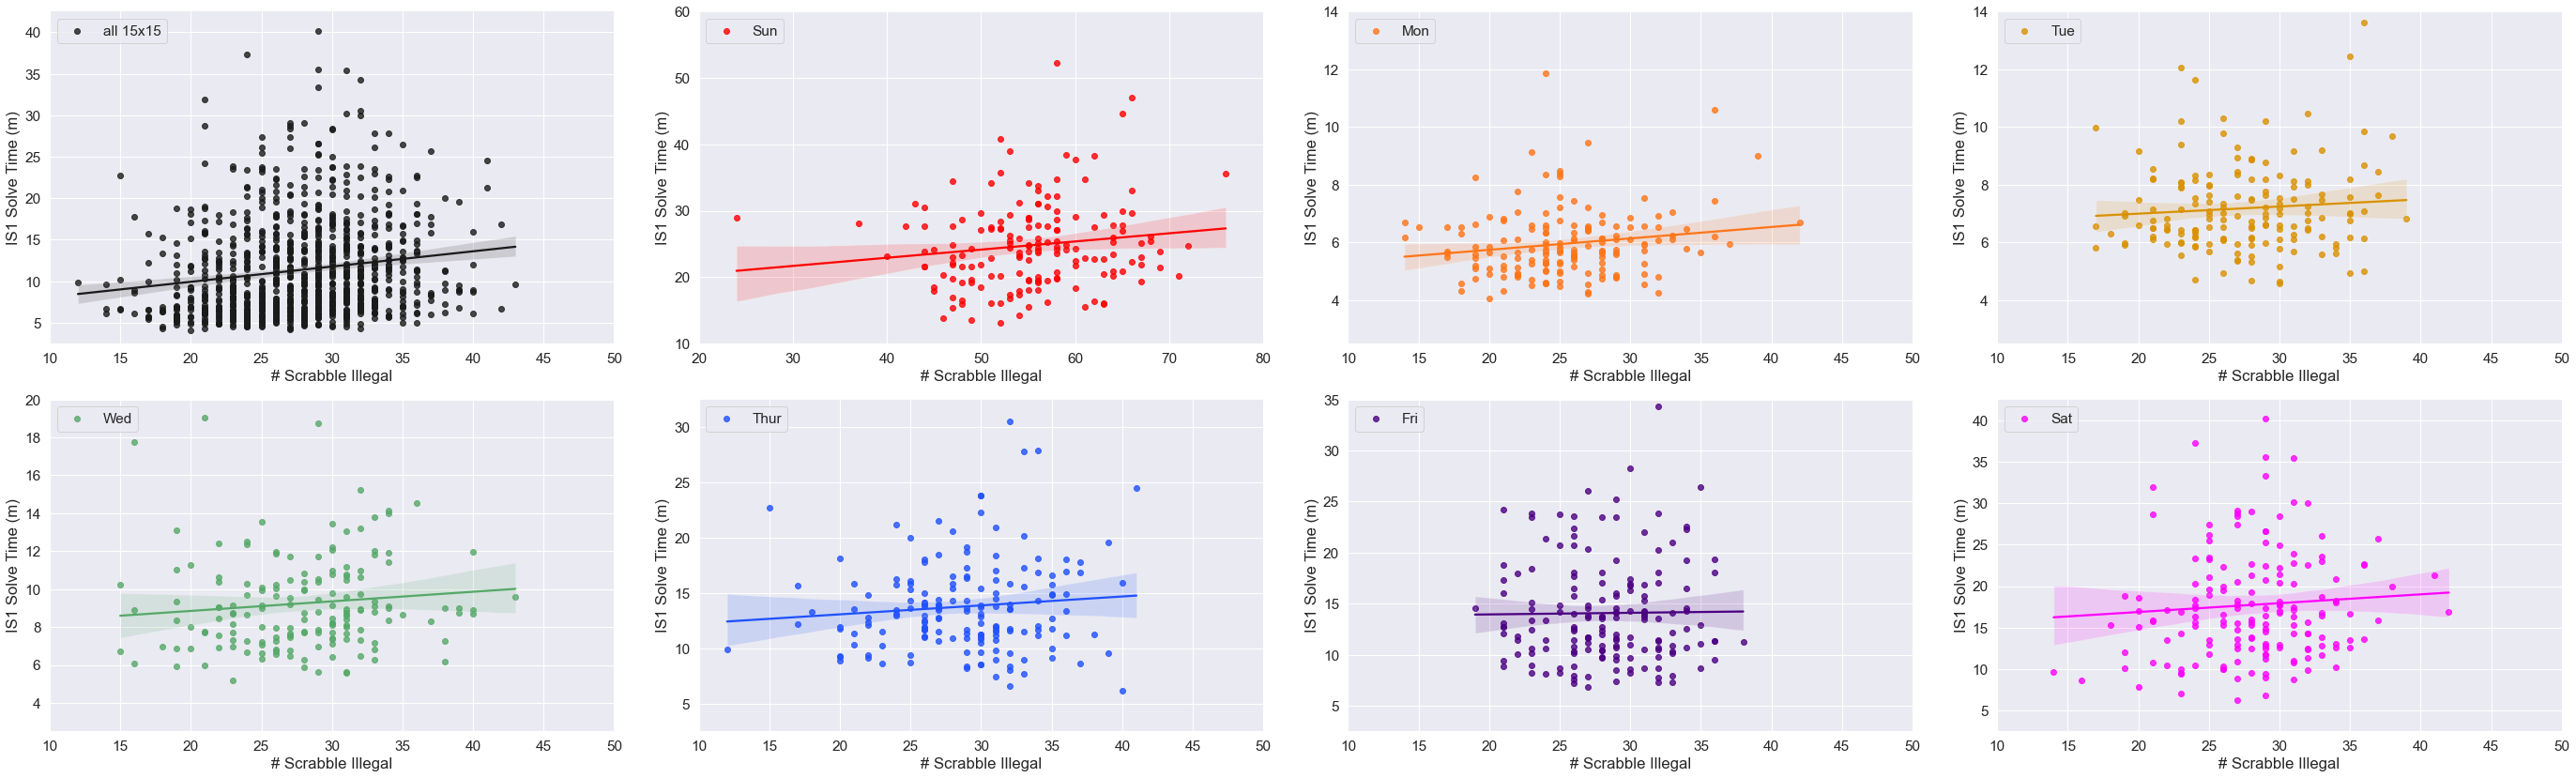

In [183]:
# Scrabble Illegal # vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="Scrabble_Illegal", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Scrabble Illegal",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((10,50))
p.axes[1].set_xlim((20,80))
p.axes[2].set_xlim((10,50))
p.axes[3].set_xlim((10,50))
p.axes[4].set_xlim((10,50))
p.axes[5].set_xlim((10,50))
p.axes[6].set_xlim((10,50))
p.axes[7].set_xlim((10,50))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [184]:
# Calculate Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Scrabble_Illegal']))

0.15439997716213183


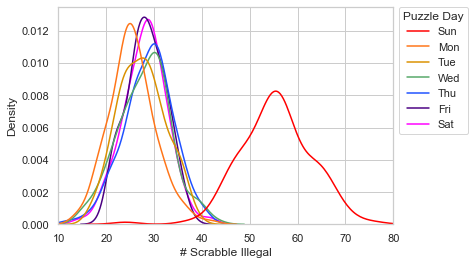

In [185]:
# Density plot of Scrabble Illegal # in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df3 = IS1_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df3, x = "Scrabble_Illegal", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(10, 80)
ax.set_xlabel("# Scrabble Illegal")
plt.show()

In [186]:
IS1_df3["Scrabble_Illegal"].agg(['min', 'max'])

min    12
max    76
Name: Scrabble_Illegal, dtype: int64

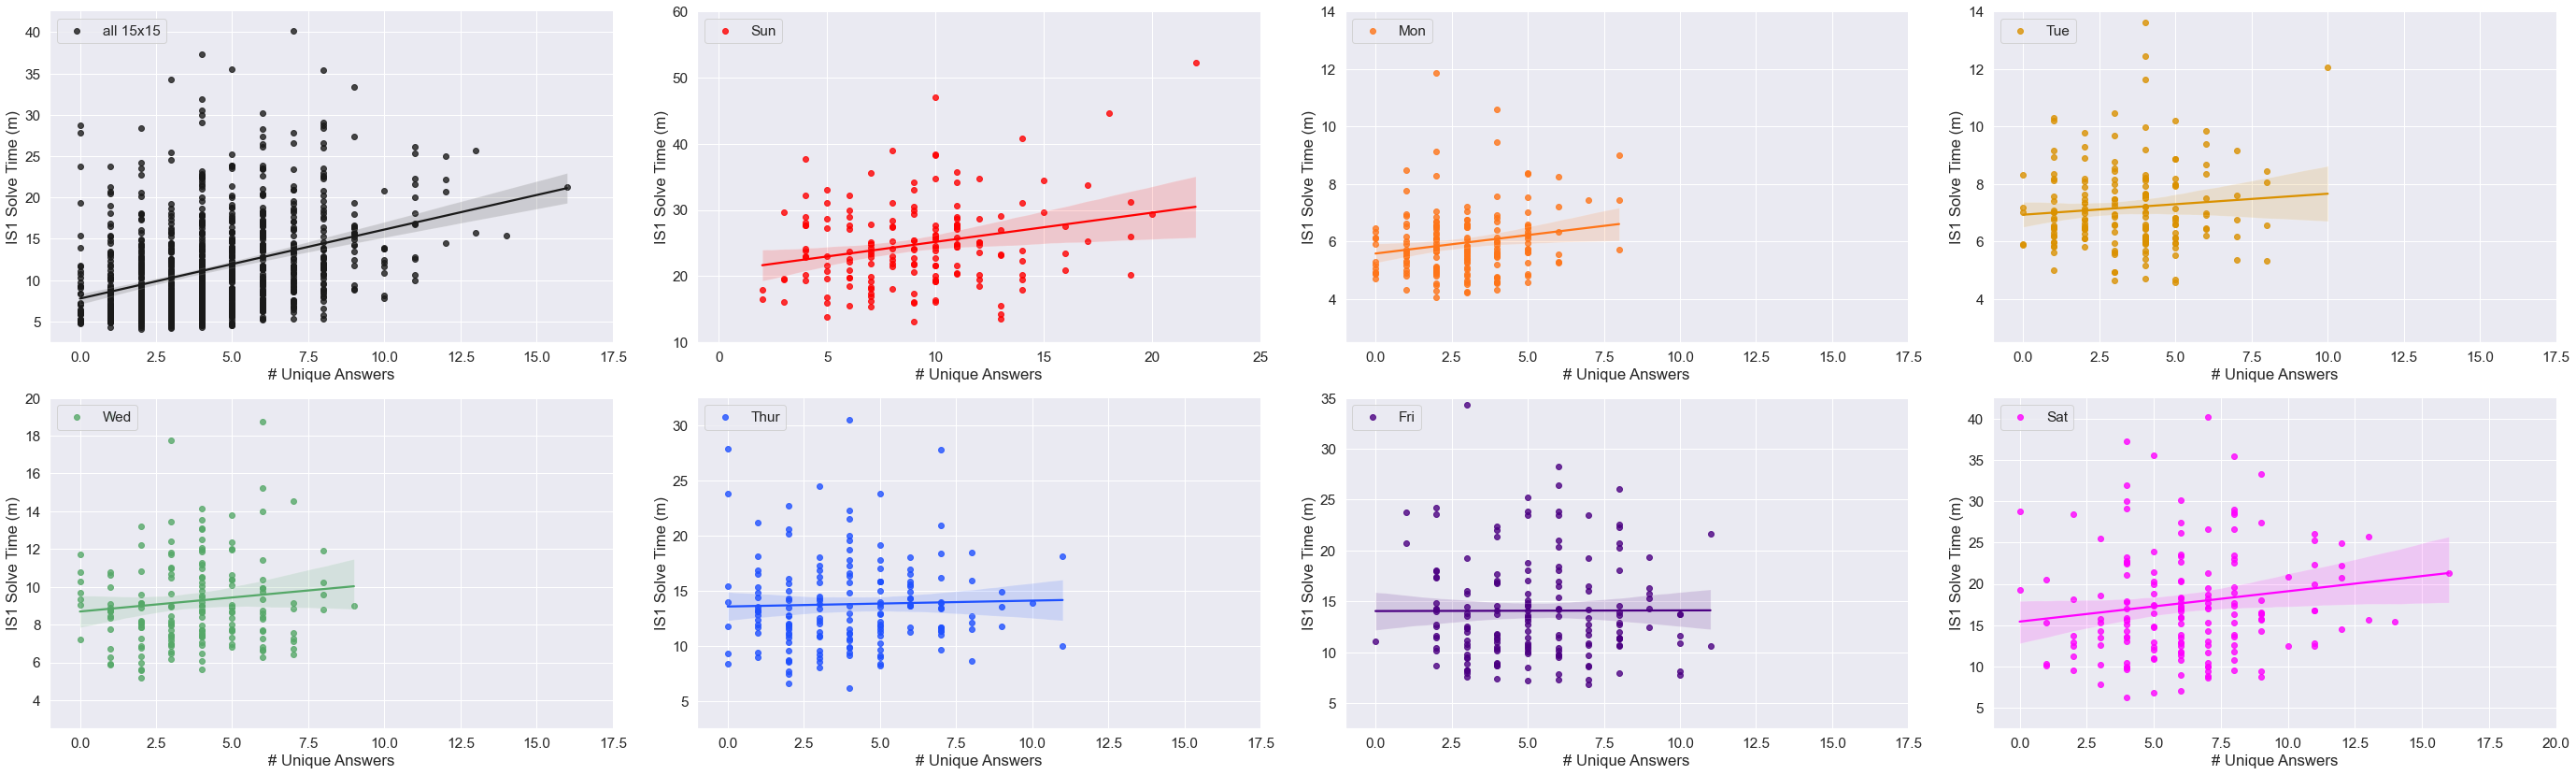

In [187]:
# Unique Answers # # vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="Unique_Answers", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Unique Answers",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,17.5))
p.axes[1].set_xlim((-1,25))
p.axes[2].set_xlim((-1,17.5))
p.axes[3].set_xlim((-1,17.5))
p.axes[4].set_xlim((-1,17.5))
p.axes[5].set_xlim((-1,17.5))
p.axes[6].set_xlim((-1,17.5))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [188]:
# Calculate Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Unique_Answers']))

0.353602563361635


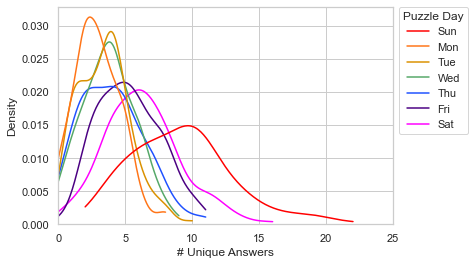

In [189]:
# Density plot of Unique Answers # in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df3 = IS1_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df3, x = "Unique_Answers", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True, cut=0, clip=(0,25))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(0, 25)
ax.set_xlabel("# Unique Answers")
plt.show()

In [190]:
IS1_df3["Unique_Answers"].agg(['min', 'max'])

min     0
max    22
Name: Unique_Answers, dtype: int64

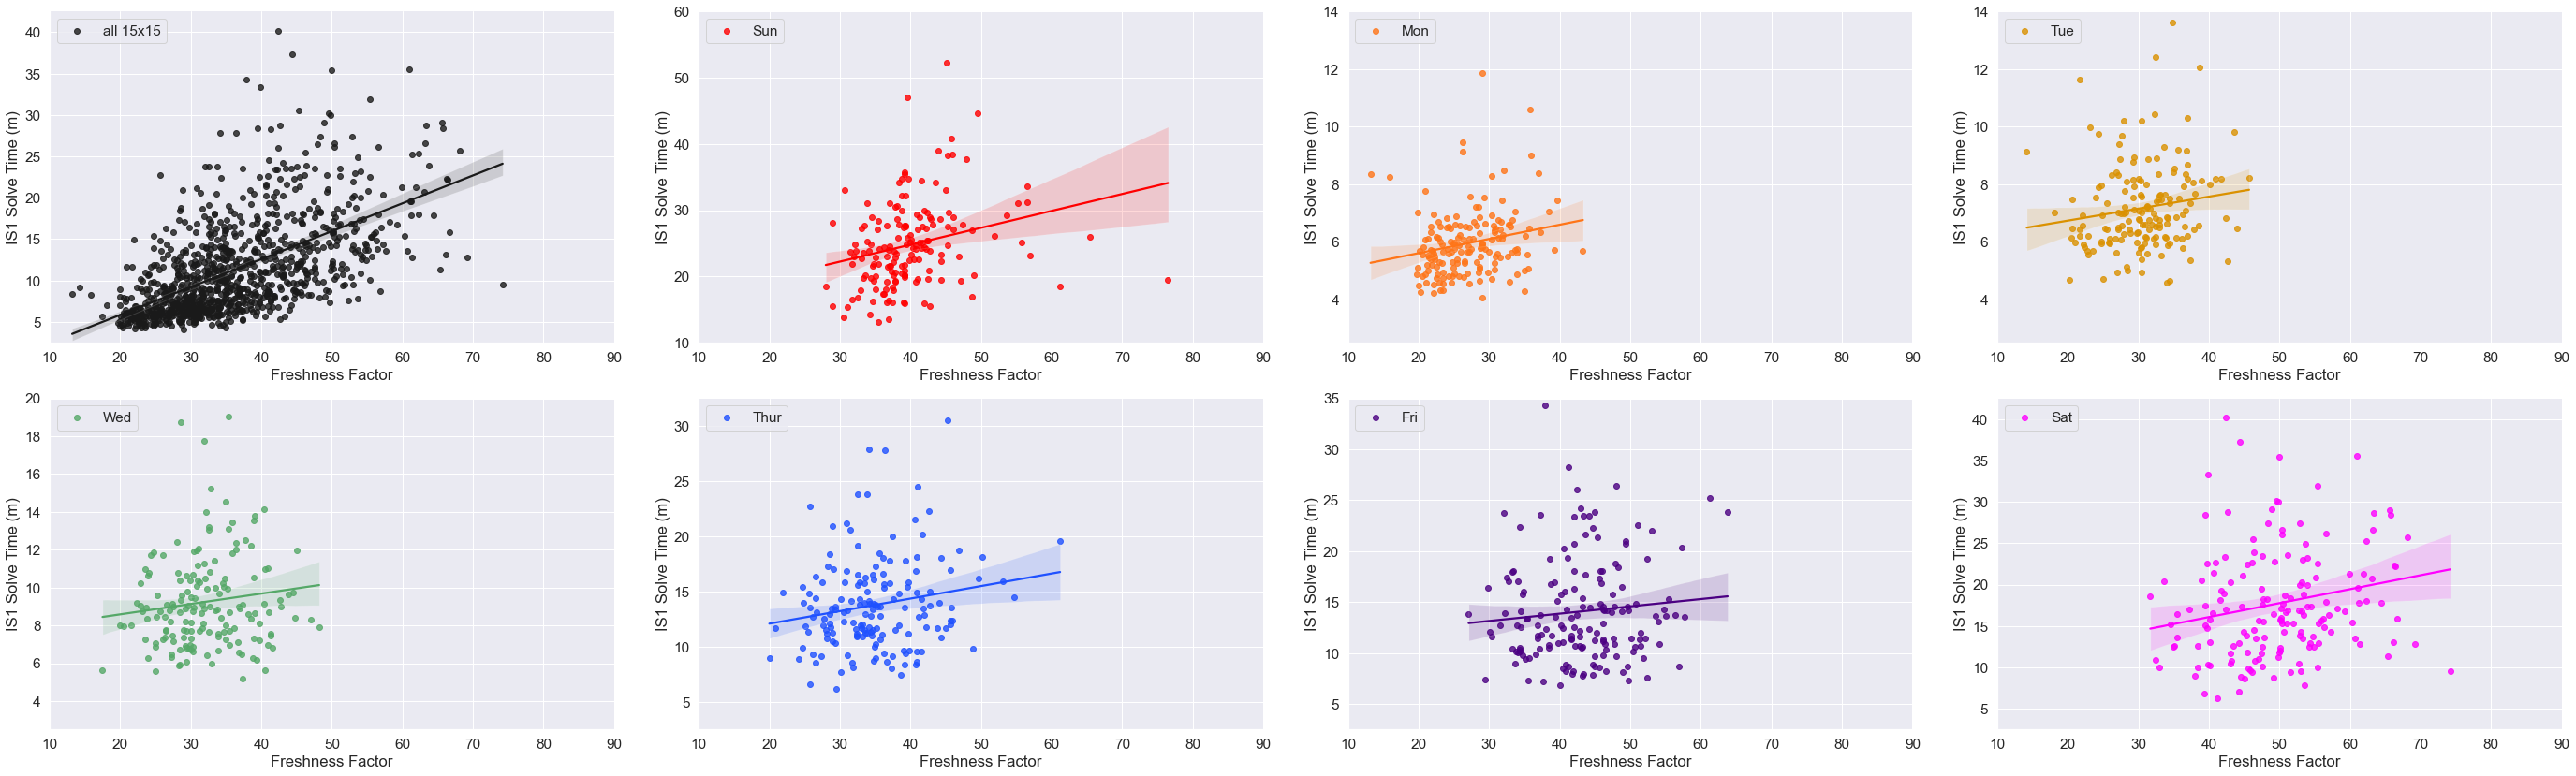

In [191]:
# Freshness Factor vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="Freshness_Factor", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "Freshness Factor",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((10,90))
p.axes[1].set_xlim((10,90))
p.axes[2].set_xlim((10,90))
p.axes[3].set_xlim((10,90))
p.axes[4].set_xlim((10,90))
p.axes[5].set_xlim((10,90))
p.axes[6].set_xlim((10,90))
p.axes[7].set_xlim((10,90))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [192]:
# Calculate Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Freshness_Factor']))

0.5800741745155104


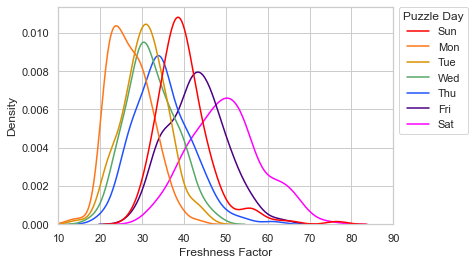

In [193]:
# Density plot of Freshness Factor in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df3 = IS1_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df3, x = "Freshness_Factor", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(10, 90)
ax.set_xlabel("Freshness Factor")
plt.show()

In [194]:
IS1_df3["Freshness_Factor"].agg(['min', 'max'])

min    13.2
max    76.5
Name: Freshness_Factor, dtype: float64

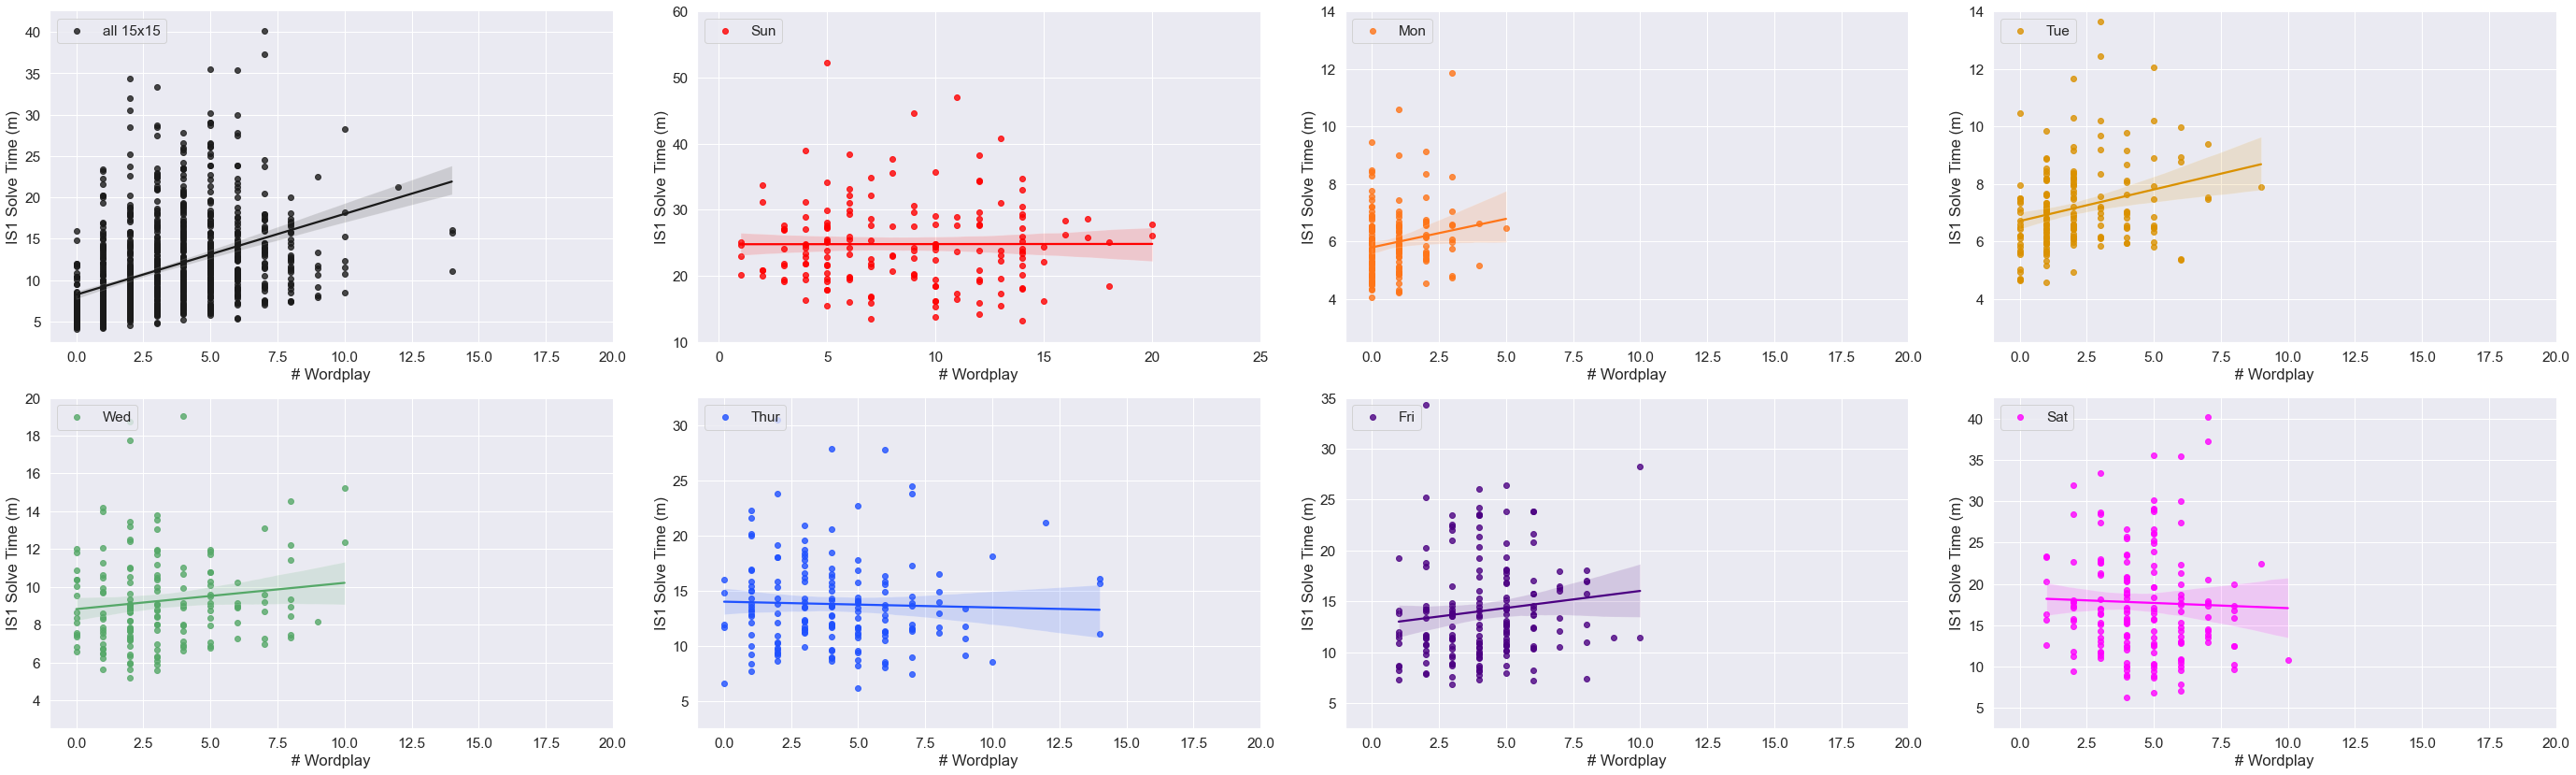

In [196]:
# Wordplay vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="Wordplay", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Wordplay",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,20))
p.axes[1].set_xlim((-1,25))
p.axes[2].set_xlim((-1,20))
p.axes[3].set_xlim((-1,20))
p.axes[4].set_xlim((-1,20))
p.axes[5].set_xlim((-1,20))
p.axes[6].set_xlim((-1,20))
p.axes[7].set_xlim((-1,20))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [197]:
# Calculate Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Wordplay']))

0.3940279773702087


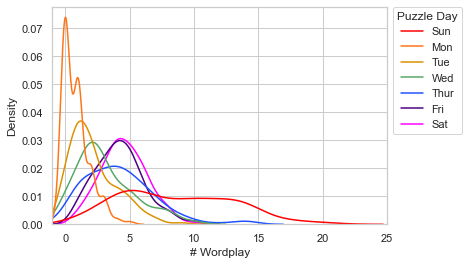

In [198]:
# Density plot of Wordplay in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df3 = IS1_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df3, x = "Wordplay", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(-1, 25)
ax.set_xlabel("# Wordplay")
plt.show()

In [199]:
IS1_df3["Wordplay"].agg(['min', 'max'])

min     0.0
max    20.0
Name: Wordplay, dtype: float64

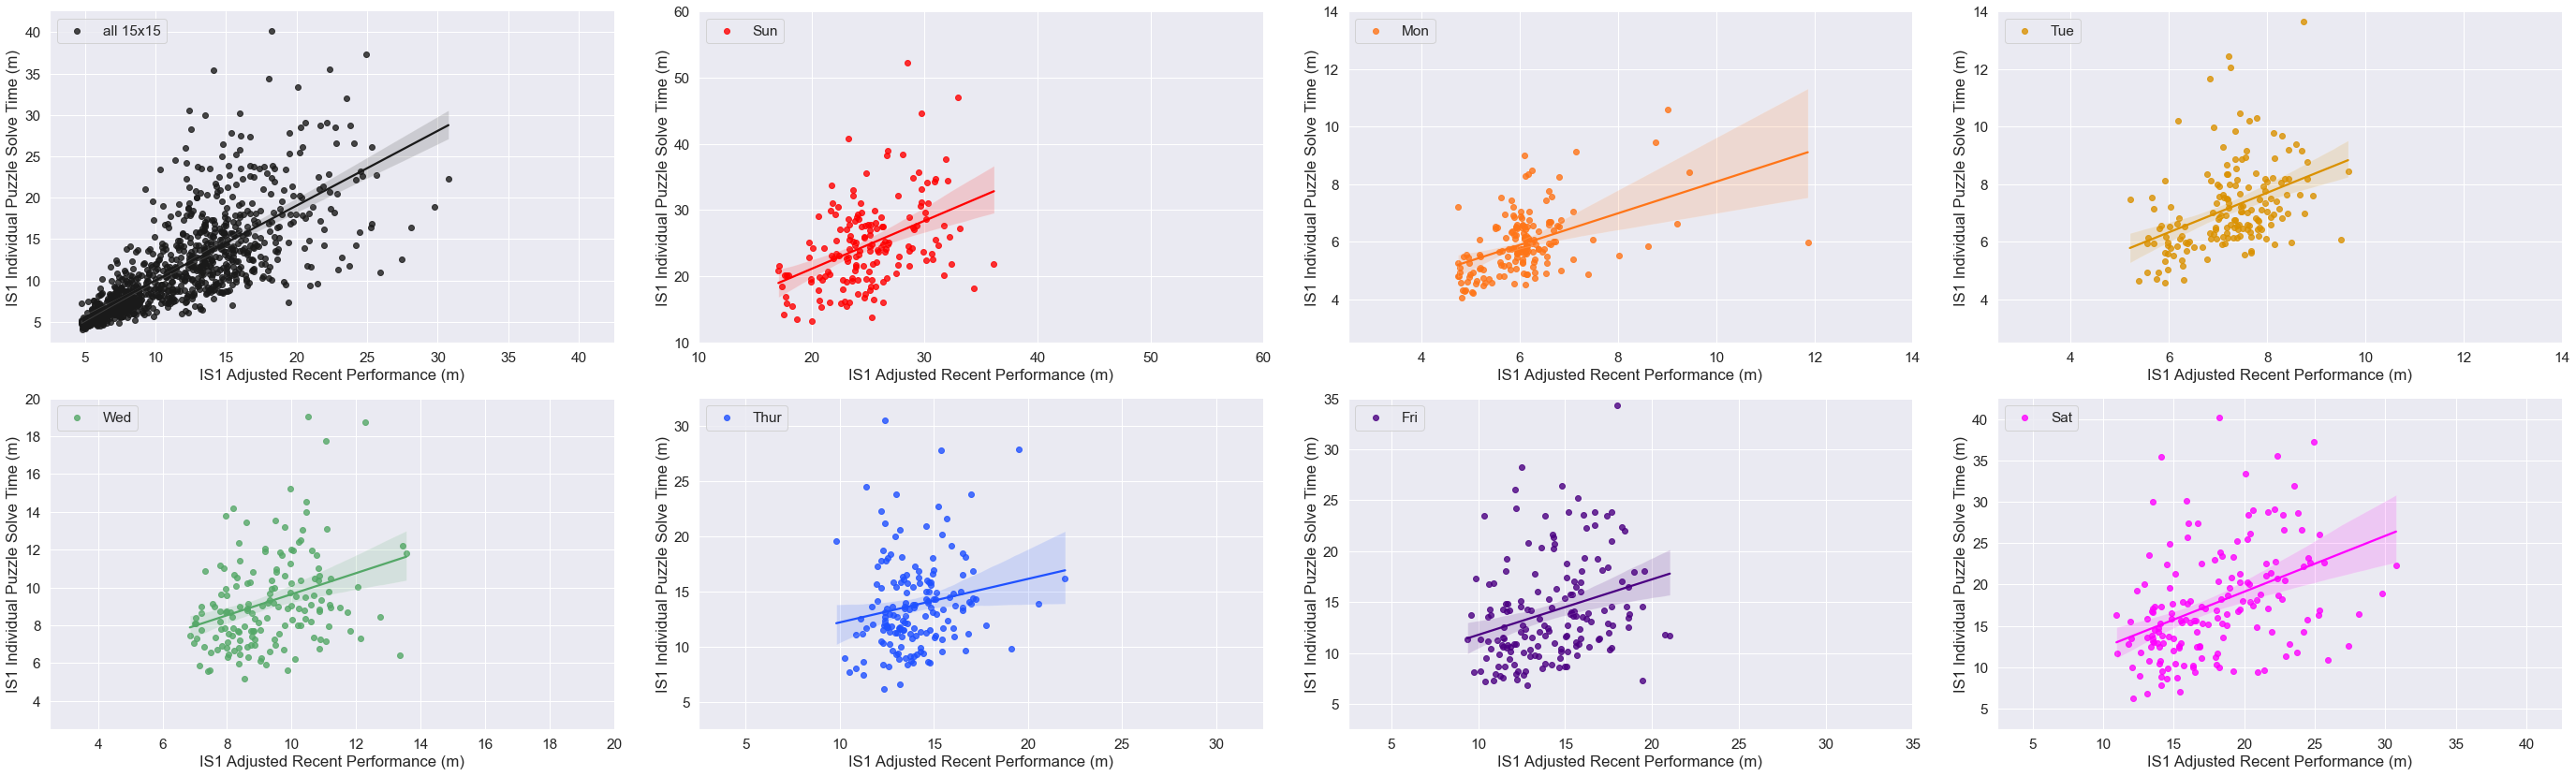

In [200]:
# IS1 Recent Past Performance (Time-Decay Weighted Immediately Previous 10 Puzzles Prior to a given puzzle) vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="IS_pds_l10_dw", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "IS1 Adjusted Recent Performance (m)",
    ylabel="IS1 Individual Puzzle Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((2.5,42.5))
p.axes[1].set_xlim((10,60))
p.axes[2].set_xlim((2.5,14))
p.axes[3].set_xlim((2.5,14))
p.axes[4].set_xlim((2.5,20))
p.axes[5].set_xlim((2.5,32.5))
p.axes[6].set_xlim((2.5,35))
p.axes[7].set_xlim((2.5,42.5))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [202]:
# Calculate Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['IS_pds_l10_dw']))

# Calculate Pearson R for each puzzle day for this feature
IS1_Sun = IS1_df3.loc[IS1_df3["DOW"]==("Sunday")]
print(IS1_Sun['IST(m)'].corr(IS1_Sun['IS_pds_l10_dw']))

IS1_Mon = IS1_df3.loc[IS1_df3["DOW"]==("Monday")]
print(IS1_Mon['IST(m)'].corr(IS1_Mon['IS_pds_l10_dw']))

IS1_Tue = IS1_df3.loc[IS1_df3["DOW"]==("Tuesday")]
print(IS1_Tue['IST(m)'].corr(IS1_Tue['IS_pds_l10_dw']))

IS1_Wed = IS1_df3.loc[IS1_df3["DOW"]==("Wednesday")]
print(IS1_Wed['IST(m)'].corr(IS1_Wed['IS_pds_l10_dw']))

IS1_Thu = IS1_df3.loc[IS1_df3["DOW"]==("Thursday")]
print(IS1_Thu['IST(m)'].corr(IS1_Thu['IS_pds_l10_dw']))

IS1_Fri = IS1_df3.loc[IS1_df3["DOW"]==("Friday")]
print(IS1_Fri['IST(m)'].corr(IS1_Fri['IS_pds_l10_dw']))

IS1_Sat = IS1_df3.loc[IS1_df3["DOW"]==("Saturday")]
print(IS1_Sat['IST(m)'].corr(IS1_Sat['IS_pds_l10_dw']))

0.7352993253996717
0.430151542979235
0.47276637102108077
0.40446064246284125
0.30224095800975265
0.17762378092669695
0.28495227602081735
0.3920866424134465


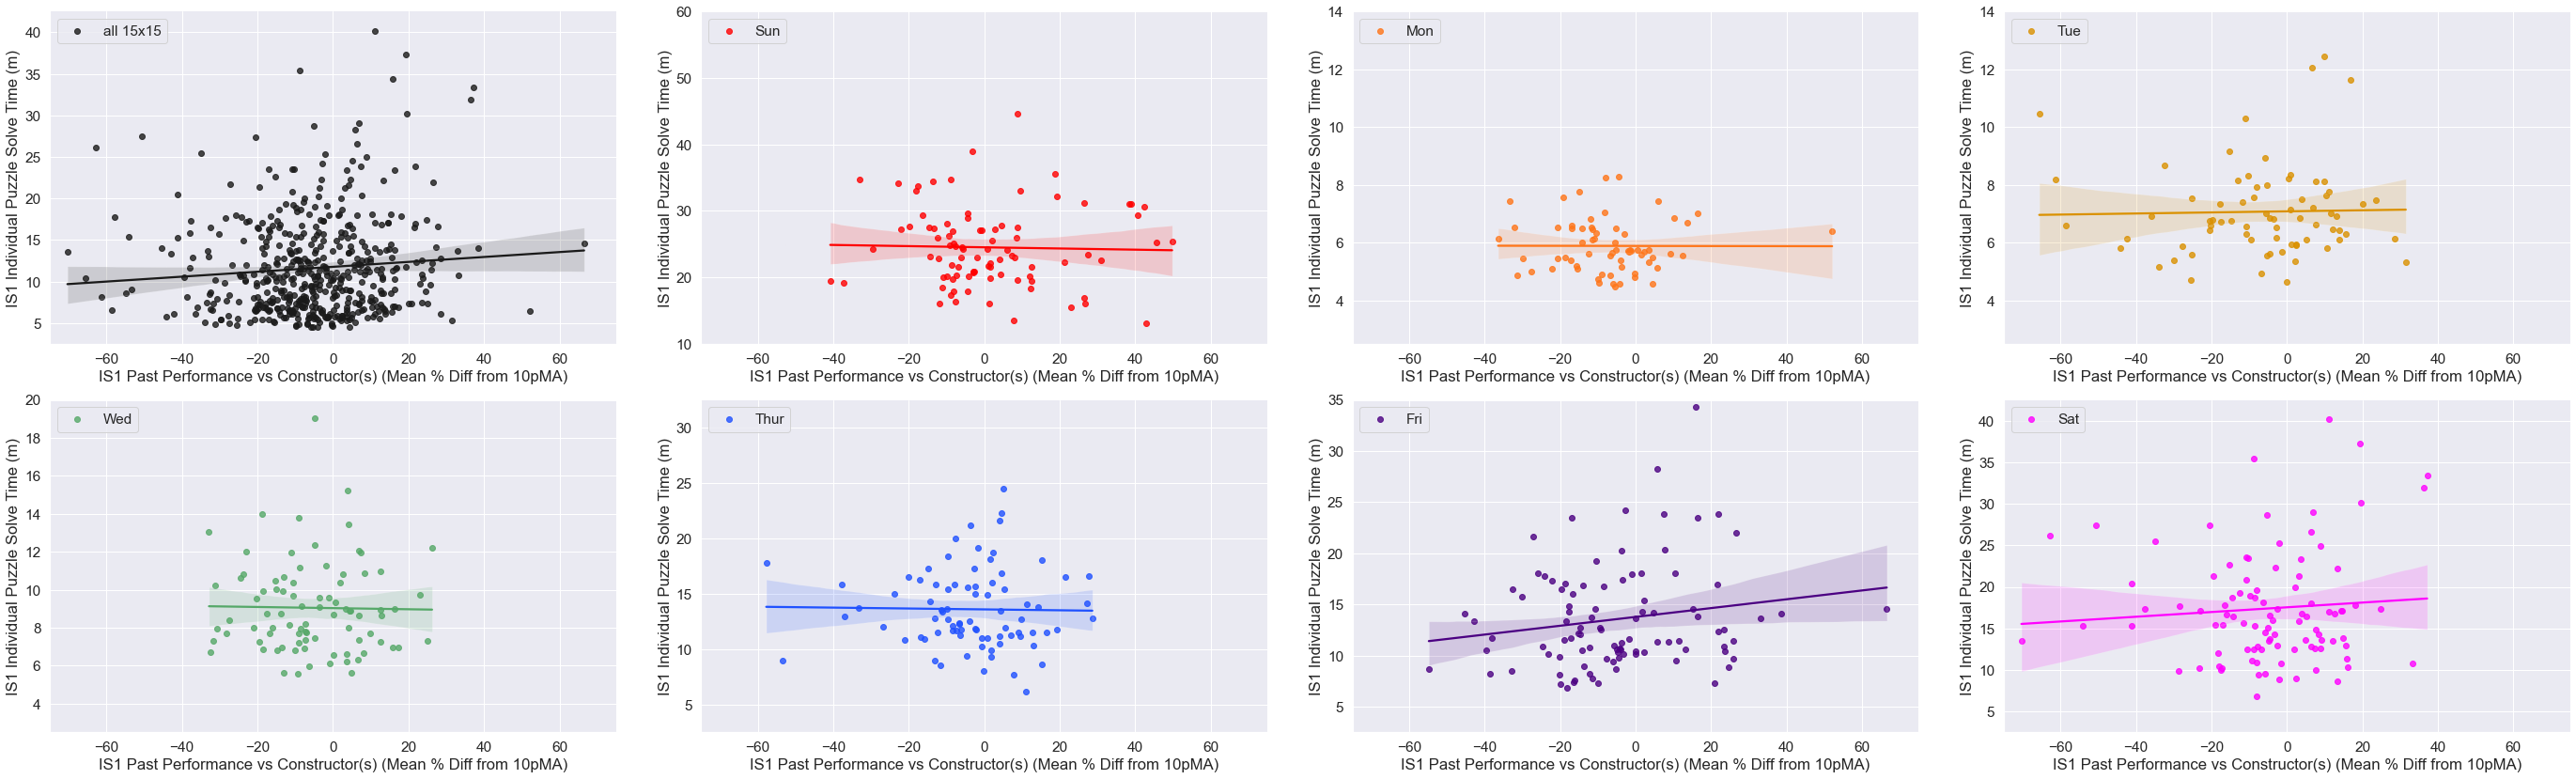

In [203]:
# Mean Past Performance vs Constructor(s) vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="IS_per_constr_avg_past_diff_from_10pMA", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "IS1 Past Performance vs Constructor(s) (Mean % Diff from 10pMA)",
    ylabel="IS1 Individual Puzzle Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-75,75))
p.axes[1].set_xlim((-75,75))
p.axes[2].set_xlim((-75,75))
p.axes[3].set_xlim((-75,75))
p.axes[4].set_xlim((-75,75))
p.axes[5].set_xlim((-75,75))
p.axes[6].set_xlim((-75,75))
p.axes[7].set_xlim((-75,75))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [204]:
# Calculate Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['IS_per_constr_avg_past_diff_from_10pMA']))

# Calculate Pearson R for each puzzle day for this feature
IS1_Sun = IS1_df3.loc[IS1_df3["DOW"]==("Sunday")]
print(IS1_Sun['IST(m)'].corr(IS1_Sun['IS_per_constr_avg_past_diff_from_10pMA']))

IS1_Mon = IS1_df3.loc[IS1_df3["DOW"]==("Monday")]
print(IS1_Mon['IST(m)'].corr(IS1_Mon['IS_per_constr_avg_past_diff_from_10pMA']))

IS1_Tue = IS1_df3.loc[IS1_df3["DOW"]==("Tuesday")]
print(IS1_Tue['IST(m)'].corr(IS1_Tue['IS_per_constr_avg_past_diff_from_10pMA']))

IS1_Wed = IS1_df3.loc[IS1_df3["DOW"]==("Wednesday")]
print(IS1_Wed['IST(m)'].corr(IS1_Wed['IS_per_constr_avg_past_diff_from_10pMA']))

IS1_Thu = IS1_df3.loc[IS1_df3["DOW"]==("Thursday")]
print(IS1_Thu['IST(m)'].corr(IS1_Thu['IS_per_constr_avg_past_diff_from_10pMA']))

IS1_Fri = IS1_df3.loc[IS1_df3["DOW"]==("Friday")]
print(IS1_Fri['IST(m)'].corr(IS1_Fri['IS_per_constr_avg_past_diff_from_10pMA']))

IS1_Sat = IS1_df3.loc[IS1_df3["DOW"]==("Saturday")]
print(IS1_Sat['IST(m)'].corr(IS1_Sat['IS_per_constr_avg_past_diff_from_10pMA']))

0.08872124830557218
-0.027710240772539155
-0.00279157260882033
0.02360750112441288
-0.01718161125190892
-0.01772972267922701
0.17241477423897503
0.08040695150438117


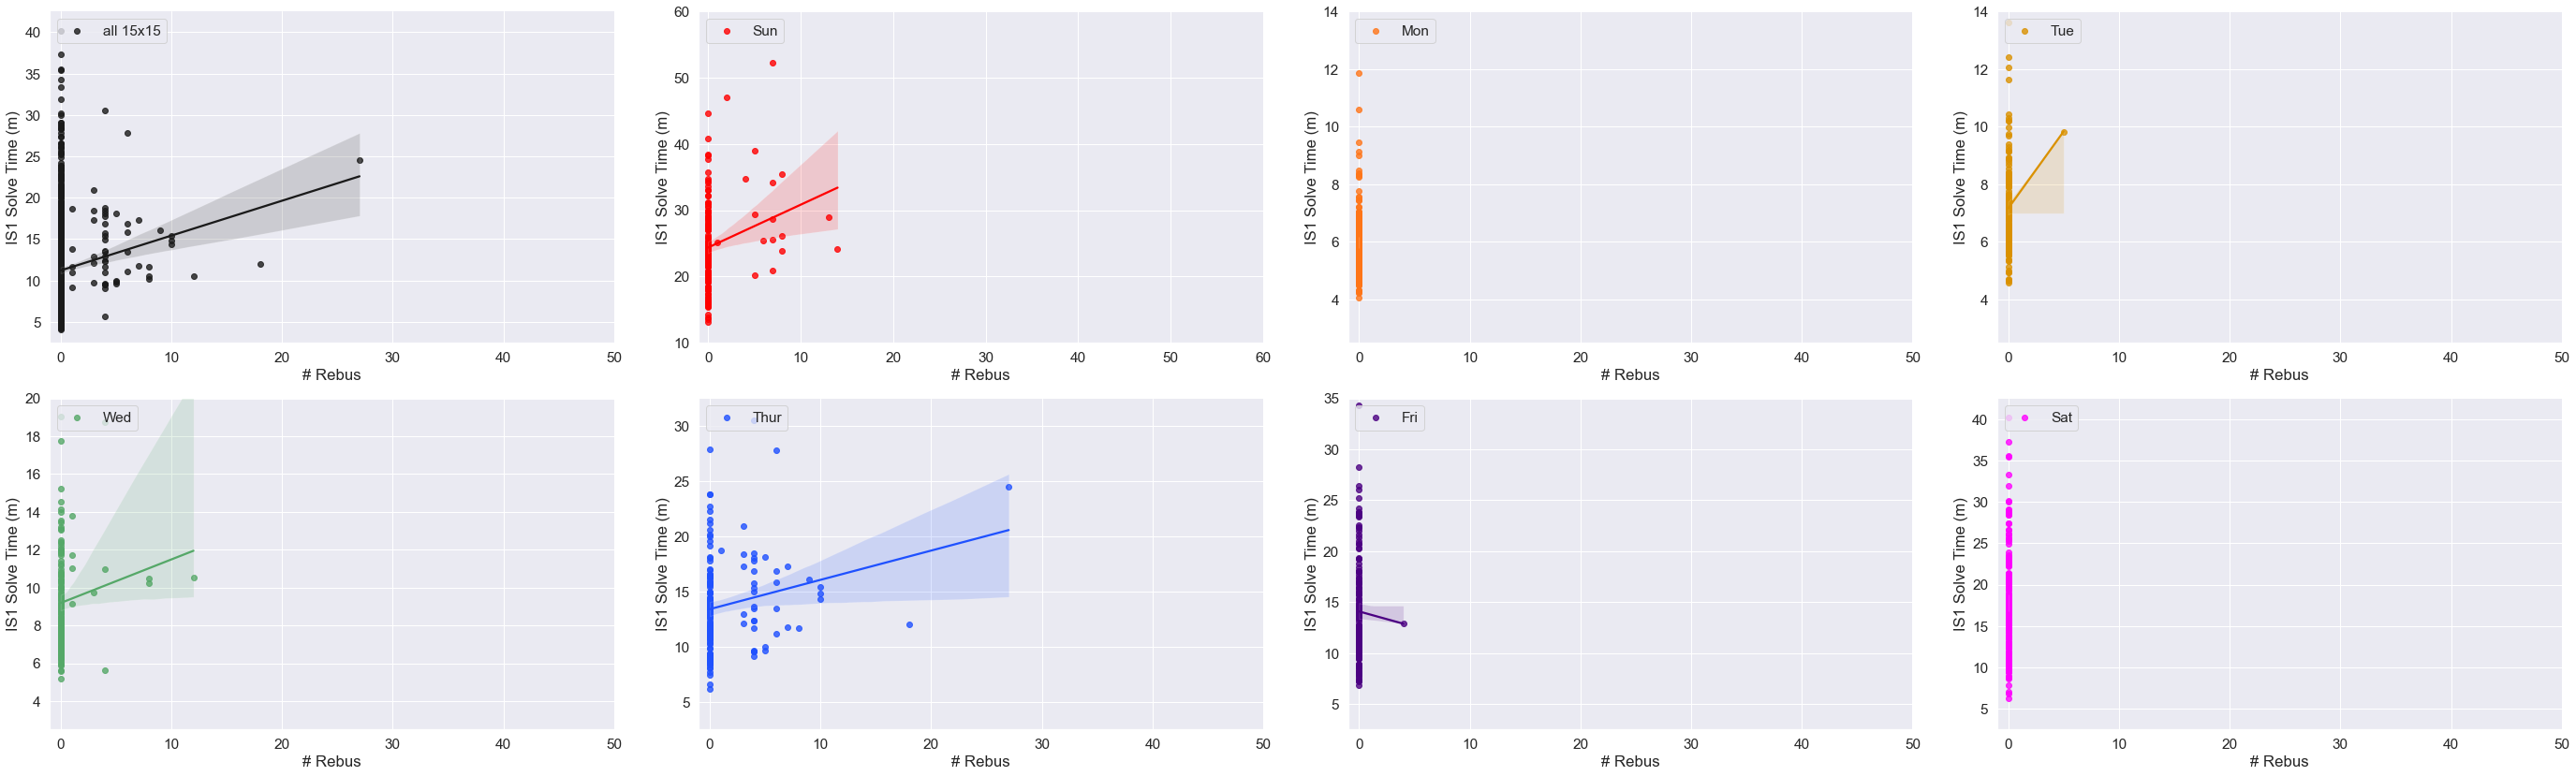

In [205]:
# Rebus vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="Rebus_Count", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Rebus",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,50))
p.axes[1].set_xlim((-1,60))
p.axes[2].set_xlim((-1,50))
p.axes[3].set_xlim((-1,50))
p.axes[4].set_xlim((-1,50))
p.axes[5].set_xlim((-1,50))
p.axes[6].set_xlim((-1,50))
p.axes[7].set_xlim((-1,50))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [206]:
# Calculate Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Rebus_Count']))

# Calculate Pearson R for each puzzle day for this feature
IS1_Sun = IS1_df3.loc[IS1_df3["DOW"]==("Sunday")]
print(IS1_Sun['IST(m)'].corr(IS1_Sun['Rebus_Count']))

IS1_Mon = IS1_df3.loc[IS1_df3["DOW"]==("Monday")]
print(IS1_Mon['IST(m)'].corr(IS1_Mon['Rebus_Count']))

IS1_Tue = IS1_df3.loc[IS1_df3["DOW"]==("Tuesday")]
print(IS1_Tue['IST(m)'].corr(IS1_Tue['Rebus_Count']))

IS1_Wed = IS1_df3.loc[IS1_df3["DOW"]==("Wednesday")]
print(IS1_Wed['IST(m)'].corr(IS1_Wed['Rebus_Count']))

IS1_Thu = IS1_df3.loc[IS1_df3["DOW"]==("Thursday")]
print(IS1_Thu['IST(m)'].corr(IS1_Thu['Rebus_Count']))

IS1_Fri = IS1_df3.loc[IS1_df3["DOW"]==("Friday")]
print(IS1_Fri['IST(m)'].corr(IS1_Fri['Rebus_Count']))

IS1_Sat = IS1_df3.loc[IS1_df3["DOW"]==("Saturday")]
print(IS1_Sat['IST(m)'].corr(IS1_Sat['Rebus_Count']))

0.11266756831978794
0.2272123362384177
nan
0.1383687502079356
0.12348988186307804
0.21316585091117193
-0.018793571283606987
nan


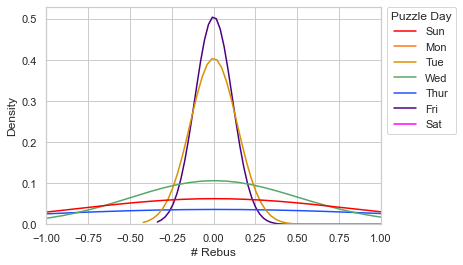

In [207]:
# Density plot of Rebus Count in puzzles solved by IS1
# Rememember to use df3 because df4 has the copied-in data for plotting all completed puzzles together

IS1_df3 = IS1_df3.sort_values(by=['DOW_num'], ascending = True)

sns.set(style="whitegrid")
ax = sns.kdeplot(data=IS1_df3, x = "Rebus_Count", hue= "plot_seq_map", palette=["red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"], legend=True)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.026), title='Puzzle Day')

plt.xlim(-1, 1)
ax.set_xlabel("# Rebus")
plt.show()

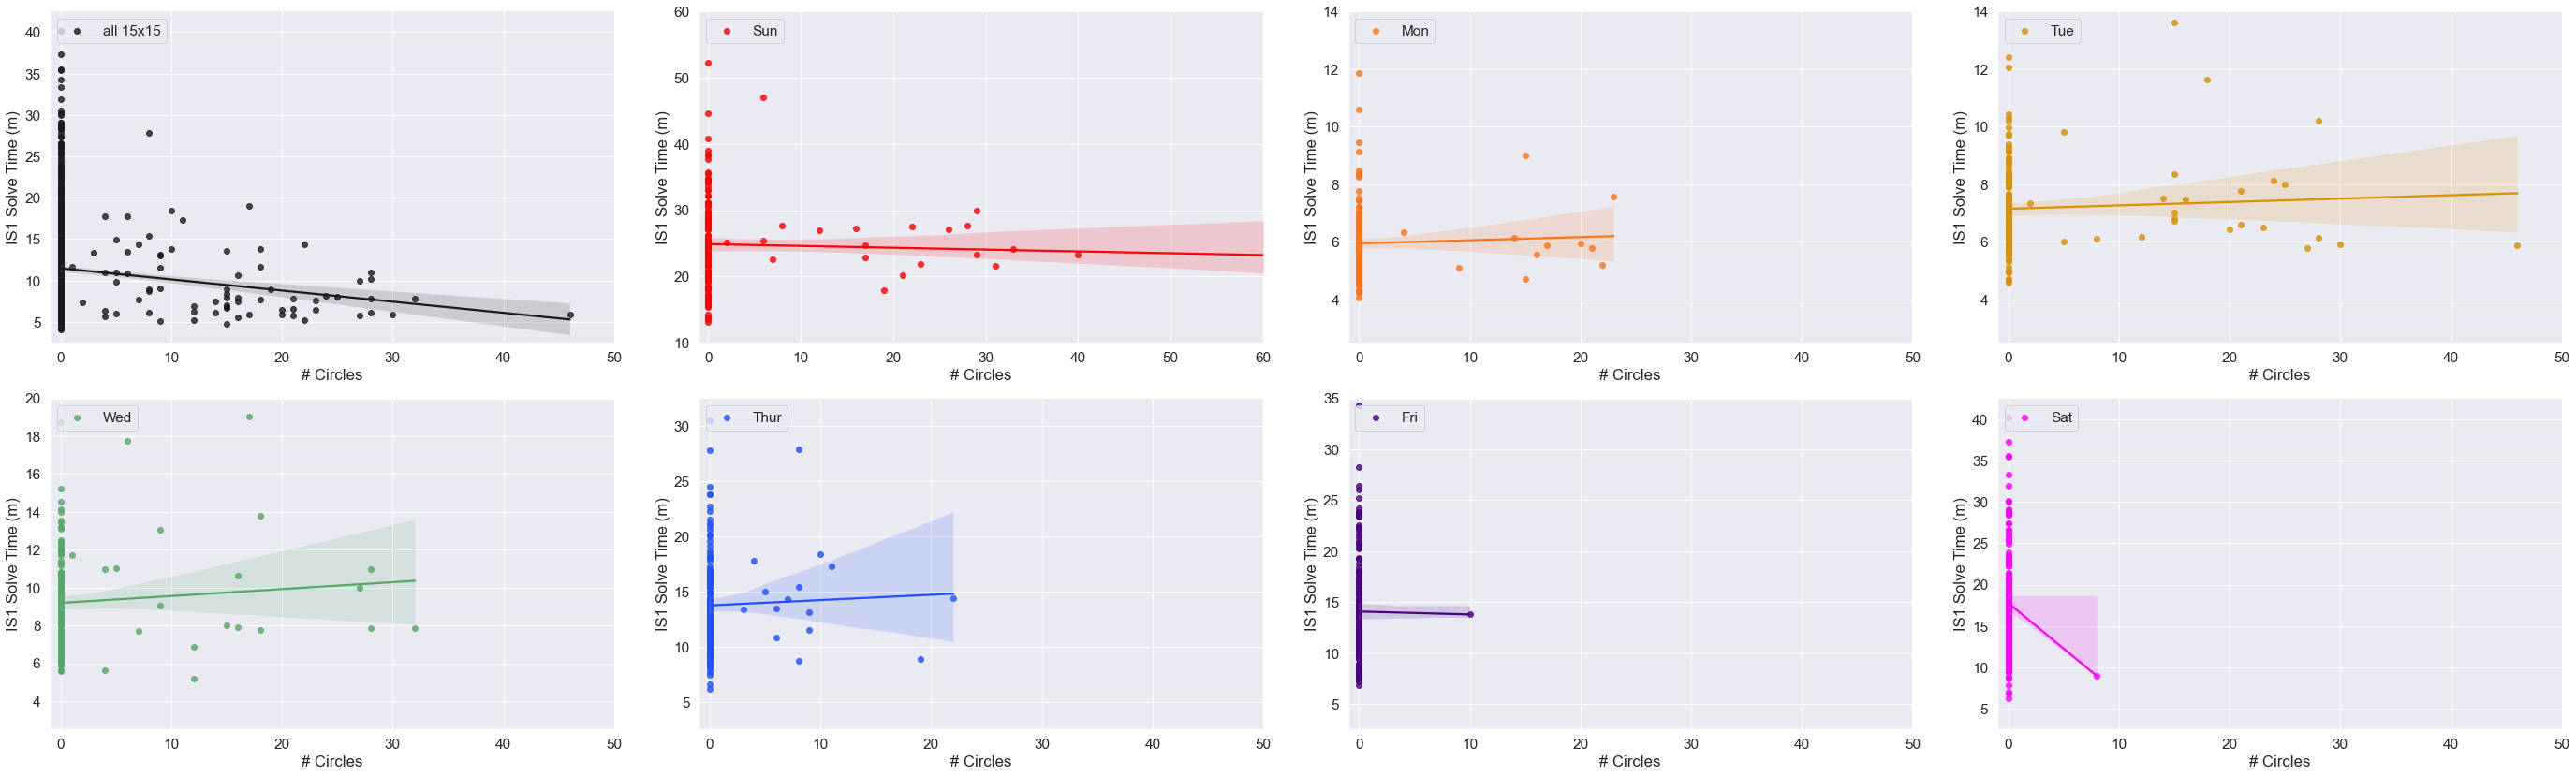

In [208]:
# Circles vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="Circle_Count", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Circles",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,50))
p.axes[1].set_xlim((-1,60))
p.axes[2].set_xlim((-1,50))
p.axes[3].set_xlim((-1,50))
p.axes[4].set_xlim((-1,50))
p.axes[5].set_xlim((-1,50))
p.axes[6].set_xlim((-1,50))
p.axes[7].set_xlim((-1,50))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [209]:
# Calculate Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Circle_Count']))

# Calculate Pearson R for each puzzle day for this feature
IS1_Sun = IS1_df3.loc[IS1_df3["DOW"]==("Sunday")]
print(IS1_Sun['IST(m)'].corr(IS1_Sun['Circle_Count']))

IS1_Mon = IS1_df3.loc[IS1_df3["DOW"]==("Monday")]
print(IS1_Mon['IST(m)'].corr(IS1_Mon['Circle_Count']))

IS1_Tue = IS1_df3.loc[IS1_df3["DOW"]==("Tuesday")]
print(IS1_Tue['IST(m)'].corr(IS1_Tue['Circle_Count']))

IS1_Wed = IS1_df3.loc[IS1_df3["DOW"]==("Wednesday")]
print(IS1_Wed['IST(m)'].corr(IS1_Wed['Circle_Count']))

IS1_Thu = IS1_df3.loc[IS1_df3["DOW"]==("Thursday")]
print(IS1_Thu['IST(m)'].corr(IS1_Thu['Circle_Count']))

IS1_Fri = IS1_df3.loc[IS1_df3["DOW"]==("Friday")]
print(IS1_Fri['IST(m)'].corr(IS1_Fri['Circle_Count']))

IS1_Sat = IS1_df3.loc[IS1_df3["DOW"]==("Saturday")]
print(IS1_Sat['IST(m)'].corr(IS1_Sat['Circle_Count']))

-0.10211887911036481
-0.03729669138160643
0.03993379757606989
0.05888512837355973
0.07831957466705122
0.0348072131015671
-0.004421644141217721
-0.0957908905838199


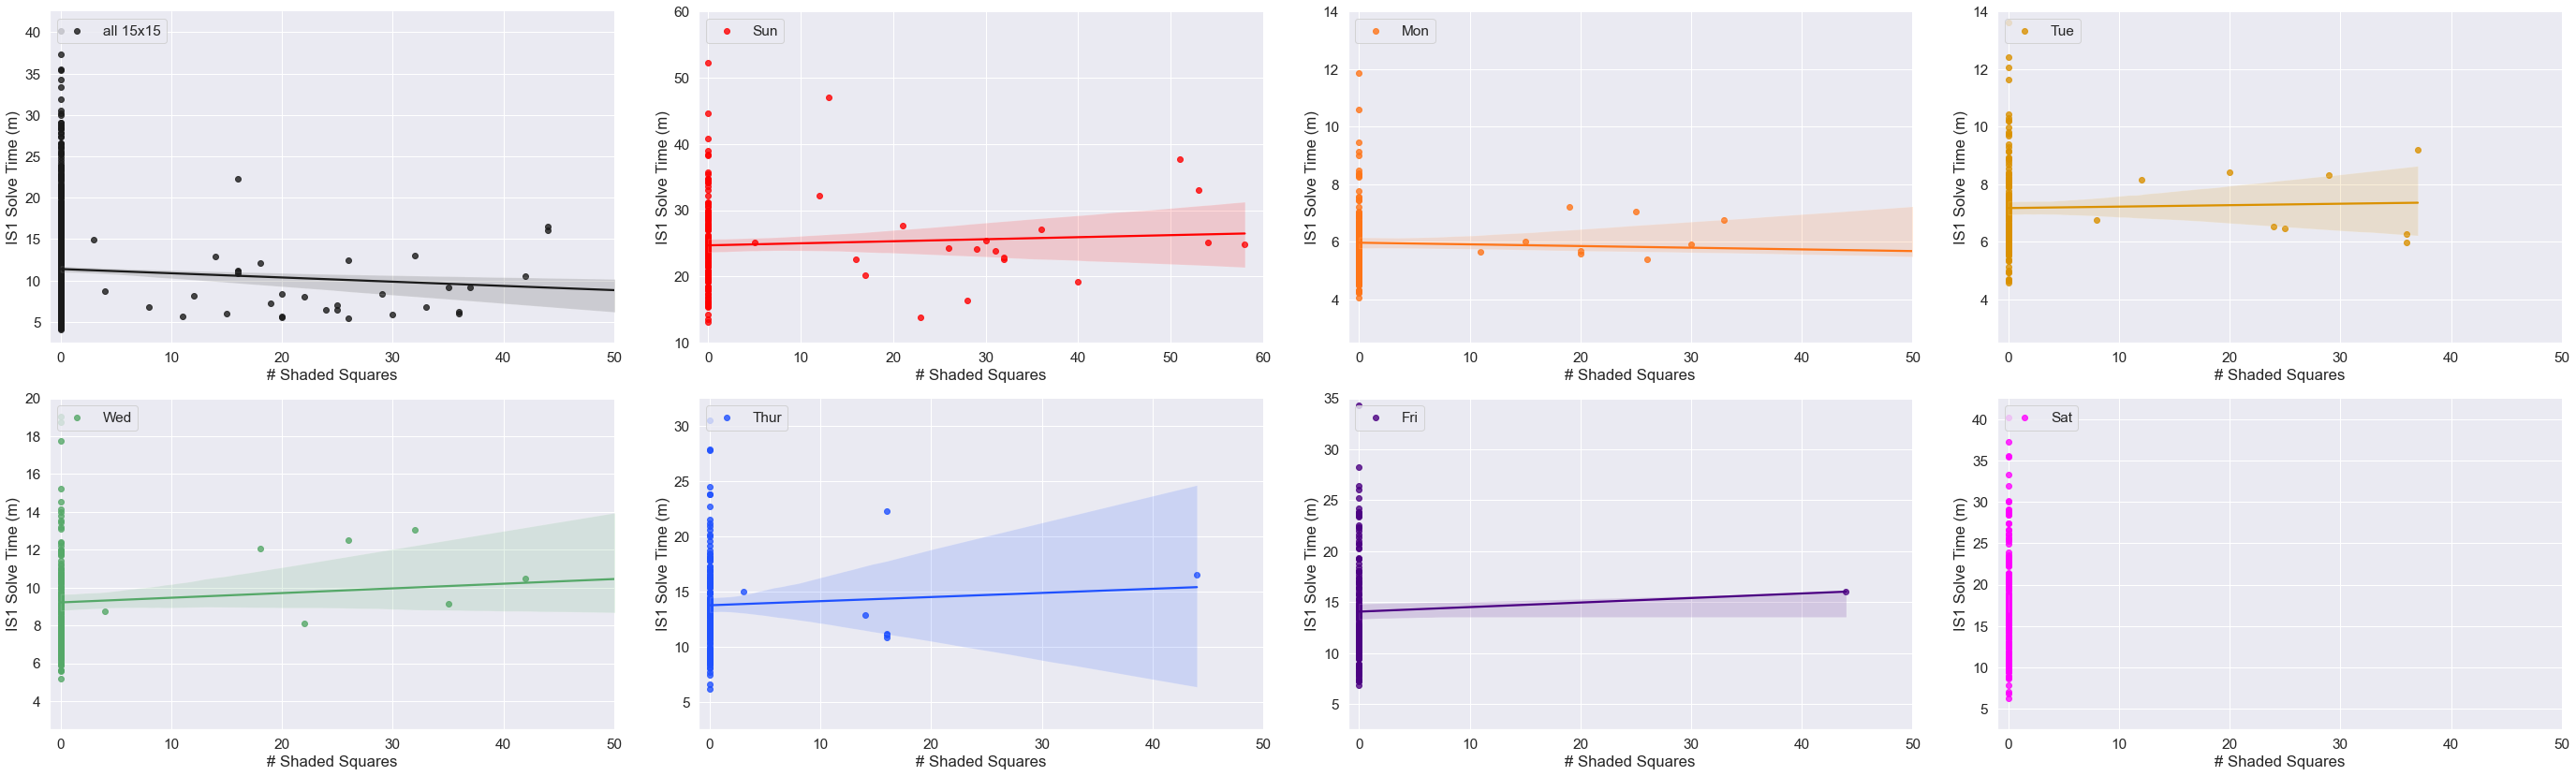

In [210]:
# Shaded Squares vs IS1 Raw Solve Times

IS1_df4 = IS1_df4.sort_values(by=['DOW_num'], ascending = True)

IS1_df4['plot_seq_map'] = IS1_df4['DOW_num'].map({0: 'all 15x15', 1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5: 'Thur', 6:'Fri', 7:'Sat'})

sns.set(font_scale=1.4)

p = sns.lmplot(
    data=IS1_df4, x="Shade_Count", y="IST(m)", hue="plot_seq_map", col="DOW_num", col_order=[0, 1, 2, 3, 4, 5, 6, 7], palette=["k", "red", "#FF7518", "#da9100", "g", "#1F51FF", "indigo", "fuchsia"],
    sharey=False, sharex=False, height=6, aspect=1.6, legend=False, col_wrap=4
).set(title="", xlabel= "# Shaded Squares",
    ylabel="IS1 Solve Time (m)"
)

#Adjust subplots individually
p.axes[0].set_xlim((-1,50))
p.axes[1].set_xlim((-1,60))
p.axes[2].set_xlim((-1,50))
p.axes[3].set_xlim((-1,50))
p.axes[4].set_xlim((-1,50))
p.axes[5].set_xlim((-1,50))
p.axes[6].set_xlim((-1,50))
p.axes[7].set_xlim((-1,50))

p.axes[0].set_ylim((2.5,42.5))
p.axes[1].set_ylim((10,60))
p.axes[2].set_ylim((2.5,14))
p.axes[3].set_ylim((2.5,14))
p.axes[4].set_ylim((2.5,20))
p.axes[5].set_ylim((2.5,32.5))
p.axes[6].set_ylim((2.5,35))
p.axes[7].set_ylim((2.5,42.5))

plt.subplots_adjust(wspace = 0.15) #increase whitespace btwn subplot colums

_= p.axes[0].legend(loc = 'upper left', title="")
_= p.axes[1].legend(loc = 'upper left')
_= p.axes[2].legend(loc = 'upper left')
_= p.axes[3].legend(loc = 'upper left')
_= p.axes[4].legend(loc = 'upper left')
_= p.axes[5].legend(loc = 'upper left')
_= p.axes[6].legend(loc = 'upper left')
_= p.axes[7].legend(loc = 'upper left')

In [211]:
# Calculate Pearson R for 15x15 grids for this feature
#IS1_15x15 = IS1_df3.loc[IS1_df3["DOW"]!=("Sunday")]

print(IS1_15x15['IST(m)'].corr(IS1_15x15['Shade_Count']))

# Calculate Pearson R for each puzzle day for this feature
IS1_Sun = IS1_df3.loc[IS1_df3["DOW"]==("Sunday")]
print(IS1_Sun['IST(m)'].corr(IS1_Sun['Shade_Count']))

IS1_Mon = IS1_df3.loc[IS1_df3["DOW"]==("Monday")]
print(IS1_Mon['IST(m)'].corr(IS1_Mon['Shade_Count']))

IS1_Tue = IS1_df3.loc[IS1_df3["DOW"]==("Tuesday")]
print(IS1_Tue['IST(m)'].corr(IS1_Tue['Shade_Count']))

IS1_Wed = IS1_df3.loc[IS1_df3["DOW"]==("Wednesday")]
print(IS1_Wed['IST(m)'].corr(IS1_Wed['Shade_Count']))

IS1_Thu = IS1_df3.loc[IS1_df3["DOW"]==("Thursday")]
print(IS1_Thu['IST(m)'].corr(IS1_Thu['Shade_Count']))

IS1_Fri = IS1_df3.loc[IS1_df3["DOW"]==("Friday")]
print(IS1_Fri['IST(m)'].corr(IS1_Fri['Shade_Count']))

IS1_Sat = IS1_df3.loc[IS1_df3["DOW"]==("Saturday")]
print(IS1_Sat['IST(m)'].corr(IS1_Sat['Shade_Count']))

-0.06405589096730058
0.052931521817464085
-0.07187311224286956
0.02072333370438666
0.06853133175963864
0.038779968167309116
0.030593596532967095
nan
